In [1]:
import torch
import torchaudio
from torchaudio.transforms import MelSpectrogram
from torch.utils.data import DataLoader

import os
import time
import re
from pathlib import Path
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt


# Download Dataset

In [2]:
import torchaudio
import torch.utils.data as data
import os

if __name__ == "__main__":
    dataset_dir = "/home/fanche/thesis/Mamba-ASR/dataset"
    if not os.path.isdir(dataset_dir):
        os.makedirs(dataset_dir)

    # for Librispeech
    splits = ["train-clean-100", "train-clean-360", "train-other-500"]

    test_clean_url="test-clean"
    test_other_url="test-other"

    dev_clean_url="dev-clean"
    dev_other_url="dev-other"

    train_dataset100 = torchaudio.datasets.LIBRISPEECH(dataset_dir, url=splits[0], download=True)
    train_dataset360 = torchaudio.datasets.LIBRISPEECH(dataset_dir, url=splits[1], download=True)
    train_dataset500 = torchaudio.datasets.LIBRISPEECH(dataset_dir, url=splits[2], download=True)

    test_clean_dataset = torchaudio.datasets.LIBRISPEECH(dataset_dir, url=test_clean_url, download=True)
    test_other_dataset = torchaudio.datasets.LIBRISPEECH(dataset_dir, url=test_other_url, download=True)

    dev_clean_dataset = torchaudio.datasets.LIBRISPEECH(dataset_dir, url=dev_clean_url, download=True)
    dev_other_dataset = torchaudio.datasets.LIBRISPEECH(dataset_dir, url=dev_other_url, download=True)

    # Combine the dataset splits into a single dataset
    train_dataset460 = data.ConcatDataset([train_dataset100, train_dataset360])
    train_dataset960 = data.ConcatDataset([train_dataset100, train_dataset360, train_dataset500])
    all_dataset = data.ConcatDataset([train_dataset460, train_dataset500, test_clean_dataset, test_other_dataset, dev_clean_dataset, dev_other_dataset])

    # for TEDLIUM
    release = 'release3'
    splits = ["train", "dev", "test"]

    ted_train_dataset = torchaudio.datasets.TEDLIUM(dataset_dir, release=release, subset=splits[0], download=True)
    ted_dev_dataset = torchaudio.datasets.TEDLIUM(dataset_dir, release=release, subset=splits[1], download=True)
    ted_test_dataset = torchaudio.datasets.TEDLIUM(dataset_dir, release=release, subset=splits[2], download=True)


In [3]:
if __name__ == "__main__":
    # show the number of samples in the dataset
    print("Number of samples in train-clean-100: ", len(train_dataset100))
    print("Number of samples in train-clean-360: ", len(train_dataset360))
    print("Number of samples in train-clean-460: ", len(train_dataset460))
    print("Number of samples in train-other-500: ", len(train_dataset500))
    print("Number of samples in test-clean: ", len(test_clean_dataset))
    print("Number of samples in test-other: ", len(test_other_dataset))
    print("Number of samples in dev-clean: ", len(dev_clean_dataset))
    print("Number of samples in dev-other: ", len(dev_other_dataset))
    print("Number of samples in ted_train_dataset: ", len(ted_train_dataset))
    print("Number of samples in ted_dev_dataset: ", len(ted_dev_dataset))
    print("Number of samples in ted_test_dataset: ", len(ted_test_dataset))

    # show the MAX and MIN length of the target TEXT in the dataset
    # max_len = 0
    # min_len = 1000
    # for i in range(len(train_dataset100)):
    #     waveform, _, utterance, _, _, _ = train_dataset100[i]
    #     max_len = max(max_len, len(utterance))
    #     min_len = min(min_len, len(utterance))

    # print("MAX length of the target TEXT in the dataset: ", max_len)
    # print("MIN length of the target TEXT in the dataset: ", min_len)

Number of samples in train-clean-100:  28539
Number of samples in train-clean-360:  104014
Number of samples in train-clean-460:  132553
Number of samples in train-other-500:  148688
Number of samples in test-clean:  2620
Number of samples in test-other:  2939
Number of samples in dev-clean:  2703
Number of samples in dev-other:  2864
Number of samples in ted_train_dataset:  268263
Number of samples in ted_dev_dataset:  591
Number of samples in ted_test_dataset:  1469


# tokenizer

In [4]:
def normalize_text(text):
    """
    正規化文本：轉為小寫、去除多餘的空格和特殊字符。
    """
    # 轉換為小寫
    text = text.lower()
    
    # 去除非字母和數字的字符（保留基本標點符號，例如句點）
    text = re.sub(r"[^a-z0-9\s.,!?\'\`]", "", text)
    
    # 去除多餘的空格
    text = re.sub(r"\s+", " ", text).strip()
    
    return text

def extract_text_and_save(dataset, output_file):
    """
    從 LibriSpeech 數據集提取文本，並保存到文件。
    """
    with open(output_file, "w", encoding="utf-8") as f:
        for i, item in tqdm(enumerate(dataset)):
            transcript = item[2]  # 只提取轉錄文本
            # normalized_transcript = normalize_text(transcript)
            f.write(transcript.lower() + "\n")
    print(f"文本已保存至 {output_file}")

if __name__ == "__main__":
    # output_file = "corpus960.txt"
    output_file = "corpusted.txt"
    # extract_text_and_save(ted_train_dataset, output_file)

In [5]:
import sentencepiece as spm
import time

# 使用 SentencePiece 訓練模型
def train_sentencepiece(corpus_file, model_prefix, vocab_size, special_tokens=[]):
    """
    使用 SentencePiece 訓練分片模型。
    """
    spm.SentencePieceTrainer.Train(
        input=corpus_file,
        model_prefix=model_prefix,
        vocab_size=vocab_size,
        character_coverage=1.0,  # 支援完整字符集
        model_type="bpe",  # 或選擇 'unigram', 'char', 'word'
        user_defined_symbols=special_tokens
    )
    print(f"SentencePiece 模型訓練完成，模型前綴為: {model_prefix}")

if __name__ == "__main__":
    model_prefix = "spm_librispeech-960-5000"
    # model_prefix = "spm_ted-5000"
    vocab_size = 5000
    special_tokens = ["<pad>", "<blank>"]

    t1 = time.time()
    # train_sentencepiece(output_file, model_prefix, vocab_size, special_tokens=special_tokens)
    print("time:", time.time() - t1)

time: 4.76837158203125e-07


In [6]:
import sentencepiece as spm

if __name__ == "__main__":
    # 加載並測試模型
    model_prefix = "spm_librispeech-960-5000"
    # model_prefix = "spm_ted-5000"
    sp = spm.SentencePieceProcessor(model_file=f"{model_prefix}.model")

    print("<unk>:", sp.unk_id())
    print("<s>:", sp.bos_id())
    print("</s>:", sp.eos_id())
    print("<pad>:", sp.piece_to_id("<pad>"))
    print("<blank>:", sp.piece_to_id("<blank>"))

    print("vocab size:", sp.get_piece_size())

    # 列出所有標記
    # for i in range(sp.get_piece_size()):
    #     print(i, sp.id_to_piece(i))


<unk>: 0
<s>: 1
</s>: 2
<pad>: 3
<blank>: 4
vocab size: 5000


In [7]:
if __name__ == "__main__":
    test_sentence = "this is a test sentence for sentencepiece"
    # test_sentence = "CHAPTER ONE MISSUS RACHEL LYNDE IS SURPRISED MISSUS RACHEL LYNDE LIVED JUST WHERE THE AVONLEA MAIN ROAD DIPPED DOWN INTO A LITTLE HOLLOW FRINGED WITH ALDERS AND LADIES EARDROPS AND TRAVERSED BY A BROOK"
    tokens = sp.encode_as_pieces(test_sentence)
    ids = sp.encode_as_ids(test_sentence)

    print("測試句子:", test_sentence)
    print("分詞結果:", tokens)
    print("ID 結果:", ids)

    # 測試句子加入<bos>和<eos>
    # test_sentence = sp.id_to_piece(1) + test_sentence + sp.id_to_piece(2)
    # tokens = sp.encode_as_pieces(test_sentence)

    # new_ids = [sp.bos_id()] + ids + [sp.eos_id()]
    new_ids = [1] + ids + [2]
    print("ID 結果（加入 <bos> 和 <eos>）:", new_ids)

    # 測試new_ids轉換回句子
    new_sentence = sp.decode_ids(new_ids)
    print("轉換後句子:", new_sentence)


測試句子: this is a test sentence for sentencepiece
分詞結果: ['▁this', '▁is', '▁a', '▁test', '▁sentence', '▁for', '▁sentence', 'p', 'ie', 'ce']
ID 結果: [139, 96, 7, 3161, 4497, 79, 4497, 4991, 169, 73]
ID 結果（加入 <bos> 和 <eos>）: [1, 139, 96, 7, 3161, 4497, 79, 4497, 4991, 169, 73, 2]
轉換後句子: this is a test sentence for sentencepiece


# Dataset

In [8]:
import torch.nn as nn

class SentencePieceTransform:
    """Maps subwords to integers and vice versa using SentencePiece"""
    def __init__(self, model_path):
        self.sp = spm.SentencePieceProcessor()
        self.sp.Load(model_path)

    def text_to_int(self, text):
        """ Use the SentencePiece tokenizer to convert text to an integer sequence """
        subwords = self.sp.EncodeAsPieces(text.lower())
        return [self.sp.PieceToId(subword) for subword in subwords]

    def int_to_text(self, labels):
        """ Use the SentencePiece tokenizer to convert integer labels to a text sequence """
        return self.sp.decode(labels)

In [9]:
import torchaudio.transforms as T
import torch.nn.functional as F

class FastSlidingCMVN(nn.Module):
    """GPU 版滑動 CMVN，會自動處理短於視窗的序列。"""
    def __init__(self, cmn_window: int = 301):
        super().__init__()
        self.K = cmn_window | 1          # force odd
        kernel = torch.ones(1, 1, self.K) / self.K
        self.register_buffer("kernel", kernel)

    def forward(self, feats: torch.Tensor) -> torch.Tensor:  # [B,T,F]
        B, T, C = feats.shape
        x = feats.transpose(1, 2).reshape(B * C, 1, T)       # [B*C,1,T]

        # 若序列短於視窗 => 直接做句級 CMVN
        if T < self.K:
            mu  = x.mean(dim=2, keepdim=True)
            std = x.var(dim=2, unbiased=False, keepdim=True).clamp(1e-8).sqrt()
            norm = (x - mu) / std
        else:
            pad = self.K // 2
            # 對極短序列 (T==1) 改用 replicate，避免 reflect 失敗
            pad_mode = "reflect" if T > 1 else "replicate"
            x_pad = F.pad(x, (pad, pad), mode=pad_mode)
            mu  = torch.conv1d(x_pad, self.kernel)
            var = torch.conv1d(x_pad.pow(2), self.kernel) - mu.pow(2)
            std = var.clamp(1e-8).sqrt()
            norm = (x - mu) / std

        return norm.reshape(B, C, T).transpose(1, 2)         # [B,T,F]

# ---------- Wave → logMel → CMVN → Aug --------------------- #
class Wave2Fbank(nn.Module):
    def __init__(self, train=True):
        super().__init__()
        self.speed = T.SpeedPerturbation(16000, [0.9, 1.0, 1.1]) if train else None
        self.mel   = T.MelSpectrogram(sample_rate=16000, n_mels=80)
        self.cmvn  = FastSlidingCMVN(301)
        self.fmask = T.FrequencyMasking(27) if train else None
        self.tmask = T.TimeMasking(15, p=0.05) if train else None

    def forward(self, wav):                       # wav:  [1, time] (CPU)
        if self.speed is not None:
            wav, _ = self.speed(wav)

        power = self.mel(wav).clamp_min(1e-5)   # [1,80,T]
        fb = 10.0 * power.log10()
        fb = fb.transpose(1, 2)                      # → [1,T,80]
        fb = self.cmvn(fb)
        fb = fb.transpose(1, 2)                      # → [1,80,T]
        if self.fmask is not None:
            fb = self.fmask(fb)
            fb = self.tmask(fb)
        return fb     

In [10]:
if __name__ == "__main__":
    train_audio_transforms = Wave2Fbank(train=True)
    valid_audio_transforms = Wave2Fbank(train=False)
    

In [11]:
def data_processing(data, data_type="train", tokenizer=None):
    spectrograms = []
    labels = []
    ar_tgts = []
    ar_labels = []
    input_lengths = []
    label_lengths = []

    for (waveform, _, utterance, _, _, _) in data:
        if data_type == 'train':
            spec = train_audio_transforms(waveform).squeeze(0).transpose(0, 1)
        elif data_type == 'valid':
            spec = valid_audio_transforms(waveform).squeeze(0).transpose(0, 1)
        else:
            raise Exception('data_type should be train or valid')
        
        spectrograms.append(spec)
        label = torch.tensor(tokenizer.text_to_int(utterance.lower()), dtype=torch.long)

        # add <sos> (1) in the label
        ar_tgt = torch.cat((torch.tensor([tokenizer.sp.bos_id()]), label))
        # add <eos> (2) in the label
        ar_label = torch.cat((label, torch.tensor([tokenizer.sp.eos_id()])))
        
        labels.append(label)
        ar_tgts.append(ar_tgt)
        ar_labels.append(ar_label)
        input_lengths.append(spec.shape[0])
        label_lengths.append(len(label))

    spectrograms = nn.utils.rnn.pad_sequence(spectrograms, batch_first=True, padding_side='left').unsqueeze(1).transpose(2, 3) # mamba
    # spectrograms = nn.utils.rnn.pad_sequence(spectrograms, batch_first=True, padding_value=0).unsqueeze(1).transpose(2, 3) # conformer
    labels = nn.utils.rnn.pad_sequence(labels, batch_first=True, padding_value=tokenizer.sp.piece_to_id("<pad>"))
    ar_tgts = nn.utils.rnn.pad_sequence(ar_tgts, batch_first=True, padding_value=tokenizer.sp.piece_to_id("<pad>"))
    ar_labels = nn.utils.rnn.pad_sequence(ar_labels, batch_first=True, padding_value=tokenizer.sp.piece_to_id("<pad>"))

    return spectrograms, labels, ar_tgts, ar_labels, input_lengths, label_lengths


In [12]:
import torch
import torchaudio
from torch.utils.data import Sampler
import numpy as np

if __name__ == "__main__":
    train_dataset = train_dataset960
    dev_dataset = dev_clean_dataset
    # train_dataset = ted_train_dataset
    # dev_dataset = ted_dev_dataset

    # print("Fetching lengths...")
    # lengths = [train_dataset[i][0].shape[1] for i in tqdm(range(len(train_dataset)))]
    # print("Done.")

    # sorted_indices = np.argsort(lengths)

In [13]:
class BucketingSampler(Sampler):
    """
    一個正確且高效的批次取樣器。
    它會先將長度相近的樣本分組，然後在每個 epoch 打亂這些批次的順序。
    """
    def __init__(self, data_source, sorted_indices, batch_size):
        super().__init__(data_source)
        self.sorted_indices = sorted_indices
        self.batch_size = batch_size
        
        self.batches = [
            self.sorted_indices[i:i + self.batch_size]
            for i in range(0, len(self.sorted_indices), self.batch_size)
        ]
        
        if len(self.batches[-1]) < self.batch_size:
             self.batches = self.batches[:-1]

    def __iter__(self):
        np.random.shuffle(self.batches)
        
        for batch in self.batches:
            yield batch

    def __len__(self):
        return len(self.batches)

In [14]:
import torch.utils.data as data

if __name__ == "__main__":
    tokenizer = SentencePieceTransform(f"{model_prefix}.model")
    batch_size = 32

    # batch_sampler = BucketingSampler(
    # data_source=train_dataset,
    # sorted_indices=sorted_indices,
    # batch_size=batch_size
    # )
    
    train_loader = data.DataLoader(dataset=train_dataset,
                            batch_size=batch_size,
                            shuffle=True,
                            collate_fn=lambda x: data_processing(x, 'train', tokenizer),
                            num_workers=8,
                            pin_memory=True)
    
    # train_loader = data.DataLoader(dataset=train_dataset,
    #                       batch_sampler=batch_sampler,
    #                       collate_fn=lambda x: data_processing(x, 'train', tokenizer),
    #                       num_workers=4,
    #                       pin_memory=True)

    dev_clean_loader = data.DataLoader(dataset=dev_dataset, 
                                batch_size= batch_size,
                                shuffle=False,
                                collate_fn=lambda x: data_processing(x, 'valid', tokenizer),
                                num_workers=8,
                                prefetch_factor=4,
                                pin_memory=True)
    
    dev_other_loader = data.DataLoader(dataset=dev_other_dataset,
                                batch_size= batch_size,
                                shuffle=False,
                                collate_fn=lambda x: data_processing(x, 'valid', tokenizer),
                                num_workers=8,
                                pin_memory=True)

    test_clean_loader = data.DataLoader(dataset=test_clean_dataset,
                                batch_size= 16,
                                shuffle=False,
                                collate_fn=lambda x: data_processing(x, 'valid', tokenizer),
                                num_workers=8,
                                pin_memory=True)
    
    test_other_loader = data.DataLoader(dataset=test_other_dataset,
                                batch_size= 16,
                                shuffle=False,
                                collate_fn=lambda x: data_processing(x, 'valid', tokenizer),
                                num_workers=8,
                                pin_memory=True)

    ted_dev_loader = data.DataLoader(dataset=ted_dev_dataset,
                                batch_size= 8,
                                shuffle=False,
                                collate_fn=lambda x: data_processing(x, 'valid', tokenizer),
                                num_workers=8,
                                pin_memory=True)

    ted_test_loader = data.DataLoader(dataset=ted_test_dataset,
                                batch_size= 8,
                                shuffle=False,
                                collate_fn=lambda x: data_processing(x, 'valid', tokenizer),
                                num_workers=8,
                                pin_memory=True)

In [15]:
if __name__ == "__main__":
    # 測試加載 2 個 batch
    for i, batch in enumerate(train_loader):
        spectrograms, labels, ar_tgts, aed_labels, input_lengths, label_lengths = batch
        print('spectrograms:', spectrograms.shape)
        print('labels:', labels.shape)
        print('labels:', labels[0])
        print('ar_tgts:', ar_tgts.shape)
        print('ar_tgts:', ar_tgts[0])
        print('aed_labels:', aed_labels.shape)
        print('aed_labels:', aed_labels[0])
        print('input_lengths:', input_lengths)
        print('label_lengths:', label_lengths)
        # print('aed_pad_lengths:', aed_pad_lengths)
        # print('aed_label_idxs:', aed_label_idxs[0])
        print("target:", labels[0].tolist())
        print("target:", tokenizer.int_to_text(labels[0].tolist()))
        print("\n")

        if i == 1:
            break

spectrograms: torch.Size([32, 1, 80, 1428])
labels: torch.Size([32, 66])
labels: tensor([2471,   61,   35,   63,  669,  671,   31, 2517,  353,    8, 1296,  145,
         102, 4980,   32,   82,  436, 2244,  179,    8, 4167,  838,  288,  226,
         461,  243,   35,  697,    8,  411,  745,  283,   82,  285,   86, 1173,
         105,  595, 1192,   93, 1710,  307,  369,    8,  411,  654,  179,  105,
          95,   27, 3295,   58,  131,  135,  836,    3,    3,    3,    3,    3,
           3,    3,    3,    3,    3,    3])
ar_tgts: torch.Size([32, 67])
ar_tgts: tensor([   1, 2471,   61,   35,   63,  669,  671,   31, 2517,  353,    8, 1296,
         145,  102, 4980,   32,   82,  436, 2244,  179,    8, 4167,  838,  288,
         226,  461,  243,   35,  697,    8,  411,  745,  283,   82,  285,   86,
        1173,  105,  595, 1192,   93, 1710,  307,  369,    8,  411,  654,  179,
         105,   95,   27, 3295,   58,  131,  135,  836,    3,    3,    3,    3,
           3,    3,    3,    3,    

# Model (ctc-aed)

In [16]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch import Tensor
from typing import Tuple
from torch.utils import checkpoint

from models.mamba.mamba_ssm.modules.mamba2_simple import Mamba2Simple
from models.mamba.mamba_ssm.modules.bimamba2_simple import BiMamba2Simple
from models.mamba.mamba_ssm.modules.biattnmamba2_simple import BiAttnMamba2Simple
from models.mamba.mamba_ssm.modules.crossattnmamba2_simple import CrossAttnMamba2Simple
from models.mamba.mamba_ssm.modules.attnmamba2_simple import AttnMamba2Simple

# ------------------------------
# 固定的 Sinusoidal Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=2000):
        """
        d_model: 輸入特徵的維度
        dropout: dropout 機率
        max_len: 句子的最大長度
        """
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float32) *
                             (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # shape: [1, max_len, d_model]
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        x: Tensor, shape [batch_size, seq_len, d_model]
        """
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)
'''
class Conv2dSubampling(nn.Module):
    """
    Convolutional 2D subsampling (to 1/4 length)

    Args:
        in_channels (int): Number of channels in the input image
        out_channels (int): Number of channels produced by the convolution

    Inputs: inputs
        - **inputs** (batch, time, dim): Tensor containing sequence of inputs

    Returns: outputs, output_lengths
        - **outputs** (batch, time, dim): Tensor produced by the convolution
        - **output_lengths** (batch): list of sequence output lengths
    """
    def __init__(self, in_channels: int, out_channels: int) -> None:
        super(Conv2dSubampling, self).__init__()
        self.sequential = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=2),
            nn.ReLU(),
        )

    def forward(self, inputs: Tensor, input_lengths: Tensor) -> Tuple[Tensor, Tensor]:
        outputs = self.sequential(inputs.unsqueeze(1))
        batch_size, channels, subsampled_lengths, sumsampled_dim = outputs.size()

        outputs = outputs.permute(0, 2, 1, 3)
        outputs = outputs.contiguous().view(batch_size, subsampled_lengths, channels * sumsampled_dim)
        # print("Outputs in conv:", outputs[0])
        output_lengths = input_lengths >> 2
        output_lengths -= 1

        # 計算pad_lengths，表示每個序列左側填充長度
        # print("outputs after conv:", outputs[0])
        # print("output_lengths after conv:", output_lengths[0])

        return outputs, output_lengths, #pad_lengths, output_idxs
'''

class Conv2dSubampling(nn.Module):
    """
    1 → 64 → 32 Conv2d  + LayerNorm(freq, ch) + LeakyReLU + Dropout
    時間/頻率各下採樣 4×，最終展平成 640 維向量。
    """
    def __init__(self, in_channels: int = 1, freq_bins: int = 80) -> None:
        super().__init__()

        # ─── 1→64 ───
        self.conv0 = nn.Conv2d(in_channels, 64, kernel_size=3, stride=2, padding=1)
        self.ln0   = nn.LayerNorm([freq_bins // 2, 64])        # (F'=40, C=64)
        self.act0  = nn.LeakyReLU(0.01, inplace=True)
        self.drop0 = nn.Dropout(0.1)

        # ─── 64→32 ───
        self.conv1 = nn.Conv2d(64, 32, kernel_size=3, stride=2, padding=1)
        self.ln1   = nn.LayerNorm([freq_bins // 4, 32])        # (F''=20, C=32)
        self.act1  = nn.LeakyReLU(0.01, inplace=True)
        self.drop1 = nn.Dropout(0.1)

        # Flatten 後目標維度必須為 640
        self.out_dim = 32 * (freq_bins // 4)
        assert self.out_dim == 640, "freq_bins 必須使最終扁平維度為 640"

    def forward(self, inputs: Tensor, input_lengths: Tensor) -> Tuple[Tensor, Tensor]:
        """
        inputs : (B, T, F)
        returns: (B, T/4, 640), (B,)
        """
        x = inputs.unsqueeze(1)                   # → (B, 1, T, F)

        # ─── Block 0 ───
        x = self.conv0(x)                         # (B, 64, T/2, F/2)
        x = x.permute(0, 2, 3, 1)                 # (B, T', F', C)
        x = self.ln0(x)
        x = self.act0(x)
        x = self.drop0(x)
        x = x.permute(0, 3, 1, 2)                 # 回到 (B, 64, T', F')

        # ─── Block 1 ───
        x = self.conv1(x)                         # (B, 32, T/4, F/4)
        x = x.permute(0, 2, 3, 1)                 # (B, T'', F'', C)
        x = self.ln1(x)
        x = self.act1(x)
        x = self.drop1(x)
        x = x.permute(0, 3, 1, 2)                 # (B, 32, T'', F'')

        # 展平成序列向量
        B, C, T_sub, F_sub = x.size()             # C=32, F_sub=freq_bins/4
        x = x.permute(0, 2, 1, 3).contiguous()    # (B, T_sub, C, F_sub)
        outputs = x.view(B, T_sub, C * F_sub)     # (B, T_sub, 640)

        # 時間長度下採樣（//4 − 1）
        output_lengths = (input_lengths >> 2) - 1
        return outputs, output_lengths

class mlp(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(mlp, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
        self.act = nn.GELU()  # 使用 GELU 激活函數
        # self.act = nn.ReLU()  # 使用 ReLU 激活函數

    def forward(self, x):
        x = self.dropout(self.act(self.fc1(x)))
        x = self.fc2(x)
        return x
    
class MambaEncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads,feed_forward_dim, dropout, device):
        super(MambaEncoderLayer, self).__init__()
        self.mamba2 = BiAttnMamba2Simple(
            d_model=d_model,
            d_state=64,
            window_size=4,
            expand=2,
            headdim=d_model//num_heads,
            ngroups=1,
            learnable_init_states=False,
            causal=False,
            activation="swish",
            device=device
        )

        # self.mamba2 = BiMamba2Simple(
        #     d_model=d_model,
        #     d_state=64,
        #     d_conv=4,
        #     expand=2,
        #     headdim=d_model//num_heads,
        #     ngroups=1,
        #     learnable_init_states=False,
        #     activation="swish",
        #     device=device
        # )

        # self.norm1 = nn.LayerNorm(d_model)
        # self.norm2 = nn.LayerNorm(d_model)
        self.norm1 = nn.RMSNorm(d_model, elementwise_affine=False)  # 交叉注意力前的正規化
        self.norm2 = nn.RMSNorm(d_model, elementwise_affine=False)  # 前饋網絡前的正規化
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.mlp = mlp(d_model, feed_forward_dim, dropout)

    def forward(self, x, mask, input_idxs=None) -> Tensor:
        # x = x + self.dropout1(self.mamba2(u=self.norm1(x), seq_idx=input_idxs))
        x = x * mask.unsqueeze(-1)  # 將填充部分設置為0
        x = x + self.dropout1(self.mamba2(u=self.norm1(x), mask=mask))
        # x = x + self.dropout1(self.mamba2(u=self.norm1(x)))
        x = x + self.dropout2(self.mlp(self.norm2(x)))

        return x

class MambaEncoder(nn.Module):
    """
    MambaEncoder encoder first processes the input with a convolution subsampling layer and then
    with a number of Mamba2 blocks.

    Args:
        input_dim (int, optional): Dimension of input vector
        encoder_dim (int, optional): Dimension of conformer encoder
        num_layers (int, optional): Number of conformer blocks
        num_attention_heads (int, optional): Number of attention heads
        feed_forward_expansion_factor (int, optional): Expansion factor of feed forward module
        conv_expansion_factor (int, optional): Expansion factor of conformer convolution module
        feed_forward_dropout_p (float, optional): Probability of feed forward module dropout
        attention_dropout_p (float, optional): Probability of attention module dropout
        conv_dropout_p (float, optional): Probability of conformer convolution module dropout
        conv_kernel_size (int or tuple, optional): Size of the convolving kernel
        half_step_residual (bool): Flag indication whether to use half step residual or not

    Inputs: inputs, input_lengths
        - **inputs** (batch, time, dim): Tensor containing input vector
        - **input_lengths** (batch): list of sequence input lengths

    Returns: outputs, output_lengths
        - **outputs** (batch, out_channels, time): Tensor produces by conformer encoder.
        - **output_lengths** (batch): list of sequence output lengths
    """
    def __init__(
            self,
            input_dim: int = 80,
            d_model: int = 512,
            num_layers: int = 4,
            num_heads: int = 4,
            feed_forward_dim: int = 2048,
            dropout_p: float = 0.1,
            max_len: int = 2000,
    ):
        super(MambaEncoder, self).__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.conv_subsample = Conv2dSubampling(in_channels=1, freq_bins=80)
        flatten_dim = 32 * (input_dim // 4)  # 80 → 20；32×20＝640
        self.input_projection = nn.Sequential(
            nn.Linear(flatten_dim, d_model),
            nn.Dropout(p=dropout_p),
        )
        # self.input_projection = nn.Sequential(
        #     nn.Linear(d_model * (((input_dim - 1) // 2 - 1) // 2), d_model),
        #     nn.Dropout(p=dropout_p),
        # )
        self.layers = nn.ModuleList([
            MambaEncoderLayer(
                d_model=d_model,
                num_heads=num_heads,
                feed_forward_dim=feed_forward_dim,
                dropout=dropout_p,
                device=self.device
            )
            for _ in range(num_layers)
        ])
        self.norm = nn.LayerNorm(d_model)

    def count_parameters(self) -> int:
        """ Count parameters of encoder """
        return sum([p.numel() for p in self.parameters()])

    def update_dropout(self, dropout_p: float) -> None:
        """ Update dropout probability of encoder """
        for name, child in self.named_children():
            if isinstance(child, nn.Dropout):
                child.p = dropout_p

    def forward(self, inputs: Tensor, input_lengths: Tensor) -> Tuple[Tensor, Tensor]:
        """
        Forward propagate a `inputs` for  encoder training.

        Args:
            inputs (torch.FloatTensor): A input sequence passed to encoder. Typically for inputs this will be a padded
                `FloatTensor` of size ``(batch, seq_length, dimension)``.
            input_lengths (torch.LongTensor): The length of input tensor. ``(batch)``

        Returns:
            (Tensor, Tensor)

            * outputs (torch.FloatTensor): A output sequence of encoder. `FloatTensor` of size
                ``(batch, seq_length, dimension)``
            * output_lengths (torch.LongTensor): The length of output tensor. ``(batch)``
        """
        # print("inputs in encoder:", inputs[0])

        outputs, output_lengths = self.conv_subsample(inputs, input_lengths)
        # print("outputs after conv:", outputs[0])
        outputs = self.input_projection(outputs)
        # print("outputs after proj:", outputs[0])

        # 假設output_lengths包含每個序列的有效長度
        batch_size, seq_len = outputs.shape[:2]
        
        arange   = torch.arange(seq_len, device=outputs.device)         # [seq_len]
        left_pad = seq_len - output_lengths                             # [batch_size]
        mask     = arange.unsqueeze(0) >= left_pad.unsqueeze(1)         # [batch_size, seq_len]
        # output_idxs = output_idxs.to(self.device)

        for layer in self.layers:
            # outputs = layer(outputs, mask)
            outputs = checkpoint.checkpoint(layer, outputs, mask, use_reentrant=False)
            # if torch.isnan(outputs).any():
            #     print(">>>In incoder Found NaN in logits!")
            # if torch.isinf(outputs).any():
            #     print(">>>In incoder Found ±Inf in logits!")
        # print("outputs after encoder layer:", outputs[0])
        outputs = self.norm(outputs)
        # print("outputs after norm:", outputs[0])
        # print("output_lengths:", output_lengths[0])
        # print("mask:", mask[0])

        return outputs, output_lengths, mask
    
class MambaDecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, feed_forward_dim, dropout, device):
        super(MambaDecoderLayer, self).__init__()

        # 交叉注意力層 - 處理目標序列與編碼器輸出的交互
        self.crossmamba2 = CrossAttnMamba2Simple(
            d_model=d_model,
            d_state=64,
            window_size=4,
            expand=2,
            headdim=d_model//num_heads,
            ngroups=1,
            learnable_init_states=False,
            causal=True,
            activation="swish",
            device=device
        )

        # self.crossmamba2 = Mamba2Simple(
        #     d_model=d_model,
        #     d_state=64,
        #     d_conv=4,
        #     expand=2,
        #     headdim=d_model//num_heads,
        #     ngroups=1,
        #     learnable_init_states=False,
        #     activation="swish",
        #     device=device
        # )

        # 層正規化
        # self.norm1 = nn.LayerNorm(d_model)  # 自注意力前的正規化
        # self.norm2 = nn.LayerNorm(d_model)  # 交叉注意力前的正規化
        # self.norm3 = nn.LayerNorm(d_model)  # 前饋網絡前的正規化
        # self.norm1 = nn.RMSNorm(d_model, elementwise_affine=False)  # 自注意力前的正規化
        self.norm2 = nn.RMSNorm(d_model, elementwise_affine=False)  # 交叉注意力前的正規化
        self.norm3 = nn.RMSNorm(d_model, elementwise_affine=False)  # 前饋網絡前的正規化
        
        # Dropout 層
        # self.dropout1 = nn.Dropout(dropout)  # 自注意力後的 dropout
        self.dropout2 = nn.Dropout(dropout)  # 交叉注意力後的 dropout
        self.dropout3 = nn.Dropout(dropout)  # 前饋網絡後的 dropout
        
        # 前饋網絡
        self.mlp = mlp(d_model, feed_forward_dim, dropout)

    def forward(self, tgt: Tensor, memory: Tensor, mem_mask: Tensor, tgt_mask: Tensor, blank_mask: Tensor=None, input_idxs: Tensor=None, tgt_idxs: Tensor=None) -> Tensor:
        # 第一步：自注意力子層
        # tgt = tgt * tgt_mask.unsqueeze(-1)  # 將填充部分設置為0
        # tgt1 = self.norm1(tgt)
        # tgt2 = self.unimamba1(tgt1, mask=tgt_mask)
        # tgt2 = self.unimamba1(tgt1)
        # tgt = tgt + self.dropout1(tgt2)
        
        # 第二步：交叉注意力子層
        tgt = tgt * tgt_mask.unsqueeze(-1)  # 將填充部分設置為0
        tgt1 = self.norm2(tgt)
        # max1 = torch.max(torch.abs(tgt1))
        # if torch.isnan(tgt1).any():
        #     print(">>>In decoder After norm Found NaN in logits!")
        # if torch.isinf(tgt1).any():
        #     print(">>>In decoder After norm Found ±Inf in logits!")
        # print("tgt1:", tgt1[0])
        # print("memory:", memory.shape)
        # print("tgt1:", tgt1.shape)
        mem_len = memory.size(1)
        memory = memory * mem_mask.unsqueeze(-1)  # 將填充部分設置為0
        # print("memory:", memory[0])
        # print("memory:", memory[0])
        # print("tgt1:", tgt1[0])
        # print("concatenate:", torch.cat((memory, tgt1), dim=1)[0])
        # mem_tgt_mask = torch.cat([mem_mask, tgt_mask], dim=1)  # (B, L, 1)
        tgt2 = self.crossmamba2(torch.cat((memory, tgt1), dim=1), mem_len, mem_mask=mem_mask, tgt_mask=tgt_mask)[:, -tgt1.shape[1]:]
        # tgt2 = self.crossmamba2(torch.cat((memory, tgt1), dim=1))[:, -tgt1.shape[1]:]
        # max2 = torch.max(torch.abs(tgt2))
        # if not torch.isfinite(tgt2).all():
        #     print(">>>In decoder After crossmamba2 Found NaN or ±Inf in logits!")
        #     print("max1", max1.item())

        # tgt2 = self.crossmamba2(torch.cat((memory, tgt1), dim=1), mask=mem_tgt_mask)[:, -tgt1.shape[1]:]
        # tgt2 = self.attention2(tgt1, memory, memory)[0]
        # print("tgt2:", tgt2[0])
        tgt = tgt + self.dropout2(tgt2)
        # max3 = torch.max(torch.abs(tgt))
        # if not torch.isfinite(tgt).all():
        #     print(">>>In decoder After dropout2 Found NaN or ±Inf in logits!")
        #     print("max1", max1.item())
        #     print("max2", max2.item())

        # 第三步：前饋網絡子層
        # 對上一步的輸出進行層正規化
        tgt1 = self.norm3(tgt)
        # max3n = torch.max(torch.abs(tgt1))
        tgt2 = self.mlp(tgt1)
        # max4 = torch.max(torch.abs(tgt2))
        # if not torch.isfinite(tgt2).all():
        #     print(">>>In decoder After mlp Found NaN or ±Inf in logits!")
        #     print("max1", max1.item())
        #     print("max2", max2.item())
        #     print("max3", max3.item())
        #     print("max3n", max3n.item())

        # tgt2 = torch.clamp(tgt2, min=-1e3, max=1e3)

        # 應用前饋網絡
        # max_val = torch.max(torch.abs(tgt2))
        # print(f">>>Before dropout3, max abs(tgt2) = {max_val.item():.3e}")
        tgt = tgt + self.dropout3(tgt2)
        # max5 = torch.max(torch.abs(tgt))
        # if not torch.isfinite(tgt).all():
        #     print(">>>In decoder After dropout3 Found NaN or ±Inf in logits!")
        #     print("max1", max1.item())
        #     print("max2", max2.item())
        #     print("max3", max3.item())
        #     print("max3n", max3n.item())
        #     print("max4", max4.item())

        return tgt
    
class MambaDecoder(nn.Module):
    """
    MambaDecoder 處理編碼器的輸出並生成目標序列。
    
    Args:
        input_dim (int, optional): 輸入向量的維度
        d_model (int, optional): 模型的隱藏維度
        num_layers (int, optional): Mamba decoder 層的數量
        num_heads (int, optional): 注意力頭的數量
        feed_forward_dim (int, optional): 前饋網絡的維度
        dropout_p (float, optional): Dropout 的概率
        max_len (int, optional): 最大序列長度
    
    Inputs: tgt, enc
        - **tgt** (batch, time, dim): 包含目標序列的張量
        - **enc** (batch, time, dim): 包含編碼器輸出的張量
    
    Returns: outputs
        - **outputs** (batch, time, dim): 由 Mamba decoder 產生的輸出張量
    """
    def __init__(
            self,
            input_dim: int = 80,
            d_model: int = 512,
            num_layers: int = 4,
            num_heads: int = 4,
            feed_forward_dim: int = 2048,
            dropout_p: float = 0.1,
            max_len: int = 2000,
    ):
        super(MambaDecoder, self).__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.norm = nn.LayerNorm(d_model)
        self.layers = nn.ModuleList([
            MambaDecoderLayer(
                d_model=d_model,
                num_heads=num_heads,
                feed_forward_dim=feed_forward_dim,
                dropout=dropout_p,
                device=self.device
            )
            for _ in range(num_layers)
        ])

    def count_parameters(self) -> int:
        """ 計算編碼器的參數數量 """
        return sum([p.numel() for p in self.parameters()])

    def update_dropout(self, dropout_p: float) -> None:
        """ 更新編碼器的 dropout 概率 """
        for name, child in self.named_children():
            if isinstance(child, nn.Dropout):
                child.p = dropout_p

    def forward(self, tgt: Tensor, memory: Tensor, mem_mask: Tensor, tgt_mask: Tensor, blank_mask: Tensor=None) -> Tensor:
        """
        前向傳播處理目標序列和編碼器輸出。
        
        Args:
            tgt (torch.FloatTensor): 目標序列，形狀為 (batch, seq_length, dimension)
            memory (torch.FloatTensor): 編碼器輸出，形狀為 (batch, seq_length, dimension)
        
        Returns:
            torch.FloatTensor: decoder 的輸出，形狀為 (batch, seq_length, dimension)
        """
        # cat tgt 和 enc
        for layer in self.layers:
            # tgt = layer(tgt, memory)
            tgt = layer(tgt=tgt, memory=memory, mem_mask=mem_mask, tgt_mask=tgt_mask)
            # tgt = checkpoint.checkpoint(layer, tgt=tgt, memory=memory, mem_mask=mem_mask, tgt_mask=tgt_mask, use_reentrant=False)
            # if torch.isnan(tgt).any():
            #     print(">>>In decoder Found NaN in logits!")
            # if torch.isinf(tgt).any():
            #     print(">>>In decoder Found ±Inf in logits!")

        tgt = self.norm(tgt)
        
        return tgt


/home/fanche/miniconda3/envs/thesis/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as checkpoint

# 固定的 Sinusoidal Positional Encoding
def positional_encoding(max_len, d_model):
  pe = np.zeros((max_len, d_model))
  position = np.arange(0, max_len, dtype=np.float32).reshape(-1, 1)
  div_term = np.exp(np.arange(0, d_model, 2, dtype=np.float32) * -(np.log(10000.0) / d_model))

  pe[:, 0::2] = np.sin(position * div_term) # 偶數維度
  pe[:, 1::2] = np.cos(position * div_term) # 奇數維度

  return pe

# 整體 ASR 模型
class ASRModel(nn.Module):
    def __init__(self, input_dim, vocab_size, duration_size=5,
                 d_model=256, nhead=16,
                 num_encoder_layers=3, num_decoder_layers=3,
                 dim_feedforward=512, dropout=0.1, max_len=2000):
        """
        input_dim: 輸入特徵的維度 (例如聲學特徵)
        vocab_size: 字彙大小（包括 blank）
        d_model: Transformer 的隱藏層維度
        nhead: 多頭注意力頭數
        num_encoder_layers: Encoder 堆疊層數
        num_decoder_layers: Decoder 堆疊層數
        dim_feedforward: 前向全連接層的隱藏層維度
        dropout: dropout 機率
        max_len: 最大序列長度 (用於 positional encoding / learnable positional embedding)
        """
        super(ASRModel, self).__init__()
        # self.pos_enc = PositionalEncoding(d_model, dropout, max_len)
        # -----------------------
        # Encoder 部分
        self.encoder = MambaEncoder(
            input_dim=input_dim,
            d_model=d_model,
            num_layers=num_encoder_layers,
            num_heads=nhead,
            feed_forward_dim=dim_feedforward,
            dropout_p=dropout,
        )
        self.ctc_fc = nn.Linear(d_model, vocab_size)

        # -----------------------
        # Decoder 部分（AED 分支）
        self.embedding = nn.Embedding(vocab_size, d_model)

        # 使用可訓練的位置編碼（learnable positional embedding）
        # pe = positional_encoding(max_len, d_model)
        # self.learnable_pos = nn.Parameter(torch.from_numpy(pe).float())
        
        # decoder_layer = nn.TransformerDecoderLayer(
        #     d_model=d_model,
        #     nhead=nhead,
        #     dim_feedforward=dim_feedforward,
        #     activation=F.silu,
        #     dropout=dropout,
        #     batch_first=True
        # )
        # self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)
        self.decoder = MambaDecoder(
            input_dim=input_dim,
            d_model=d_model,
            num_layers=num_decoder_layers,
            num_heads=nhead,
            feed_forward_dim=dim_feedforward,
            dropout_p=dropout,
        )
        self.aed_fc = nn.Linear(d_model, vocab_size + duration_size)  # 包括 duration token

        # 設定 target padding token 索引，假設為 0
        self.trg_pad_idx = 0
        # device 會在 forward 或 generate 中根據輸入自動設定
        self.device = None
        self.vocab_size = vocab_size
        self.duration_size = duration_size  # 用於 duration token 的大小

    # 定義 make_pad_mask: 輸入序列 [batch, seq_len] ，回傳布林 mask，True 表示該位置為 pad
    def make_pad_mask(self, seq):
        return (seq == self.trg_pad_idx)

    def forward(self, src, tgt=None, input_lengths=None, label_lengths=None, tgt_pad_lengths=None,
                bos_id=1, eos_id=2,
                label_idxs_tensor=None):
        """
        src: 輸入特徵, shape [batch, src_seq_len, input_dim]
        tgt: 目標 token 序列, shape [batch, tgt_seq_len] (token indices)
        """
        self.device = src.device  # 保存 device 方便後續使用

        # -----------------------
        # Encoder 部分：得到 encoder 輸出與更新後的長度
        # print("---------------------Encoder---------------------")
        hidden_states, hidden_states_lens, hidden_states_mask = self.encoder(src, input_lengths)
        # hidden_states = hidden_states * hidden_states_mask.unsqueeze(-1)  # 將填充部分設置為0

        # 計算 CTC logits，shape: [time, batch, vocab_size]
        ctc_logits = self.ctc_fc(hidden_states)

        # 計算CTC概率分布
        # ctc_probs = torch.softmax(ctc_logits, dim=-1)  # [batch, time, vocab_size]
        # blank_probs = ctc_probs[:, :, 0]  # [batch, time]
        
        # # 生成blank mask：True表示該位置預測為blank
        # blank_mask = blank_probs > 0.9  # [batch, time]
        
        # # 考慮實際有效長度，只在有效範圍內應用blank檢測
        # blank_mask = blank_mask & hidden_states_mask

        # print("----------------------Decoder---------------------")
        tgt_mask = self.make_pad_mask(tgt)  # [batch, tgt_seq_len]
        tgt_mask = ~tgt_mask.to(self.device)
        tgt_emb = self.embedding(tgt)  # [batch, tgt_seq_len, d_model]

        # batch_size, tgt_seq_len = tgt.shape
        # 生成位置 ID: [0, 1, 2, ..., tgt_seq_len-1]
        # arange 會在 self.device 上創建
        # position_ids = torch.arange(tgt_seq_len, device=self.device).unsqueeze(0).expand(batch_size, -1) # [batch, tgt_seq_len]
    
        # # # 根據位置索引獲取對應的位置編碼
        # pos_embed = self.learnable_pos[position_ids]    # [batch, seq_len, d_model]
        # tgt_emb = tgt_emb + pos_embed
        # print("position_ids:", position_ids[0])
        # print("pos_embed:", pos_embed[0])

        # print("hidden_states:", hidden_states[0])
        # print("hidden_states_mask:", hidden_states_mask[0])
        # print("tgt_emb:", tgt_emb[0])
        # print("tgt_mask:", tgt_mask[0])

        decoder_output = self.decoder(
            tgt=tgt_emb,
            memory=hidden_states,
            mem_mask=hidden_states_mask,
            tgt_mask=tgt_mask,
            # blank_mask=blank_mask,
        )

        # 取得 AED logits，shape: [tgt_seq_len+1, batch, vocab_size]
        ar_logits = self.aed_fc(decoder_output)
        
        return ctc_logits, ar_logits, hidden_states_lens
    
    @torch.no_grad()
    def generate(self, src, input_lengths, bos_id=1, eos_id=2, beam_size=1):
        device = src.device
        B = src.size(0)
        max_S = int(input_lengths.max())
        max_steps = min(128, max_S * 2)

        # 1) Encoder （保留左填充輸入、左填充輸出）
        hidden_states, hidden_lens, hidden_mask = self.encoder(src, input_lengths)
        ctc_logits = self.ctc_fc(hidden_states)  # [B, S, V]

        # 2) 預先一次性分配所有 buffer
        greedy_seq = torch.full((B, max_steps), self.trg_pad_idx, dtype=torch.long, device=device)
        greedy_seq[:, 0] = bos_id

        # Embedding buffer
        D = self.embedding.embedding_dim
        full_emb = torch.empty((B, max_steps, D), device=device)
        full_emb[:,0,:] = self.embedding.weight[bos_id]
        full_emb[:,1:,:] = self.embedding.weight[self.trg_pad_idx]

        cur_len   = torch.ones(B, dtype=torch.long, device=device)      # 含 BOS
        finished  = torch.zeros(B, dtype=torch.bool, device=device)

        # all_logits 直接全部分配好
        # V = self.vocab_size
        # all_logits = torch.empty((B, max_steps-1, V), dtype=hidden_states.dtype, device=device)

        # 3) 公用張量
        arange_steps = torch.arange(max_steps, device=device)            # [T]
        # pos_table    = self.learnable_pos                              # [T, D]
        batch_idx    = torch.arange(B, device=device)                   # [B]

        # 4) 主迴圈
        for t in range(1, max_steps):
            # 4.1) 計算 pad lens 與 mask
            pad_lens = (t - cur_len).clamp(min=0)                        # [B]
            ar = arange_steps[:t]                                       # [t]
            # tgt_mask: True = 實際 token
            tgt_mask = ar[None, :] >= pad_lens[:, None]                 # [B, t]
            # pos_ids  = (ar[None, :] - pad_lens[:, None]).clamp(min=0)   # [B, t]

            # 4.2) embedding + pos
            # pos_emb = pos_table[:t]                # [t, D]
            # inp_emb  = full_emb[:, :t, :] + pos_emb[None, :, :]
            inp_emb  = full_emb[:, :t, :]

            # 4.3) decoder 一步
            dec = self.decoder(                                       
                tgt=inp_emb,
                memory=hidden_states,
                mem_mask=hidden_mask,
                tgt_mask=tgt_mask
            )                                                           # [B, t, D]

            # 4.4) gather 最後 timestep
            last_idx = (cur_len - 1).clamp(min=0)                       # [B]
            h_last   = dec[batch_idx, last_idx]                         # [B, D]
            logits   = self.aed_fc(h_last)                              # [B, V]
            logits   = logits[:, :self.vocab_size]                   # 確保 logits 維度正確
            # all_logits[:, t-1] = logits                                  # 寫入 buffer

            # 4.5) greedy 選 token
            nxt = logits.argmax(dim=-1)                                 # [B]
            nxt = nxt.masked_fill(finished, eos_id)
            greedy_seq[:, t] = nxt

            full_emb[:, t, :] = self.embedding(nxt)                # 只對 1 列查表

            # 4.6) 更新長度與 finished
            cur_len  = cur_len + (~finished).long()
            finished = finished | (nxt == eos_id)

            if finished.all():
                # 剪掉多餘步數
                valid_steps = t
                break
        else:
            valid_steps = max_steps-1

        # 5) 擷取 all_logits 真實區段
        # all_logits = all_logits[:, :valid_steps, :]                    # [B, T', V]

        # 6) 擷取 greedy_seq 真實區段並右 pad（純張量運算）
        L = cur_len.max().item()                                       # 實際生成最長長度
        final_seq = greedy_seq[:, :L]                                  # [B, L]

        # （右 pad 到 L 已在 slicing 完成；因為最前面已 full 填 pad_idx）
        # 只要確保 L ≤ max_steps 即可
        del hidden_states, hidden_mask, greedy_seq, full_emb, dec
        torch.cuda.empty_cache()

        return final_seq, ctc_logits, hidden_lens#, all_logits
    @torch.no_grad()
    def fast_generate(
        self, src, input_lens,
        beam_size: int = 5,
        ctc_weight: float = 0.3,
        max_len: int = 256
    ):
        """
        Joint CTC/AED decoding (Left-padded encoder input)
        Return:
          hyps          : List[List[int]]  size = B
          ctc_logits    : [B, T_enc, V]  (for rescoring / alignment)
          enc_out_lens  : [B]
        """
        dev = src.device
        # ---------- Encoder ----------
        enc_out, enc_lens, enc_mask = self.encoder(src, input_lens)   # [B,T,d]
        ctc_logits = self.ctc_fc(enc_out)                             # [B,T,V]
        logp_ctc  = F.log_softmax(ctc_logits, -1)

        B, T_enc, _ = ctc_logits.shape
        # src_pad_mask = self.make_src_pad_mask(enc_lens, T_enc)        # [B,T]

        # ---------- initialise beam ----------
        alive_seq = torch.full((B, 1), self.sos_id, device=dev, dtype=torch.long)
        alive_att = torch.zeros(B, device=dev)
        alive_ctc = torch.zeros(B, device=dev)
        batch_idx = torch.arange(B, device=dev)
        finished   = [None] * B

        # ---------- main loop ----------
        for _ in range(max_len):
            mem       = enc_out[batch_idx]          # [N_beam,T_enc,d]
            mem_mask  = enc_mask[batch_idx]     # [N_beam,T_enc]

            # --- decoder forward (auto-reg prefix) ---
            emb       = self.embedding(alive_seq)   # + option: pos enc
            # 建立 causal mask (最後一列全 True)
            # tgt_mask  = self.generate_square_subsequent_mask(alive_seq.size(1)).to(dev)
            tgt_mask = self.make_pad_mask(alive_seq)  # [batch, tgt_seq_len]
            tgt_mask = ~tgt_mask.to(self.device)

            dec_out = self.decoder(
                tgt=emb,
                memory=mem,
                mem_mask=~mem_mask,     # MambaDecoder期望 True=keep
                tgt_mask=tgt_mask
            )
            # 取最後一個 time step
            out = self.aed_fc(dec_out)[:, -1]       # [N_beam,V+dur]
            out = out[:, :self.vocab_size]          # 移除 duration logits
            out[..., self.blank_id] = self.beam_prune_val  # 抑制 blank
            lp_att = F.log_softmax(out, -1)

            # --- Top-K expansion ---
            top_lp, top_tok = torch.topk(lp_att, beam_size)           # [N,K]
            N, K  = top_tok.shape
            new_seq = torch.cat([
                        alive_seq.repeat_interleave(K, 0),
                        top_tok.view(-1, 1)], 1)                      # [N*K, L+1]
            new_att = (alive_att.unsqueeze(1) + top_lp).reshape(-1)
            new_bid = batch_idx.repeat_interleave(K)

            # --- CTC prefix scoring (approx: last frame only) ---
            last_tok = new_seq[:, -1]
            if new_seq.size(1) > 1:
                prev_tok  = new_seq[:, -2]
                repeat_m  = last_tok == prev_tok
            else:
                prev_tok  = torch.full_like(last_tok, -1)
                repeat_m  = torch.zeros_like(last_tok, dtype=torch.bool)

            alpha_b  = torch.zeros_like(new_att)
            alpha_nb = torch.full_like(new_att, -1e9)

            t_idx = enc_lens[new_bid] - 1                     # last valid frame
            p_t   = logp_ctc[new_bid, t_idx]                  # [N*K,V]

            alpha_b = alpha_b + p_t[:, self.blank_id]
            p_tok   = p_t.gather(1, last_tok.unsqueeze(1)).squeeze(1)
            add_b, add_nb = alpha_b + p_tok, alpha_nb + p_tok
            alpha_nb = torch.where(repeat_m, add_b,
                                   torch.logaddexp(add_b, add_nb))
            new_ctc  = torch.logaddexp(alpha_b, alpha_nb)

            # --- joint score & prune ---
            joint = (1 - ctc_weight) * new_att + ctc_weight * new_ctc
            order = joint.argsort(descending=True)
            new_seq, new_att, new_ctc, new_bid = \
                new_seq[order], new_att[order], new_ctc[order], new_bid[order]

            # --- rebuild alive paths ---
            alive_seq, alive_att, alive_ctc, batch_idx = [], [], [], []
            for b in range(B):
                if finished[b] is not None:
                    continue
                sel = (new_bid == b).nonzero(as_tuple=False)[:beam_size].squeeze(1)
                if sel.numel() == 0:
                    continue
                seq_b = new_seq[sel]
                if seq_b[0, -1] == self.eos_id:  # reach eos
                    hyp = seq_b[0, 1:].tolist()
                    if self.eos_id in hyp:
                        hyp = hyp[:hyp.index(self.eos_id)]
                    finished[b] = hyp
                else:
                    alive_seq.append(seq_b)
                    alive_att.append(new_att[sel])
                    alive_ctc.append(new_ctc[sel])
                    batch_idx.append(torch.full((sel.size(0),), b, device=dev))

            if not alive_seq:  # all finished
                break

            alive_seq = torch.cat(alive_seq, 0)
            alive_att = torch.cat(alive_att, 0)
            alive_ctc = torch.cat(alive_ctc, 0)
            batch_idx = torch.cat(batch_idx, 0)

        # ---------- finalize ----------
        hyps = []
        for b in range(B):
            if finished[b] is None:
                cand = alive_seq[batch_idx == b][0][1:].tolist()
                if self.eos_id in cand:
                    cand = cand[:cand.index(self.eos_id)]
                finished[b] = cand
            hyps.append(finished[b])

        return hyps, ctc_logits, enc_lens
        

In [18]:
from torch.amp import autocast
from models.Conformer_Transformer import Conformer_Transformer_Model
from models.Attnmamba_Crossattnmamba import Attnmamba_Crossattnmamba_Model
from models.conformerCTC import Conformer_CTC_Model
from models.AttnmambaCTC import Attnmamba_CTC_Model
from models.bimambaCTC import BiMamba_CTC_Model

if __name__ == "__main__":
    # 假設輸入維度為 80 (例如 80 維梅爾濾波器組特徵)，字彙大小為 5000
    input_dim = 80
    vocab_size = 5000
    duration_size = 5 # 假設 duration 預測的 token 數量為 5
    # test_src_seq_len = 40    # 輸入序列長度
    # test_tgt_seq_len = 10    

    d_model = 144
    print("d_model:", d_model)

    # model = Conformer_Transformer_Model(input_dim=input_dim, vocab_size=vocab_size,
    #                 d_model=d_model,
    #                 nhead=4,
    #                 num_encoder_layers=12,
    #                 num_decoder_layers=4,
    #                 dim_feedforward=1024,
    #                 dropout=0.1).to("cuda")

    # model = Attnmamba_Crossattnmamba_Model(input_dim=input_dim,
    #                                        vocab_size=vocab_size,
    #                                        duration_size=duration_size,
    #                                        d_model=d_model,
    #                                        nhead=4,
    #                                        num_encoder_layers=12,
    #                                        num_decoder_layers=4,
    #                                        dim_feedforward=1024,
    #                                        dropout=0.1).to("cuda")

    # model = Conformer_CTC_Model(input_dim=input_dim,
    #                             vocab_size=vocab_size,
    #                             d_model=d_model,
    #                             nhead=4,
    #                             num_encoder_layers=16,
    #                             dim_feedforward=1024,
    #                             dropout=0.1).to("cuda")
    
    # model = Attnmamba_CTC_Model(input_dim=input_dim,
    #                                        vocab_size=vocab_size,
    #                                        d_model=d_model,
    #                                        nhead=4,
    #                                        num_encoder_layers=12,
    #                                        dim_feedforward=1024,
    #                                        dropout=0.1).to("cuda")

    model = BiMamba_CTC_Model(input_dim=input_dim,
                            vocab_size=vocab_size,
                            d_model=d_model,
                            nhead=4,
                            num_encoder_layers=12,
                            dim_feedforward=1024,
                            dropout=0.1).to("cuda")

    # model = ASRModel(input_dim=input_dim, vocab_size=vocab_size,
    #                 d_model=d_model,
    #                 nhead=4,
    #                 num_encoder_layers=12,
    #                 num_decoder_layers=4,
    #                 dim_feedforward=1024,
    #                 dropout=0.1).to("cuda")

    # 假設隨機產生一些輸入數據
    # test_src = torch.randn(batch_size, test_src_seq_len, input_dim).to("cuda")
    # # 假設 tgt 為 token id（從 0 到 vocab_size-1）
    # test_tgt = torch.randint(0, vocab_size, (batch_size, test_tgt_seq_len)).to("cuda")

    # test_input_lens = torch.tensor([test_src_seq_len] * batch_size).to("cuda")
    # test_label_lens = torch.tensor([test_tgt_seq_len] * batch_size).to("cuda")
    
    # training forward pass
    # with autocast(device_type="cuda"):
    #     test_ctc_logits, test_aed_logits, ctc_output_lengths = model(test_src,
    #                                                                 test_tgt,
    #                                                                 test_input_lens,
    #                                                                 test_label_lens,
    #                                                                 # label_idxs_tensor=test_label_idxs
    #                                                                 )

    # print("train mode")
    # print("CTC logits shape:", test_ctc_logits.shape)  # 預期: [src_seq_len, batch, vocab_size]
    # print("AED logits shape:", test_aed_logits.shape)  # 預期: [tgt_seq_len, batch, vocab_size]
    # print("CTC output lengths:", ctc_output_lengths)  # 預期: [batch]

d_model: 144


In [19]:
def count_parameters(module):
    return sum(p.numel() for p in module.parameters() if p.requires_grad)

if __name__ == "__main__":
    # 總參數量
    total_params = count_parameters(model)
    print(f"模型的總參數量: {total_params:,}")
    print(f"Encoder 參數量: {count_parameters(model.encoder):,}")
    # print(f"Decoder 參數量: {count_parameters(model.decoder):,}")
    # print(f"單一Conv1d: {count_parameters(model.encoder.layers[0].mamba2.conv1d):,}")
    # print(f"單一LocalAttention參數量: {count_parameters(model.encoder.layers[0].mamba2.local_attn):,}")
    # print(f"單一MLA參數量: {count_parameters(model.encoder.layers[0].mamba2.local_mla):,}")
    # print(f"單一MLP參數量: {count_parameters(model.encoder.layers[0].mlp):,}")
    # print(count_parameters(model.encoder.layers[0].mamba2.conv1d))
    # print(count_parameters(model.encoder.layers[0].mamba2.local_attn))
    # print(count_parameters(model.encoder.layers[0].mamba2.local_mla))
    print(model)


模型的總參數量: 6,178,008
Encoder 參數量: 5,453,008
BiMamba_CTC_Model(
  (encoder): MambaEncoder(
    (conv_subsample): Conv2dSubampling(
      (conv0): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (ln0): LayerNorm((40, 64), eps=1e-05, elementwise_affine=True)
      (act0): LeakyReLU(negative_slope=0.01, inplace=True)
      (drop0): Dropout(p=0.1, inplace=False)
      (conv1): Conv2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (ln1): LayerNorm((20, 32), eps=1e-05, elementwise_affine=True)
      (act1): LeakyReLU(negative_slope=0.01, inplace=True)
      (drop1): Dropout(p=0.1, inplace=False)
    )
    (input_projection): Sequential(
      (0): Linear(in_features=640, out_features=144, bias=True)
      (1): Dropout(p=0.1, inplace=False)
    )
    (layers): ModuleList(
      (0-11): 12 x MambaEncoderLayer(
        (mamba2): BiMamba2Simple(
          (in_proj): Linear(in_features=144, out_features=712, bias=False)
          (conv1d): Conv1d(416, 416, ke

# Train

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class EOSEnhancedCrossEntropyLoss(nn.Module):
    def __init__(self, ignore_index=3, label_smoothing=0.0, eos_id=2, eos_weight=2.0):
        super().__init__()
        self.ignore_index = ignore_index
        self.label_smoothing = label_smoothing
        self.eos_id = eos_id
        self.eos_weight = eos_weight

    def forward(self, logits, targets):
        # 1) 原版 cross‐entropy（每個位置一個 loss）
        loss = F.cross_entropy(
            logits, targets,
            ignore_index=self.ignore_index,
            label_smoothing=self.label_smoothing,
            reduction='none'
        )  # shape 與 targets 相同

        # 2) 構造權重張量
        weights = torch.ones_like(targets, dtype=loss.dtype, device=loss.device)
        # padding 位置（ignore_index）權重設為 0
        weights = weights.masked_fill(targets == self.ignore_index, 0.0)
        # EOS 位置權重設為 eos_weight
        weights = weights.masked_fill(targets == self.eos_id, self.eos_weight)

        # 3) 加權求和，並除以總權重
        total_weight = weights.sum()
        if total_weight == 0:
            return torch.tensor(0.0, device=loss.device, dtype=loss.dtype)
        
        eps = 1e-6
        weighted_loss = (loss * weights).sum() / (total_weight + eps)
        return weighted_loss
    
class Focal_loss(nn.Module):
    def __init__(
        self,
        alpha=None,           # 如果傳入 list，也會在這裡轉成 tensor
        gamma: float = 2.0,
        reduction: str = 'mean',
    ):
        """
        alpha: None 或者 一個長度為 C 的 Python list / torch.Tensor
               代表每個類別的權重係數；如果是 list，會自動轉成 tensor
        gamma: 聚焦係數 (float)
        reduction: 'mean', 'sum' 或 'none'
        label_smoothing: label smoothing 參數
        """
        super(Focal_loss, self).__init__()
        self.reduction      = reduction.lower()
        self.gamma          = gamma

        # 如果使用者傳入了一個 list，就把它轉成一個 float Tensor
        if alpha is not None:
            # 先把它轉成 float Tensor
            if isinstance(alpha, (list, tuple)):
                alpha = torch.tensor(alpha, dtype=torch.float32)
            elif isinstance(alpha, torch.Tensor):
                alpha = alpha.float()
            else:
                raise ValueError("alpha 必須是 None、長度為 C 的 list 或 torch.Tensor")

            # 註冊到 module 裡面，才能跟著 model.to(device) 一起搬到 GPU
            self.register_buffer('alpha', alpha)
        else:
            # 如果傳 None，就不註冊 buffer，forward 時直接跳過
            self.alpha = None

    def forward(self, logits: torch.Tensor,
                targets: torch.Tensor) -> torch.Tensor:
        """
        logits:  [N, C] 未經 softmax 的輸出
        targets: [N]   真實標籤，整數 in [0..C-1]
        """
        # 1) 計算 CrossEntropy (不做 reduction)
        #    由於我們要稍後用 exp(-ce) 來算 pt
        ce_loss = F.cross_entropy(
            logits,
            targets,
            reduction='none',
        )  # 形狀 [N]

        # 2) 計算 pt = exp(- CE)，即「模型對正確類別的預測機率」
        pt = torch.exp(-ce_loss).clamp(min=1e-6)  # 避免過小

        # 3) 計算 Focal Loss
        if self.alpha is not None:
            # 確保 alpha 和 targets 在同一個 device
            alpha = self.alpha.to(targets.device)  # [C]
            # alpha_t: 針對每個樣本取出對應的類別權重 → 形狀 [N]
            alpha_t = alpha.gather(dim=0, index=targets)
            loss = alpha_t * ((1 - pt) ** self.gamma) * ce_loss
        else:
            loss = ((1 - pt) ** self.gamma) * ce_loss  # [N]

        # 4) 根據 reduction 方式回傳
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:  # 'none'
            return loss

In [21]:
def compute_max_consecutive_repeats(all_ctc_seqs, vocab_size=1024):
    """
    all_ctc_seqs: List[List[int]]
        — 每条序列是已经去 blank 后、按时间步保留重复的 token ID 列表
    vocab_size: int
        — 你模型的词表大小（这里假设 1024）
    返回：
        max_repeats: List[int]
            — 长度 = vocab_size，每个位置 i 存储 token i 在所有序列中出现的**最大连续**重复次数
    """
    # 1. 初始化
    max_repeats = [0] * vocab_size

    # 2. 遍历每条序列
    for seq in all_ctc_seqs:
        if not seq:
            continue
        prev = seq[0]
        cnt  = 1
        # 从第二个开始走
        for tok in seq[1:]:
            if tok == prev:
                cnt += 1
            else:
                # 切换到新 token，先更新旧 token 的最大值
                max_repeats[prev] = max(max_repeats[prev], cnt)
                prev = tok
                cnt  = 1
        # 序列末尾再做一次更新
        max_repeats[prev] = max(max_repeats[prev], cnt)

    return max_repeats

In [22]:
import torch
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt
from ctcdecode import CTCBeamDecoder
from jiwer import wer
from tqdm import tqdm
from torch.amp import autocast, GradScaler
from super_monotonic_align import maximum_path
from batchdilate import DTWShpTime
from torch.nn.utils.rnn import pad_sequence


class Trainer:
    def __init__(self, model, optimizer, scheduler, train_loader, valid_loader, tokenizer, device,
                 ctc_loss_weight=0.3, ce_loss_weight=0.7, duration_loss_weight=0.0,
                   max_norm=1.0, accumulation_target=128, mamba_enc=True):
        """
        model: ASR 模型
        optimizer: 優化器
        train_loader: 訓練資料 DataLoader，回傳 (spectrograms, labels, input_lengths, label_lengths)
        valid_loader: 驗證資料 DataLoader，格式同上
        tokenizer: SentencePieceTransform 物件，用於 token 與文字轉換
        device: 運算設備 ('cpu' 或 'cuda')
        ctc_loss_weight, ce_loss_weight: 兩個 loss 的加權比例
        blank_id: CTC 中 blank token 的 id (預設為 0)
        pad_id: AED loss 中填充符號的 id (用於 ignore_index)
        """
        self.model = model.to(device)
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.train_loader = train_loader
        self.valid_loader = valid_loader
        self.tokenizer = tokenizer
        self.device = device
        self.ctc_loss_weight = ctc_loss_weight
        self.ce_loss_weight = ce_loss_weight
        self.duration_loss_weight = duration_loss_weight  # 如果有使用 duration loss
        self.blank_id = tokenizer.sp.piece_to_id("<blank>")
        self.pad_id = tokenizer.sp.piece_to_id("<pad>")
        self.sos_id = tokenizer.sp.bos_id()
        self.eos_id = tokenizer.sp.eos_id()
        print("blank_id:", self.blank_id)
        print("pad_id:", self.pad_id)
        print("sos_id:", self.sos_id)
        print("eos_id:", self.eos_id)
        self.max_norm = max_norm
        self.accumulation_target = accumulation_target
        self.mamba_enc = mamba_enc
        self.use_dur = True if self.duration_loss_weight > 0 else False
        self.ctc_decoder = CTCBeamDecoder(
                    # [''] * (1024 - 1) + [' '],
                    labels = [tokenizer.sp.IdToPiece(i) for i in range(tokenizer.sp.GetPieceSize())],
                    model_path=None,
                    alpha=0,
                    beta=0,
                    cutoff_top_n=40,
                    cutoff_prob=1.0,
                    beam_width=1,
                    num_processes=4,
                    blank_id=self.blank_id,
                    log_probs_input=True
                )


        # 定義 loss 函數：CTC Loss 與 AED Loss (交叉熵)
        self.ctc_loss_fn = nn.CTCLoss(blank=self.blank_id, zero_infinity=True)
        # self.ce_loss_fn = nn.CrossEntropyLoss(ignore_index=self.pad_id,
        #                                     # label_smoothing=0.1,
        #                                     reduction='mean')
        self.ce_loss_fn = EOSEnhancedCrossEntropyLoss(
            ignore_index=self.pad_id,
            # label_smoothing=0.1,
            eos_id=self.eos_id,
            eos_weight=1.5
        )

        # self.dur_loss_fn = DTWShpTime(alpha=0.8, gamma=0.01, reduction="mean")
        self.dur_loss_fn = Focal_loss(
            alpha=None,  # None 表示不使用 alpha 平衡
            gamma=2.0,  # 聚焦係數
            reduction='mean',  # 最終 loss 的平均
        )
        # self.dur_loss_fn = nn.CrossEntropyLoss(
        #     # label_smoothing=0.1,  # 可以調整這個值
        #     reduction='mean'
        # )

        self.pre_lr = self.optimizer.param_groups[0]['lr']

        self.train_loss_history = []
        self.train_ctc_loss_history = []
        self.train_ce_loss_history = []
        self.train_dur_loss_history = []

        self.valid_loss_history = []
        self.valid_ctc_loss_history = []
        self.valid_ce_loss_history = []
        self.valid_dur_loss_history = []

        self.valid_ctc_wer_history = []
        self.valid_aed_wer_history = []
    
    def train(self, epoch):
        self.model.train()
        total_ctc_loss = 0.0
        total_ce_loss = 0.0
        total_dur_loss = 0.0
        total_loss = 0.0
        running_samples = 0
        skip_count = 0

        pbar = tqdm(self.train_loader, desc=f"Train Epoch {epoch}")
        self.optimizer.zero_grad()

        for i, batch in enumerate(pbar):
            # if torch.cuda.is_available():
            #     print(f"Batch {i}: GPU memory allocated before forward: {torch.cuda.memory_allocated() / (1024**2):.2f} MB")
            #     print(f"Batch {i}: GPU memory cached before forward: {torch.cuda.memory_reserved() / (1024**2):.2f} MB")

            # 取得資料
            spectrograms, labels, ar_tgts, aed_labels, input_lengths, label_lengths = batch

            # 轉換為模型所需 shape
            src = spectrograms.squeeze(1).transpose(1, 2).to(self.device)
            labels = labels.to(self.device)
            aed_labels = aed_labels.to(self.device)
            ar_tgts = ar_tgts.to(self.device)

            current_batch_size = src.size(0)
            input_lengths_tensor = torch.tensor(input_lengths, dtype=torch.long, device=self.device)
            label_lengths_tensor = torch.tensor(label_lengths, dtype=torch.long, device=self.device)

            with autocast(device_type="cuda"):
                if self.ce_loss_weight > 0:
                    ctc_logits, ar_logits, ctc_output_lengths = self.model(src, ar_tgts, input_lengths_tensor, label_lengths_tensor)
                    # ar_logits[..., self.blank_id] = -6.5e4
                else:
                    ctc_logits, ctc_output_lengths = self.model(src, input_lengths_tensor)

                if self.mamba_enc:
                    ctc_logits = self.left_to_right_padding(ctc_logits, ctc_output_lengths)

                if self.use_dur:
                    dur_logits = ar_logits[:, :, -5:]  # 假設最後5個維度是 duration logits
                    ar_logits = ar_logits[:, :, :-5]  # 去掉 duration logits
                    # print("dur_logits shape:", dur_logits.shape)
                    # print("ar_logits shape:", ar_logits.shape)
                
                # 計算CTC Loss
                loss_ctc = self.cal_ctc_loss(ctc_logits, labels, ctc_output_lengths, label_lengths)

                # 計算AR Loss
                if self.ce_loss_weight > 0:
                    loss_ce = self.cal_ce_loss(ar_logits, aed_labels)
                else:
                    loss_ce = torch.tensor(0.0).to(self.device)

                # 計算Duration Loss
                if self.dur_loss_weight > 0:
                    loss_dur = self.cal_dur_loss(ctc_logits, ar_logits, dur_logits, ctc_output_lengths, label_lengths_tensor)
                else:
                    loss_dur = torch.tensor(0.0).to(self.device)

                # 累積loss
                loss = (self.ctc_loss_weight * loss_ctc + self.ce_loss_weight * loss_ce + self.dur_loss_weight * loss_dur) * (current_batch_size / self.accumulation_target)

                if not torch.isfinite(loss):
                    new_scale = max(self.scaler.get_scale() / 2, 1.0)

                    # 釋放舊 scaler 以節省顯存（選擇性）
                    del self.scaler
                    torch.cuda.empty_cache()

                    # 重新初始化一個新的 GradScaler
                    self.scaler = torch.amp.GradScaler(init_scale=new_scale)

                    self.optimizer.zero_grad(set_to_none=True)
                    skip_count += 1
                    running_samples = 0
                    continue

                total_ctc_loss += loss_ctc.item()

                if self.ce_loss_weight > 0:
                    total_ce_loss += loss_ce.item()

                if self.dur_loss_weight > 0:
                    total_dur_loss += loss_dur.item()

                total_loss += (self.ctc_loss_weight * loss_ctc + self.ce_loss_weight * loss_ce + self.dur_loss_weight * loss_dur).item()

                self.scaler.scale(loss).backward()
                running_samples += current_batch_size

                # 當累積的樣本數達到目標，進行參數更新
                if running_samples >= self.accumulation_target:
                    self.scaler.unscale_(self.optimizer)
                    torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.max_norm)
                    self.scaler.step(self.optimizer)
                    self.scaler.update()
                    self.scheduler.step()  # 更新學習率
                    self.optimizer.zero_grad()
                    running_samples = 0

                pbar.set_postfix({'loss': (self.ctc_loss_weight * loss_ctc + self.ce_loss_weight * loss_ce).item(), 'CTC_loss': loss_ctc.item(), 'CE_loss': loss_ce.item(), 'Dur_loss': loss_dur.item() if self.dur_loss_weight > 0 else 0.0, 'lr': self.optimizer.param_groups[0]['lr']})

            # if torch.cuda.is_available():
            #     # print(f"Batch {i}: GPU memory allocated after batch: {torch.cuda.memory_allocated() / (1024**2):.2f} MB")
            #     # print(f"Batch {i}: GPU memory cached after batch: {torch.cuda.memory_reserved() / (1024**2):.2f} MB")
            #     torch.cuda.empty_cache()
            #     # print(f"Batch {i}: GPU memory cached after empty_cache: {torch.cuda.memory_reserved() / (1024**2):.2f} MB\n")

        # 若最後累積的樣本數不足，仍需要更新一次
        if running_samples > 0:
            self.scaler.unscale_(self.optimizer)
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.max_norm)
            self.scaler.step(self.optimizer)
            self.scaler.update()
            self.scheduler.step()  # 更新學習率
            self.optimizer.zero_grad()
            
        num_batches = len(self.train_loader)
        avg_ctc_loss = total_ctc_loss / (num_batches - skip_count)
        avg_ce_loss = total_ce_loss / (num_batches - skip_count) if self.ce_loss_weight > 0 else 0.0
        avg_dur_loss = total_dur_loss / (num_batches - skip_count) if self.dur_loss_weight > 0 else 0.0
        avg_loss = total_loss / num_batches

        if skip_count > 0:
            print(f"Skipped {skip_count} batches due to NaN/Inf loss")
        
        return avg_loss, avg_ctc_loss, avg_ce_loss, avg_dur_loss

    def validate(self, epoch):
        self.model.eval()
        total_loss = 0.0
        total_ctc_loss = 0.0
        total_ce_loss = 0.0
        total_dur_loss = 0.0
        n_batches = len(self.valid_loader)
        skip_count = 0
        with torch.no_grad():
            pbar = tqdm(self.valid_loader, desc=f"Valid Epoch {epoch}")
            for batch in pbar:
                spectrograms, labels, ar_tgts, aed_labels, input_lengths, label_lengths = batch
                src = spectrograms.squeeze(1).transpose(1, 2).to(self.device)
                ar_tgts = ar_tgts.to(self.device)  # [batch, tgt_seq_len]
                labels = labels.to(self.device)  # [batch, tgt_seq_len]
                aed_labels = aed_labels.to(self.device)  # [batch, tgt_seq_len]

                # print("labels:", labels)
                # print("aed_tgt_expect:", aed_tgt_expect)

                input_lengths_tensor = torch.tensor(input_lengths, dtype=torch.long, device=self.device)
                label_lengths_tensor = torch.tensor(label_lengths, dtype=torch.long, device=self.device)

                with autocast(device_type="cuda"):
                    if self.ce_loss_weight > 0:
                        ctc_logits, ar_logits, ctc_output_lengths = self.model(src, ar_tgts, input_lengths_tensor, label_lengths_tensor)
                        ar_logits[..., self.blank_id] = -6.5e4
                    else:
                        ctc_logits, ctc_output_lengths = self.model(src, input_lengths_tensor)

                    if self.mamba_enc:
                        ctc_logits = self.left_to_right_padding(ctc_logits, ctc_output_lengths)

                    if self.use_dur:
                        dur_logits = ar_logits[:, :, -5:]  # 假設最後5個維度是 duration logits
                        ar_logits = ar_logits[:, :, :-5]  # 去掉 duration logits
                    # print("ar_logits:", ar_logits.shape)

                    '''
                    # -------------------------------------------------------
                    # ctc_preds = ctc_logits.argmax(dim=-1)

                    # dur_preds = dur_logits.argmax(dim=-1)
                    # aed_preds = ar_logits.argmax(dim=-1)

                    # batch_size = ctc_preds.size(0)
                    # vocab_size = ar_logits.size(-1)

                    # is_eos = (aed_preds == self.eos_id)  # [B, T_dec]
                    # # 建立一個 mask，標記每個 batch 的第一個 EOS 位置
                    # eos_pos = is_eos.float().cumsum(dim=1)  # [B, T_dec]
                    # eos_mask = eos_pos > 0  # True 表示在第一個 EOS（含）之後

                    # # 將在 EOS（含）後的 dur_preds 設為 0
                    # dur_preds = dur_preds.masked_fill(eos_mask, 0)

                    # aed_repeat_list = []
                    # for b in range(batch_size):
                    #     repeated = torch.repeat_interleave(aed_preds[b], dur_preds[b])
                    #     aed_repeat_list.append(repeated)

                    # mask = ctc_preds != self.blank_id
                    # ctc_no_null_list = []
                    # for b in range(batch_size):
                    #     filtered = torch.masked_select(ctc_preds[b], mask[b])
                    #     ctc_no_null_list.append(filtered)

                    # # print("CTC preds:", ctc_preds[0])
                    # print("targets: ", labels[0])
                    # print("CTC preds:", ctc_no_null_list[0])
                    # print("AED preds:", aed_preds[0])
                    # # print("AED preds:", aed_repeat_list[0])
                    # -------------------------------------------------------
                    '''

                    # -------------------------
                    # 計算 Loss
                    # CTC Loss
                    loss_ctc = self.cal_ctc_loss(ctc_logits, labels, ctc_output_lengths, label_lengths)

                    # AR Loss
                    if self.ce_loss_weight > 0:
                        loss_ce = self.cal_ce_loss(ar_logits, aed_labels)
                    else:
                        loss_ce = torch.tensor(0.0).to(self.device)

                    # Duration Loss
                    if self.dur_loss_weight > 0:
                        loss_dur = self.cal_dur_loss(ctc_logits, ar_logits, dur_logits, ctc_output_lengths, label_lengths_tensor)
                    else:
                        loss_dur = torch.tensor(0.0).to(self.device)

                    loss = self.ctc_loss_weight * loss_ctc + self.ce_loss_weight * loss_ce + self.dur_loss_weight * loss_dur
                    if not torch.isfinite(loss):
                        # print("loss is NaN or Inf, skipping this batch")
                        skip_count += 1
                        continue  # 或者 raise error

                    total_ctc_loss += loss_ctc.item()
                    total_ce_loss += loss_ce.item()
                    if self.dur_loss_weight > 0:
                        total_dur_loss += loss_dur.item()

                    total_loss += loss.item()

                pbar.set_postfix({'loss': (self.ctc_loss_weight * loss_ctc + self.ce_loss_weight * loss_ce).item(), 'CTC_loss': loss_ctc.item(), 'CE_loss': loss_ce.item(), 'Dur_loss': loss_dur.item() if self.dur_loss_weight > 0 else 0.0})

            # 計算平均 loss
            avg_ctc_loss = total_ctc_loss / (n_batches - skip_count)
            avg_ce_loss = total_ce_loss / (n_batches - skip_count)
            avg_dur_loss = total_dur_loss / (n_batches - skip_count) if self.dur_loss_weight > 0 else 0.0
            avg_loss = total_loss / (n_batches - skip_count)
            
            if skip_count > 0:
                print(f"Skipped {skip_count} batches due to NaN/Inf loss")
                
            # self.scheduler.step(avg_loss)

            # self.print_predict(epoch, ar_logits, ctc_logits, ctc_output_lengths, labels, label_lengths)

            return avg_loss, avg_ctc_loss, avg_ce_loss, avg_dur_loss

    def test(self, test_loader):
        torch.cuda.empty_cache()
        self.model.eval()        
        all_targets=[]
        all_ctc_preds=[]
        # all_aed_preds=[]
        all_ar_preds=[]
        # all_ctc_dur=[]

        with torch.no_grad():
            pbar = tqdm(test_loader, desc="Test")
            for batch in pbar:
                spectrograms, labels, ar_tgts, aed_labels, input_lengths, label_lengths = batch

                # 將輸入轉成模型要求的 shape 與 device
                src = spectrograms.squeeze(1).transpose(1, 2).to(self.device)
                gt = labels.to(self.device)
                input_lengths_tensor = torch.tensor(input_lengths, dtype=torch.long, device=self.device)

                # 模型輸出為 token 序列，不是 logits
                if self.ce_loss_weight > 0:
                    ar_predictions, ctc_logits, ctc_lengths = self.model.fast_generate(src, input_lengths_tensor,
                                                                                        beam_size=5,
                                                                                        ctc_weight=self.ctc_loss_weight) # aed_predictions: [batch, max_len_out]
                else:
                    ctc_logits, ctc_output_lengths = self.model(src, input_lengths_tensor)
                    
                # 創建右填充版本
                if self.mamba_enc:
                    ctc_logits = self.left_to_right_padding(ctc_logits, ctc_lengths) # to right padding

                ctc_log_probs = torch.log_softmax(ctc_logits, dim=-1)
                # print("ctc_log_probs:", ctc_log_probs.shape)

                # preds = ctc_logits.argmax(dim=-1)             # -> [B, T]
                # print("preds:", preds[0])
                # non_blank = (preds != self.blank_id)               # -> [B, T]

                # # 方法 B：torch 索引
                # ctc_dur_predictions = []
                # for b in range(preds.size(0)):
                #     seq_b = torch.masked_select(preds[b], non_blank[b])
                #     ctc_dur_predictions.append(seq_b.tolist())

                # 計算 CTC 分支 WER
                beam_results, beam_scores, timesteps, out_lens = self.ctc_decoder.decode(ctc_log_probs, ctc_lengths)

                beam_results = beam_results.tolist()

                itera = spectrograms.size()
                b=[]
                for i in range(itera[0]):
                    b.append(beam_results[i][0][:out_lens[i][0]])
                ctc_predictions = b
                # print("ctc_predictions:", ctc_predictions[0])

                # 計算 AR 分支
                # print("ar predictions:", ar_predictions[0])

                # 轉換 ground-truth 序列（過濾掉 padding token）
                gt_texts = []
                gt_cpu = gt.cpu().tolist()
                for seq, l in zip(gt_cpu, label_lengths):
                    seq = [token for token in seq[:l] if token != self.pad_id]
                    
                    gt_texts.append(self.tokenizer.int_to_text(seq))

                # 轉換模型推理輸出的 token 序列（過濾掉 padding token）
                ctc_pred_texts = []
                for seq in ctc_predictions:
                    seq = [token for token in seq if token != self.pad_id]
                    ctc_pred_texts.append(self.tokenizer.int_to_text(seq))

                ar_pred_texts = []
                for seq in ar_predictions:
                    seq = [tok for tok in seq if tok != self.pad_id]
                    ar_pred_texts.append(self.tokenizer.int_to_text(seq))

                # aed_pred_texts = []
                # for seq in aed_predictions:
                #     # 1. 找到第一個 <eos> 的位置
                #     try:
                #         eos_index = seq.index(self.eos_id)
                #         # 2. 截斷序列，只保留 <eos> 之前的部分
                #         seq = seq[:eos_index]
                #     except ValueError:
                #         # 如果序列中沒有 <eos>，則使用整個序列
                #         pass
                    
                #     # 3. 過濾掉可能存在的 padding token
                #     seq = [token for token in seq if token != self.pad_id]
                #     aed_pred_texts.append(self.tokenizer.int_to_text(seq))

                # ctc_dur_texts = []
                # for seq in ctc_dur_predictions:
                #     seq = [token for token in seq if token != self.pad_id]
                #     ctc_dur_texts.append(self.tokenizer.int_to_text(seq))

                # for ctc_dur in ctc_dur_predictions:
                #     all_ctc_dur.append(ctc_dur)

                # 計算 WER
                for gt, ctc_pred, ar_pred in zip(gt_texts, ctc_pred_texts, ar_pred_texts):
                    all_targets.append(gt)
                    all_ctc_preds.append(ctc_pred)
                    all_ar_preds.append(ar_pred)

            # 使用換行符連接句子來建立語料庫，這通常比用空格更穩健
            corpus_ctc_wer = wer("\n".join(all_targets), "\n".join(all_ctc_preds)) * 100
            corpus_ar_wer = wer("\n".join(all_targets), "\n".join(all_ar_preds)) * 100

            # corpus_ctc_wer = wer(all_targets, all_ctc_preds) * 100
            # corpus_ar_wer  = wer(all_targets, all_ar_preds)  * 100

            print(f"CTC WER: {corpus_ctc_wer:.2f}, AR WER: {corpus_ar_wer:.2f}")

            if torch.cuda.is_available():
                torch.cuda.empty_cache()

            for i in range(3):
                print(f"Sample {i + 1}:")
                print(f"Label: {gt_texts[i]}")
                print(f"CTC: {ctc_pred_texts[i]}")
                print(f"AR: {ar_pred_texts[i]}")
            
            '''
            # ---------------------------
            # vocab_size = 1024
            # max_repeats = compute_max_consecutive_repeats(all_ctc_dur, vocab_size)

            # # 1. 构造 (token_id, count) 列表
            # token_counts = [(token_id, max_repeats[token_id]) for token_id in range(vocab_size)]

            # # 2. 按 count 降序排序
            # token_counts.sort(key=lambda x: x[1], reverse=True)

            # # 3. 取前 100
            # top100 = token_counts[:100]

            # # 4. 打印出来
            # print(f"{'Rank':>4s} | {'Token ID':>8s} | {'Text':>10s} | {'Max Repeat':>10s}")
            # print("-" * 44)
            # for rank, (tid, cnt) in enumerate(top100, 1):
            #     # 如果想把 token id 转成文字，可以：
            #     txt = self.tokenizer.int_to_text([tid])
            #     print(f"{rank:4d} | {tid:8d} | {txt:10s} | {cnt:10d}")

            # # ---------------------------
            # # 新增：统计不同连续重复次数（duration）的 token 数量分布
            # # ---------------------------

            # # 5. 统计每个连续重复次数（duration）出现了多少个 token
            # #    先找到最大可能的连续重复次数（例如 N = max(max_repeats)）
            # max_duration = max(max_repeats)
            # # 建立一个字典：duration_count[d] = 出现连续重复次数等于 d 的 token 数量
            # duration_count = {d: 0 for d in range(1, max_duration+1)}  # 从 1 开始，因为 0 连续重复没有意义
            # for tid in range(vocab_size):
            #     d = max_repeats[tid]
            #     if d > 0:
            #         duration_count[d] += 1

            # # 6. 将 duration_count 转为列表，方便打印和绘图
            # durations = sorted(duration_count.keys())                # [1, 2, 3, …, max_duration]
            # counts_per_duration = [duration_count[d] for d in durations]

            # print("\n不同连续重复次数（duration）对应的 token 数量：")
            # print(f"{'Duration':>8s} | {'#Tokens':>8s}")
            # print("-" * 22)
            # for d, cnt in zip(durations, counts_per_duration):
            #     print(f"{d:8d} | {cnt:8d}")

            # # 7. 绘制直方图：横轴为连续重复次数（duration），纵轴为对应的 token 数量
            # plt.figure(figsize=(10, 4))
            # plt.bar(durations, counts_per_duration, width=0.8)
            # plt.xlabel("Consecutive Repeat Length (Duration)")
            # plt.ylabel("Number of Tokens")
            # plt.title("Distribution of Max Consecutive Repeats Across All Tokens")
            # plt.xticks(durations)  # 为了直观显示每个可能的重复次数
            # plt.tight_layout()
            # plt.show()

            # # 8. 原先的 token-level 柱状图（显示每个 token 的最大重复次数），保持不变
            # plt.figure(figsize=(12, 4))
            # plt.bar(range(vocab_size), max_repeats)
            # plt.xlabel("Token ID")
            # plt.ylabel("Max Consecutive Repeat Count")
            # plt.title("Max Consecutive Repeats of CTC Predictions")
            # plt.tight_layout()
            # plt.show()
            '''

            return corpus_ctc_wer, corpus_ar_wer
        
    def cal_ctc_loss(self, ctc_logits, labels, ctc_lengths, label_lengths):
        ctc_logits = ctc_logits.to(torch.float32)
        ctc_logits_t = ctc_logits.transpose(0, 1)  # [seq_len, batch, vocab_size]
        log_probs = F.log_softmax(ctc_logits_t, dim=-1).float()

        label_lengths_tensor = torch.tensor(label_lengths, dtype=torch.long, device=self.device)

        targets_list = []
        for i, l in enumerate(label_lengths):
            targets_list.append(labels[i, :l])
        targets_concat = torch.cat(targets_list)

        loss_ctc = self.ctc_loss_fn(log_probs, targets_concat, ctc_lengths, label_lengths_tensor)

        return loss_ctc
    
    def cal_ce_loss(self, ar_logits, ar_labels):
        ar_logits = ar_logits.to(torch.float32)
        ar_logits_flat = ar_logits.reshape(-1, ar_logits.size(-1))
        ar_targets_flat = ar_labels.reshape(-1)

        # ar_logits_predicted_ids = ar_logits.argmax(dim=-1)  # [B*T, V] -> [B*T]

        # ar_logits_flat_probs = F.softmax(ar_logits_flat, dim=-1)       # [B, T, V]
        # ar_logits_flat_predicted_ids = ar_logits_flat_probs.argmax(dim=-1)

        loss_ce = self.ce_loss_fn(ar_logits_flat, ar_targets_flat)  # 平均 loss

        # print("loss: ", loss_ce)
        # for i in range(batch_size):
        #     print("ar_logits_predicted_ids:")
        #     print(ar_logits_predicted_ids[i])
        #     print("ar_labels:")
        #     print(ar_labels[i])      

        return loss_ce
    
    def cal_dur_loss(self,
        ctc_logits:   torch.Tensor,   # [B, T_x, V]
        ar_logits:   torch.Tensor,   # [B, T_y, V]
        dur_logits:   torch.Tensor,   # [B, T_y, D]
        ctc_lengths:  torch.Tensor,   # [B]
        aed_lengths:  torch.Tensor) -> torch.Tensor:  # 回傳 loss
        blank_id = self.blank_id
        temp     = 0.8  # temperature for softmax
        device   = ctc_logits.device

        B, T_x, V = ctc_logits.size()
        _, T_y, D = dur_logits.size()

        # 1) CTC → log‐probs
        logp_ctc  = F.log_softmax(ctc_logits / temp, dim=-1)   # [B, T_x, V]
        preds_ctc = ctc_logits.argmax(dim=-1)                  # [B, T_x]

        # 2) 取出非‐blank frames
        mask_nonblank = (preds_ctc != blank_id)                # [B, T_x]
        #    篩後每個 batch 的有效長度
        ctc_len_filt  = mask_nonblank.sum(dim=1)               # [B]
        max_ctc_filt  = ctc_len_filt.max().item()

        # 3) 建立 ctc_logp_filt: [B, T_x', V]，其中 T_x' = max_ctc_filt
        ctc_logp_filt = torch.zeros((B, max_ctc_filt, V),
                                    device=device,
                                    dtype=logp_ctc.dtype)
        for b in range(B):
            idx_non = torch.nonzero(mask_nonblank[b]).squeeze(1)   # 取出所有非‐blank 的 x index
            logp_b  = logp_ctc[b, idx_non, :]                     # [ctc_len_filt[b], V]
            pad_len = max_ctc_filt - logp_b.size(0)
            if pad_len > 0:
                # 將剩餘 frame 填上極大負值，避免 DP 選到它們
                filler = torch.full((pad_len, V), -1e9,
                                     dtype=logp_ctc.dtype,
                                     device=device)
                logp_b  = torch.cat([logp_b, filler], dim=0)     # [T_x', V]
            ctc_logp_filt[b] = logp_b

        #    對應的篩後 CTC 長度
        ctc_lengths_filt = ctc_len_filt                        # [B]

        # 4) AED 取最可能 token
        preds_aed = ar_logits.argmax(dim=-1)                  # [B, T_y]
        # preds_dur = dur_logits.argmax(dim=-1)                  # [B, T_y] (debug 用)

        # 5) 找出 EOS 及其後（不監督）
        is_eos   = preds_aed == self.eos_id                    # [B, T_y]
        eos_pos  = is_eos.float().cumsum(dim=1)
        eos_mask = eos_pos > 0                                 # [B, T_y]
        #    將 EOS 以後全部標為 pad_id
        preds_aed = preds_aed.masked_fill(eos_mask, self.pad_id)  # [B, T_y]

        # 6) MAS input：value, mask 維度要是 [B, T_y, T_x']
        value, mask = self.prepare_mas_input(
            log_probs     = ctc_logp_filt,           # [B, T_x', V]
            labels        = preds_aed,               # [B, T_y]
            input_lengths = ctc_lengths_filt,        # [B]
            label_lengths = aed_lengths,             # [B]
            padding_id    = blank_id
        )
        #    此時：value.shape == [B, T_y, T_x']，mask.shape == [B, T_y, T_x']

        # Debug prints（可視化前幾個值與 mask）
        # print("value ([B,T_y,T_x′]) sample:", value[0, :T_y, :min(5, ctc_lengths_filt[0].item())])
        # print("mask  ( [B,T_y,T_x′]) sample:", mask[0, :T_y, :min(5, ctc_lengths_filt[0].item())])

        # 7) 動態規劃 → path:[B, T_y, T_x']
        path       = maximum_path(value, mask, dtype=torch.bool)  # [B, T_y, T_x']
        dur_targets = path.sum(dim=2).long()                      # [B, T_y]

        # 8) 建立 supervision mask
        is_eos    = preds_aed == self.eos_id                      # [B, T_y]
        eos_pos   = is_eos.float().cumsum(dim=1)
        eos_mask  = eos_pos > 0                                   # [B, T_y]

        idx       = torch.arange(T_y, device=device)[None, :].expand(B, -1)  # [B, T_y]
        seq_mask  = idx < aed_lengths[:, None]                              # [B, T_y]
        sup_mask  = (~eos_mask) & seq_mask                                   # [B, T_y]

        # 9) 將 logits 與 targets 攤平成一維
        B_Ty = B * T_y
        D    = dur_logits.size(-1)                   # 最大類別數（duration 的最大值+1）
        flat_logits  = dur_logits.reshape(B_Ty, D)   # [B*T_y, D]
        flat_targets = dur_targets.reshape(B_Ty)     # [B*T_y]
        flat_sup     = sup_mask.reshape(B_Ty)        # [B*T_y]

        # 10) 把所有大於 (D-1) 的目標值都 clamp 成 D-1
        #     這樣交叉熵的 targets_sel 就一定落在 [0, D-1] 範圍內
        clamped_targets = torch.clamp(flat_targets, max=D-1)  # [B*T_y]

        # 11) 只保留 supervsion mask（把 EOS 之後和 y>=aed_lengths 的位置去掉），  
        #     但不再額外篩掉 dur >= D，因為我們已經 clamp 過了
        final_mask = flat_sup  # [B*T_y]

        logits_sel   = flat_logits[final_mask]        # [N, D]
        targets_sel  = clamped_targets[final_mask]    # [N]

        # Debug：印出前幾筆 clamped 之後的 targets
        # print("first few clamped targets_sel:", targets_sel[: min(ctc_lengths_filt[0], targets_sel.numel())])

        # 12) 計算 duration loss
        loss_dur = self.dur_loss_fn(logits_sel, targets_sel)  # 平均 loss

        return loss_dur

    def left_to_right_padding(self, hidden_states, hidden_states_lens):
        """
        将模型输出的 left-padded hidden_states (B, L, D)
        转成 right-padded 形式：有效数据靠前，后面补 0。
        hidden_states_lens: 长度为 B 的 tensor，给出每条序列的真实长度。
        """
        B, L, D = hidden_states.shape
        device = hidden_states.device

        # 1) 計算padding長度
        pad_len = (L - hidden_states_lens).unsqueeze(1)  # [B, 1]

        # 2) 計算索引
        arange = torch.arange(L, device=device).unsqueeze(0).expand(B, L)  # [B, L]
        indices = arange + pad_len                                  # [B, L], dtype long

        # 3) 限制索引範圍
        indices = indices.clamp(min=0, max=L-1)

        # 4) gather 重排
        #    把原 left-padded 的 hidden_states 按 indices 在 dim=1 上重排
        right_padded = torch.gather(
            hidden_states,
            dim=1,
            index=indices.unsqueeze(-1).expand(B, L, D)
        )
        return right_padded
    
    def prepare_mas_input(self,
                          log_probs:      torch.Tensor,   # [B, T_x', V], 已做 log_softmax
                          labels:         torch.Tensor,   # [B, T_y]
                          input_lengths:  torch.Tensor,   # [B], 篩後 CTC frame 數
                          label_lengths:  torch.Tensor,   # [B], AED 真正 token 長度
                          padding_id:     int = 0):
        """
        Args:
            log_probs:      [B, T_x', V]， 已做 log_softmax 的 log-probabilities (GPU)
            labels:         [B, T_y]， 整數 labels 序列 (GPU)
            input_lengths:  [B]， 每個 sample 篩後 CTC frame 長度 (GPU)
            label_lengths:  [B]， 每個 sample AED token 長度 (GPU)
            padding_id:     int， padding token id（CTC blank）
        Returns:
            value: [B, T_y, T_x']， 每個 (token y, frame x') 的 log‐prob
            mask:  [B, T_y, T_x']， 0/1 整數 mask，表示 (y,x') 能不能對齊
        """
        B, T_x_p, V = log_probs.size()   # T_x' 是篩後的 CTC frame 長度，V 是詞彙表大小
        _, T_y      = labels.size()
        device      = log_probs.device

        # (1) 如果 input_lengths, label_lengths 是 list，轉成 GPU Tensor
        if isinstance(input_lengths, list):
            input_lengths = torch.tensor(input_lengths, dtype=torch.long, device=device)
        if isinstance(label_lengths, list):
            label_lengths = torch.tensor(label_lengths, dtype=torch.long, device=device)

        # (2) 建立 src_mask、tgt_mask
        #     src_mask[b, x'] = True iff x' < input_lengths[b]
        src_mask = (torch.arange(T_x_p, device=device)[None, :] < input_lengths[:, None])  # [B, T_x']
        #     tgt_mask[b, y]   = True iff y < label_lengths[b]
        tgt_mask = (torch.arange(T_y,  device=device)[None, :] < label_lengths[:, None])  # [B, T_y]
        #     pad_mask[b, y]   = True iff labels[b,y] != padding_id
        pad_mask = (labels != padding_id)                                                   # [B, T_y]
        #     最終有效的 tgt_mask：在長度內且不是 pad
        tgt_mask = tgt_mask & pad_mask                                                       # [B, T_y]

        # (3) gather 出每個 (b, y, x') 的 log‐prob
        #     labels_expanded: [B, T_y, T_x']
        labels_expanded = labels[:, :, None].expand(B, T_y, T_x_p)
        #     logp_expanded:   [B, T_y, T_x', V]
        logp_expanded = log_probs[:, None, :, :].expand(B, T_y, T_x_p, V)
        #     token_logps[b, y, x'] = logp_ctc[b, x', labels[b,y]]
        token_logps = torch.gather(
            logp_expanded,
            dim=3,
            index=labels_expanded[:, :, :, None]
        ).squeeze(3)  # → [B, T_y, T_x']

        # (4) 建立 attn_mask: 只在 src_mask[b,x']=True 且 tgt_mask[b,y]=True 時允許對齊
        #     attn_mask: [B, T_y, T_x']
        attn_mask = (src_mask[:, None, :] & tgt_mask[:, :, None]).to(torch.int32)

        # (5) **保持 [B, T_y, T_x']** 給 maximum_path，切勿轉置
        value = token_logps              # [B, T_y, T_x']
        mask  = attn_mask                # [B, T_y, T_x']

        return value, mask

    def numtoword(self, beam_results, blank_label=0, collapse_repeated=True): # out_lens, labels, label_lengths
        arg_maxes = beam_results
        # print(arg_maxes)

        decodes = []
        # targets = []

        for i, args in enumerate(arg_maxes):
            decode = []
            # tar_list = labels[i][:label_lengths[i]].tolist()
            # tar_list = list(map(int, tar_list))
            # tar_list = list(filter(lambda x: x != 0, tar_list))
            # targets.append(self.tokenizer.int_to_text(tar_list))
        
            for j, index in enumerate(args):
                if index != blank_label:
                    if collapse_repeated and j != 0 and index == args[j-1]:
                        continue
                    decode.append(index.item())
            decodes.append(self.tokenizer.int_to_text(decode))
        return decodes #, targets

    def save_model(self, save_path):
        torch.save(self.model.state_dict(), save_path)

    def print_predict(self, epoch, ar_logits, ctc_logits, ctc_lengths, labels, label_lengths):
        """印出驗證結果（根據 validate 與 test 的流程設計）
        
        參數說明：
        ar_logits : [batch, tgt_seq_len, vocab_size]
        ctc_logits : [src_seq_len, batch, vocab_size]
        ctc_lengths: 若非 None，表示使用 beam search 解碼（一般為 tensor 或 list）；若為 None，則使用 argmax 進行貪婪解碼
        labels     : ground-truth 序列，形狀 [batch, seq_len]
        label_lengths: 每個樣本的 ground-truth 長度（list 或 tensor）
        """

        # --- AR 輸出處理 ---
        # 取 argmax：結果 shape [batch, tgt_seq_len]
        ar_preds = ar_logits.argmax(dim=-1)
        ar_preds = ar_preds.cpu().tolist()
        # print("ar preds:", ar_preds[0])
        
        # --- CTC 輸出處理 ---
        # 計算 log softmax（假設 decoder 需要 log 機率）
        ctc_logits = torch.log_softmax(ctc_logits, dim=-1)

        # 呼叫 beam 解碼器。請根據你使用的解碼器 API 調整參數。
        beam_results, beam_scores, timesteps, out_lens = self.ctc_decoder.decode(ctc_logits, ctc_lengths)
        # beam_results shape 假設為 [batch, beam_size, max_decoded_len]；out_lens 為 [batch, beam_size]
        beam_results = beam_results.tolist()
        # print("beam results:", beam_results)

        batch_size = ctc_logits.size(0)
        ctc_preds = []
        ctc_preds = [beam_results[i][0][:out_lens[i][0]] for i in range(batch_size)]
        # print("ctc preds:", ctc_preds[0])

        # --- 轉換為文字 ---
        # AED 預測：過濾掉 padding token（self.pad_id及 self.eos_id）
        ar_texts = []
        for seq in ar_preds:
            filtered_seq = []
            for token in seq:
                if token == self.eos_id:
                    break
                filtered_seq.append(token)
            ar_texts.append(self.tokenizer.int_to_text(filtered_seq))
        
        # CTC 預測：過濾掉 blank token（self.blank_id）
        ctc_texts = []
        for seq in ctc_preds:
            filtered_seq = [token for token in seq if token != self.blank_id]
            ctc_texts.append(self.tokenizer.int_to_text(filtered_seq))
        
        # --- 處理 ground-truth ---
        gt_texts = []
        gt_cpu = labels.cpu().tolist()
        # 假定 label_lengths 是一個列表或 tensor（如果是 tensor，請轉換為 list）
        if isinstance(label_lengths, torch.Tensor):
            label_lengths = label_lengths.cpu().tolist()
        for seq, l in zip(gt_cpu, label_lengths):
            filtered_seq = [token for token in seq[:l] if token != self.pad_id]
            gt_texts.append(self.tokenizer.int_to_text(filtered_seq))
        
        # --- 印出結果 ---
        batch_size = len(gt_texts)

        # 把結果存到檔案
        with open(self.preds_path, "a") as f:
            f.write(f"Epoch {epoch} Predictions:\n")
            f.write("-" * 50 + "\n")
            for i in range(min(3, batch_size)):
                f.write(f"Sample {i + 1}:\n")
                f.write(f"Label: {gt_texts[i]}\n")
                f.write(f"AR: {ar_texts[i]}\n")
                f.write(f"CTC: {ctc_texts[i]}\n")
                f.write("-" * 50 + "\n")
                
                # print(f"Sample {i + 1}:")
                # print(f"Label: {gt_texts[i]}")
                # print(f"AED: {aed_texts[i]}")
                # print(f"CTC: {ctc_texts[i]}")

    def save_align_path(self, path):
        alignment_path = path[0].cpu().numpy()

        plt.figure(figsize=(10, 8))
        plt.imshow(alignment_path, aspect='auto', origin='lower')
        plt.title('Monotonic Alignment Path')
        plt.xlabel('Audio Frames')
        plt.ylabel('Text Tokens')
        plt.colorbar()
        plt.tight_layout()
        plt.savefig('alignment_path.png')
        plt.close()

        path_indices = np.argwhere(alignment_path > 0)

        plt.figure(figsize=(10, 8))
        plt.scatter(path_indices[:, 1], path_indices[:, 0], s=1)
        plt.title('Monotonic Alignment Path Trace')
        plt.xlabel('Audio Frames')
        plt.ylabel('Text Tokens')
        plt.grid(True)
        plt.savefig('alignment_trace.png')
        plt.close()

    def plot_train_loss(self):
        """繪製CTC loss與CE loss 曲線"""
        plt.figure(figsize=(8, 5))
        plt.plot(self.train_ctc_loss_history, label='Train CTC Loss')
        plt.plot(self.train_ce_loss_history, label='Train CE Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training CTC and CE Loss')
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_loss(self):
        """繪製訓練與驗證 loss 曲線"""
        plt.figure(figsize=(8, 5))
        plt.plot(self.train_loss_history, label='Train Loss')
        plt.plot(self.valid_loss_history, label='Valid Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_wer(self):
        """繪製驗證 WER 曲線"""
        # 忽略前 30 個 epoch 的 WER
        plt.figure(figsize=(8, 5))
        epochs = range(120, len(self.valid_ctc_wer_history))  # 設定 X 軸對應的 epoch 數值
        plt.plot(epochs, self.valid_ctc_wer_history[120:], label='CTC WER')
        plt.plot(epochs, self.valid_aed_wer_history[120:], label='AED WER')
        plt.xlabel('Epoch')
        plt.ylabel('WER (%)')
        plt.title('Validation WER')
        plt.legend()
        plt.grid(True)
        plt.show()

    def read_log(self, log_path):
        """讀取訓練過程的 loss 與 WER 紀錄"""
        self.train_ctc_loss_history = []
        self.train_ce_loss_history = []
        self.train_loss_history = []
        self.valid_loss_history = []
        self.valid_ctc_loss_history = []
        self.valid_ce_loss_history = []
        self.valid_ctc_wer_history = []
        self.valid_aed_wer_history = []

        with open(log_path, 'r') as f:
            lines = f.readlines()

        for line in lines:
            parts = line.strip().split(', ')
            if len(parts) < 6:
                continue  # 避免讀取到格式不正確的行

            # 解析數值
            try:
                # Epoch: 1, Train: 0.1234, Valid: 0.5678, Train CTC: 0.3456, Train CE: 0.4567, Valid CTC: 0.1233, Valid CE: 0.2589, CTC WER: 12.34, AED WER: 23.45
                epoch = int(parts[0].split(': ')[1])
                train_loss = float(parts[1].split(': ')[1])
                valid_loss = float(parts[2].split(': ')[1])
                train_ctc_loss = float(parts[3].split(': ')[1])
                train_ce_loss = float(parts[4].split(': ')[1])
                valid_ctc_loss = float(parts[5].split(': ')[1])
                valid_ce_loss = float(parts[6].split(': ')[1])
                ctc_wer = float(parts[7].split(': ')[1])
                aed_wer = float(parts[8].split(': ')[1])

                self.train_loss_history.append(train_loss)
                self.train_ce_loss_history.append(train_ce_loss)
                self.train_ctc_loss_history.append(train_ctc_loss)
                self.valid_loss_history.append(valid_loss)
                self.valid_ctc_loss_history.append(valid_ctc_loss)
                self.valid_ce_loss_history.append(valid_ce_loss)
                self.valid_ctc_wer_history.append(ctc_wer)
                self.valid_aed_wer_history.append(aed_wer)
                
            except (IndexError, ValueError):
                print(f"格式錯誤，無法解析: {line}")

        epoch = len(self.train_loss_history)
        return epoch

    def save_log(self, epoch, save_path):
        """儲存訓練過程的 loss 與 WER 紀錄"""
        with open(save_path, 'a') as f:
            # Epoch: 1, Train CTC Loss: 0.1234, Train CE Loss: 0.5678, Train Loss: 0.3456, Valid Loss: 0.4567, CTC WER: 12.34, AED WER: 23.45
            # f.write(f"Epoch: {epoch}, Train CTC Loss: {self.train_ctc_loss_history[-1]:.4f}, Train CE Loss: {self.train_ce_loss_history[-1]:.4f}, Train Loss: {self.train_loss_history[-1]:.4f}, Valid Loss: {self.valid_loss_history[-1]:.4f}, CTC WER: {self.valid_ctc_wer_history[-1]:.2f}, AED WER: {self.valid_aed_wer_history[-1]:.2f}\n")

            # Epoch: 1, Train: 0.1234, Valid: 0.5678, Train CTC: 0.3456, Train CE: 0.4567, Valid CTC: 0.1233, Valid CE: 0.2589, CTC WER: 12.34, AED WER: 23.45
            f.write(f"Epoch: {epoch}, Train: {self.train_loss_history[-1]:.4f}, Valid: {self.valid_loss_history[-1]:.4f}, Train CTC: {self.train_ctc_loss_history[-1]:.4f}, Train CE: {self.train_ce_loss_history[-1]:.4f}, Valid CTC: {self.valid_ctc_loss_history[-1]:.4f}, Valid CE: {self.valid_ce_loss_history[-1]:.4f}, CTC WER: {self.valid_ctc_wer_history[-1]:.2f}, AED WER: {self.valid_aed_wer_history[-1]:.2f}\n")

    def fit(self, epochs, model_path=None, log_path=None, preds_path=None, scaler=None):
        self.scaler = scaler
        model_path = "./weights/" + model_path
        log_path = "./logs/" + log_path
        self.preds_path = "./predictions/" + preds_path

        if log_path and os.path.exists(log_path):
            start_epoch = self.read_log(log_path) + 1

            if model_path and os.path.exists(model_path):
                self.model.load_state_dict(torch.load(model_path, weights_only=True))
        else:
            start_epoch = 1

        self.dur_loss_weight = 0.0
        
        """執行多個 epoch 的訓練與驗證"""
        for epoch in range(start_epoch, epochs+1):
            if epoch > epochs / 10:
                self.dur_loss_weight = self.duration_loss_weight

            torch.cuda.empty_cache()
            # 訓練與驗證
            train_loss, train_ctc_loss, train_ce_loss, train_dur_loss = self.train(epoch)
            torch.cuda.empty_cache()
            valid_loss, valid_ctc_loss, valid_ce_loss, valid_dur_loss = self.validate(epoch)
            torch.cuda.empty_cache()

            print(f"Training Loss: {train_loss:.4f} (CTC: {train_ctc_loss:.4f}, CE: {train_ce_loss:.4f}, Dur: {train_dur_loss:.4f})")
            print(f"Validation Loss: {valid_loss:.4f} (CTC: {valid_ctc_loss:.4f}, CE: {valid_ce_loss:.4f}, Dur: {valid_dur_loss:.4f})")
            
            # 計算 WER
            if epoch > 120:
                ctc_wer, aed_wer = self.test(self.valid_loader)
            else:
                ctc_wer, aed_wer = 100, 100

            # 儲存最佳模型
            if epoch == 1 or (epoch <= 120 and math.isfinite(valid_loss) and valid_loss < min(self.valid_loss_history)):
                self.save_model(model_path)
                print(f"Save epoch {epoch} model as {model_path} with Loss: {valid_loss:.4f}")
            elif aed_wer < min(self.valid_aed_wer_history):
                self.save_model(model_path)
                print(f"Save epoch {epoch} model as {model_path} with WER: {aed_wer:.2f}")

            print("-"*40)

            self.train_loss_history.append(train_loss)
            self.train_ctc_loss_history.append(train_ctc_loss)
            self.train_ce_loss_history.append(train_ce_loss)
            self.train_dur_loss_history.append(train_dur_loss)
            self.valid_loss_history.append(valid_loss)
            self.valid_ctc_loss_history.append(valid_ctc_loss)
            self.valid_ce_loss_history.append(valid_ce_loss)
            self.valid_dur_loss_history.append(valid_dur_loss)

            self.valid_ctc_wer_history.append(ctc_wer)
            self.valid_aed_wer_history.append(aed_wer)

            # 儲存訓練過程的 loss 與 WER 紀錄
            self.save_log(epoch, log_path)

        if model_path and os.path.exists(model_path):
            self.model.load_state_dict(torch.load(model_path, weights_only=True))

In [23]:
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau, LambdaLR
import torch.optim as optim
from torch.amp import autocast, GradScaler
from lr_scheduler import CosineAnnealing

if __name__ == "__main__":
    scaler = GradScaler()

    optimizer = AdamW(
        model.parameters(),
        lr=1e-3,           # Learning Rate
        weight_decay=1e-8, # Weight Decay
        eps=1e-7,           # Adam epsilon
    )
    
    num_epochs = 120
    accumulation_target = 128
    num_batches_per_epoch = len(train_loader)
    accumulation_steps = accumulation_target // batch_size # 這是一個近似值
    total_update_steps = (num_batches_per_epoch // accumulation_steps) * num_epochs
    warmup_steps  = int(total_update_steps * 0.1)  # 約 10 %
    print(f"Total update steps: {total_update_steps}")
    print(f"Warmup steps: {warmup_steps}")

    def noam_lambda(step):
        if step == 0:
            # LambdaLR 不允許 step==0 回傳 0，避免除以 0
            return (warmup_steps ** -1.5) * 1e-8
        return 1.0 * (d_model ** -0.5) * \
            min(step ** -0.5, step * warmup_steps ** -1.5)
            
    # for group in optimizer.param_groups:
    #     group['initial_lr'] = 1e-3

    # scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
    scheduler = CosineAnnealing(optimizer, max_steps=total_update_steps, warmup_steps=warmup_steps, min_lr=5e-5, last_epoch=-1)
    # scheduler = LambdaLR(optimizer, lr_lambda=noam_lambda, last_epoch=-1)    # -1 ⇒ 從 step 0 開始

    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    trainer = Trainer(model, optimizer, scheduler, train_loader, dev_clean_loader, tokenizer, device,
                    ctc_loss_weight=1, ce_loss_weight=0, duration_loss_weight=0.0, accumulation_target=accumulation_target, mamba_enc=True)

Total update steps: 263640
Warmup steps: 26364
blank_id: 4
pad_id: 3
sos_id: 1
eos_id: 2


In [24]:
# torch.set_printoptions(profile="full",    # 不使用預設 summary profile
#                        threshold=10**8,  # 一旦元素數量少於 threshold，就完整顯示
#                        linewidth=200,    # 每行最大字元數（可視需求調整）
#                        precision=4)      # 小數顯示精度

In [25]:
# import torch

# # 1. 載入 state dict（不做 strict loading，只為了檢查 shapes）
# state = torch.load("./weights/testmed1.pth", map_location="cpu")
# # 如果你的檔案是整個 model 而不是 state_dict，本來用 load_state_dict 會失敗，
# # 這裡先直接把它當 dict 處理：

# if hasattr(state, "state_dict"):
#     state = state.state_dict()

# # 2. 印出每個參數'shape
# for name, tensor in state.items():
#     print(f"{name:60s} → {tuple(tensor.shape)}")

In [26]:
import torch

if __name__ == "__main__":
    torch.cuda.empty_cache()

In [ ]:
if __name__ == "__main__":
    # 訓練模型
    trainer.fit(epochs=num_epochs, model_path="bmctc960.pth", log_path="bmctc960.txt", preds_path="bmctc960.txt", scaler=scaler)

Valid Epoch 8: 100%|██████████| 85/85 [00:05<00:00, 14.49it/s, loss=1.31, CTC_loss=1.31, CE_loss=0, Dur_loss=0]  


Training Loss: 1.2134 (CTC: 1.2134, CE: 0.0000, Dur: 0.0000)
Validation Loss: 0.7193 (CTC: 0.7193, CE: 0.0000, Dur: 0.0000)
Save epoch 8 model as ./weights/bmctc960.pth with Loss: 0.7193
----------------------------------------


Valid Epoch 9: 100%|██████████| 85/85 [00:05<00:00, 16.31it/s, loss=1.34, CTC_loss=1.34, CE_loss=0, Dur_loss=0]  


Training Loss: 1.1396 (CTC: 1.1396, CE: 0.0000, Dur: 0.0000)
Validation Loss: 0.6812 (CTC: 0.6812, CE: 0.0000, Dur: 0.0000)
Save epoch 9 model as ./weights/bmctc960.pth with Loss: 0.6812
----------------------------------------


Valid Epoch 10: 100%|██████████| 85/85 [00:05<00:00, 15.96it/s, loss=1.31, CTC_loss=1.31, CE_loss=0, Dur_loss=0]  


Training Loss: 1.1114 (CTC: 1.1114, CE: 0.0000, Dur: 0.0000)
Validation Loss: 0.6669 (CTC: 0.6669, CE: 0.0000, Dur: 0.0000)
Save epoch 10 model as ./weights/bmctc960.pth with Loss: 0.6669
----------------------------------------


Valid Epoch 11: 100%|██████████| 85/85 [00:05<00:00, 16.54it/s, loss=1.27, CTC_loss=1.27, CE_loss=0, Dur_loss=0]  


Training Loss: 1.0943 (CTC: 1.0943, CE: 0.0000, Dur: 0.0000)
Validation Loss: 0.6432 (CTC: 0.6432, CE: 0.0000, Dur: 0.0000)
Save epoch 11 model as ./weights/bmctc960.pth with Loss: 0.6432
----------------------------------------


Valid Epoch 12: 100%|██████████| 85/85 [00:05<00:00, 16.41it/s, loss=1.34, CTC_loss=1.34, CE_loss=0, Dur_loss=0]  


Training Loss: 1.0795 (CTC: 1.0795, CE: 0.0000, Dur: 0.0000)
Validation Loss: 0.6338 (CTC: 0.6338, CE: 0.0000, Dur: 0.0000)
Save epoch 12 model as ./weights/bmctc960.pth with Loss: 0.6338
----------------------------------------


Valid Epoch 13: 100%|██████████| 85/85 [00:05<00:00, 16.59it/s, loss=1.29, CTC_loss=1.29, CE_loss=0, Dur_loss=0]  


Training Loss: 1.0630 (CTC: 1.0630, CE: 0.0000, Dur: 0.0000)
Validation Loss: 0.6128 (CTC: 0.6128, CE: 0.0000, Dur: 0.0000)
Save epoch 13 model as ./weights/bmctc960.pth with Loss: 0.6128
----------------------------------------


Valid Epoch 14: 100%|██████████| 85/85 [00:04<00:00, 20.09it/s, loss=1.15, CTC_loss=1.15, CE_loss=0, Dur_loss=0]  


Training Loss: 1.0455 (CTC: 1.0455, CE: 0.0000, Dur: 0.0000)
Validation Loss: 0.6071 (CTC: 0.6071, CE: 0.0000, Dur: 0.0000)
Save epoch 14 model as ./weights/bmctc960.pth with Loss: 0.6071
----------------------------------------


Valid Epoch 15: 100%|██████████| 85/85 [00:05<00:00, 15.99it/s, loss=1.23, CTC_loss=1.23, CE_loss=0, Dur_loss=0]  


Training Loss: 1.0322 (CTC: 1.0322, CE: 0.0000, Dur: 0.0000)
Validation Loss: 0.5973 (CTC: 0.5973, CE: 0.0000, Dur: 0.0000)
Save epoch 15 model as ./weights/bmctc960.pth with Loss: 0.5973
----------------------------------------


Valid Epoch 16: 100%|██████████| 85/85 [00:04<00:00, 17.69it/s, loss=1.21, CTC_loss=1.21, CE_loss=0, Dur_loss=0]  


Training Loss: 1.0191 (CTC: 1.0191, CE: 0.0000, Dur: 0.0000)
Validation Loss: 0.5928 (CTC: 0.5928, CE: 0.0000, Dur: 0.0000)
Save epoch 16 model as ./weights/bmctc960.pth with Loss: 0.5928
----------------------------------------


Valid Epoch 17: 100%|██████████| 85/85 [00:05<00:00, 15.73it/s, loss=1.24, CTC_loss=1.24, CE_loss=0, Dur_loss=0]  


Training Loss: 1.0065 (CTC: 1.0065, CE: 0.0000, Dur: 0.0000)
Validation Loss: 0.5818 (CTC: 0.5818, CE: 0.0000, Dur: 0.0000)
Save epoch 17 model as ./weights/bmctc960.pth with Loss: 0.5818
----------------------------------------


Valid Epoch 18: 100%|██████████| 85/85 [00:05<00:00, 15.07it/s, loss=1.23, CTC_loss=1.23, CE_loss=0, Dur_loss=0]  


Training Loss: 0.9834 (CTC: 0.9834, CE: 0.0000, Dur: 0.0000)
Validation Loss: 0.5559 (CTC: 0.5559, CE: 0.0000, Dur: 0.0000)
Save epoch 18 model as ./weights/bmctc960.pth with Loss: 0.5559
----------------------------------------


Valid Epoch 19: 100%|██████████| 85/85 [00:05<00:00, 15.71it/s, loss=1.2, CTC_loss=1.2, CE_loss=0, Dur_loss=0]    


Training Loss: 0.9665 (CTC: 0.9665, CE: 0.0000, Dur: 0.0000)
Validation Loss: 0.5519 (CTC: 0.5519, CE: 0.0000, Dur: 0.0000)
Save epoch 19 model as ./weights/bmctc960.pth with Loss: 0.5519
----------------------------------------


Valid Epoch 20: 100%|██████████| 85/85 [00:05<00:00, 15.58it/s, loss=1.24, CTC_loss=1.24, CE_loss=0, Dur_loss=0]  


Training Loss: 0.9509 (CTC: 0.9509, CE: 0.0000, Dur: 0.0000)
Validation Loss: 0.5382 (CTC: 0.5382, CE: 0.0000, Dur: 0.0000)
Save epoch 20 model as ./weights/bmctc960.pth with Loss: 0.5382
----------------------------------------


Valid Epoch 21: 100%|██████████| 85/85 [00:05<00:00, 16.01it/s, loss=1.15, CTC_loss=1.15, CE_loss=0, Dur_loss=0]  


Training Loss: 0.9156 (CTC: 0.9156, CE: 0.0000, Dur: 0.0000)
Validation Loss: 0.5200 (CTC: 0.5200, CE: 0.0000, Dur: 0.0000)
Save epoch 21 model as ./weights/bmctc960.pth with Loss: 0.5200
----------------------------------------


Valid Epoch 22: 100%|██████████| 85/85 [00:05<00:00, 15.76it/s, loss=1.23, CTC_loss=1.23, CE_loss=0, Dur_loss=0]  


Training Loss: 0.8884 (CTC: 0.8884, CE: 0.0000, Dur: 0.0000)
Validation Loss: 0.5001 (CTC: 0.5001, CE: 0.0000, Dur: 0.0000)
Save epoch 22 model as ./weights/bmctc960.pth with Loss: 0.5001
----------------------------------------


Valid Epoch 23: 100%|██████████| 85/85 [00:05<00:00, 15.78it/s, loss=1.19, CTC_loss=1.19, CE_loss=0, Dur_loss=0]  


Training Loss: 0.8660 (CTC: 0.8660, CE: 0.0000, Dur: 0.0000)
Validation Loss: 0.4913 (CTC: 0.4913, CE: 0.0000, Dur: 0.0000)
Save epoch 23 model as ./weights/bmctc960.pth with Loss: 0.4913
----------------------------------------


Valid Epoch 24: 100%|██████████| 85/85 [00:05<00:00, 15.40it/s, loss=1.18, CTC_loss=1.18, CE_loss=0, Dur_loss=0]  


Training Loss: 0.8452 (CTC: 0.8452, CE: 0.0000, Dur: 0.0000)
Validation Loss: 0.4840 (CTC: 0.4840, CE: 0.0000, Dur: 0.0000)
Save epoch 24 model as ./weights/bmctc960.pth with Loss: 0.4840
----------------------------------------


Valid Epoch 25: 100%|██████████| 85/85 [00:05<00:00, 15.47it/s, loss=1.14, CTC_loss=1.14, CE_loss=0, Dur_loss=0]  


Training Loss: 0.8294 (CTC: 0.8294, CE: 0.0000, Dur: 0.0000)
Validation Loss: 0.4746 (CTC: 0.4746, CE: 0.0000, Dur: 0.0000)
Save epoch 25 model as ./weights/bmctc960.pth with Loss: 0.4746
----------------------------------------


Valid Epoch 26: 100%|██████████| 85/85 [00:05<00:00, 15.36it/s, loss=1.17, CTC_loss=1.17, CE_loss=0, Dur_loss=0]  


Training Loss: 0.8074 (CTC: 0.8074, CE: 0.0000, Dur: 0.0000)
Validation Loss: 0.4659 (CTC: 0.4659, CE: 0.0000, Dur: 0.0000)
Save epoch 26 model as ./weights/bmctc960.pth with Loss: 0.4659
----------------------------------------


Train Epoch 27:  81%|████████  | 7122/8789 [21:26<05:05,  5.45it/s, loss=0.885, CTC_loss=0.885, CE_loss=0, Dur_loss=0, lr=0.000988]

In [ ]:
# import time
# import torch
# import torch.nn.functional as F
# from typing import Dict, Optional, Tuple
# import numpy as np
# from batchdilate import DTWShpTime

# class CalDurLossProfiler:
#     """
#     cal_dur_loss函數的性能分析器
#     """
    
#     def __init__(self, eos_id: int = 2, blank_id: int = 0, device: str = 'cuda'):
#         self.eos_id = eos_id
#         self.blank_id = blank_id
#         # self.device = device
#         self.device = torch.device(device if torch.cuda.is_available() else 'cpu')
        
#         # 模擬DILATE損失函數
#         # self.dur_loss_fn = self._create_dummy_dilate_loss()
#         self.dur_loss_fn = DTWShpTime(alpha=0.8, gamma=0.01)
    
#     def _create_dummy_dilate_loss(self):
#         """創建模擬的DILATE損失函數"""
#         class DummyDTWShpTime:
#             def __init__(self, alpha=0.4, gamma=0.01):
#                 self.alpha = alpha
#                 self.gamma = gamma
            
#             def __call__(self, input_tensor, target_tensor):
#                 # 模擬DILATE計算時間（根據序列長度調整）
#                 seq_len = input_tensor.size(-1)
#                 # 模擬O(n²)複雜度的計算時間
#                 time.sleep(max(0.001, seq_len * seq_len * 1e-6))
                
#                 batch_size = input_tensor.size(0)
#                 shape_loss = torch.randn(1) * 2 - 1  # 模擬可能的負值
#                 temporal_loss = torch.rand(1) * 50    # 模擬時間損失
#                 total_loss = 0.4 * shape_loss + 0.6 * temporal_loss
                
#                 return total_loss, shape_loss, temporal_loss
        
#         return DummyDTWShpTime()
    
#     def profile_cal_dur_loss(self, 
#                            ctc_logits: torch.Tensor, 
#                            aed_logits: torch.Tensor, 
#                            dur_logits: torch.Tensor,
#                            warmup_runs: int = 3,
#                            timing_runs: int = 10) -> Dict[str, float]:
#         """
#         對cal_dur_loss函數進行詳細的性能分析
        
#         Args:
#             ctc_logits: CTC預測logits [B, T_enc, vocab_size]
#             aed_logits: AED預測logits [B, T_dec, vocab_size]  
#             dur_logits: Duration預測logits [B, T_dec, dur_classes]
#             warmup_runs: 預熱運行次數
#             timing_runs: 計時運行次數
            
#         Returns:
#             包含各步驟平均執行時間的字典
#         """
        
#         # 預熱運行
#         for _ in range(warmup_runs):
#             _ = self._run_cal_dur_loss_once(ctc_logits, aed_logits, dur_logits)
        
#         # 正式計時運行
#         all_timings = []
#         for run in range(timing_runs):
#             timings = self._run_cal_dur_loss_once(ctc_logits, aed_logits, dur_logits)
#             all_timings.append(timings)
        
#         # 計算平均時間
#         avg_timings = {}
#         for key in all_timings[0].keys():
#             avg_timings[key] = np.mean([t[key] for t in all_timings])
#             avg_timings[f"{key}_std"] = np.std([t[key] for t in all_timings])
        
#         return avg_timings
    
#     def _run_cal_dur_loss_once(self, ctc_logits, aed_logits, dur_logits) -> Dict[str, float]:
#         """執行一次cal_dur_loss並記錄各步驟時間"""
#         timings = {}
        
#         # 確保數據在正確設備上
#         if self.device == 'cuda' and torch.cuda.is_available():
#             ctc_logits = ctc_logits.cuda()
#             aed_logits = aed_logits.cuda()
#             dur_logits = dur_logits.cuda()
#             torch.cuda.synchronize()  # 確保GPU操作完成
        
#         # **步驟1：基本預測計算**
#         start_time = time.perf_counter()
#         ctc_preds = ctc_logits.argmax(dim=-1)
#         dur_preds = dur_logits.argmax(dim=-1)
#         aed_preds = aed_logits.argmax(dim=-1)
#         if self.device == 'cuda':
#             torch.cuda.synchronize()
#         timings['step1_basic_predictions'] = time.perf_counter() - start_time
        
#         # **步驟2：EOS處理**
#         start_time = time.perf_counter()
#         batch_size = ctc_preds.size(0)
#         vocab_size = aed_logits.size(-1)
        
#         is_eos = (aed_preds == self.eos_id)
#         eos_pos = is_eos.float().cumsum(dim=1)
#         eos_mask = eos_pos > 0
#         dur_preds = dur_preds.masked_fill(eos_mask, 0)
#         if self.device == 'cuda':
#             torch.cuda.synchronize()
#         timings['step2_eos_processing'] = time.perf_counter() - start_time
        
#         # **步驟3：AED重複處理**
#         start_time = time.perf_counter()
#         aed_repeat_list = []
#         for b in range(batch_size):
#             repeated = torch.repeat_interleave(aed_preds[b], dur_preds[b])
#             aed_repeat_list.append(repeated)
#         if self.device == 'cuda':
#             torch.cuda.synchronize()
#         timings['step3_aed_repeat_processing'] = time.perf_counter() - start_time
        
#         # **步驟4：CTC過濾處理**
#         start_time = time.perf_counter()
#         mask = ctc_preds != self.blank_id
#         ctc_no_null_list = []
#         for b in range(batch_size):
#             filtered = torch.masked_select(ctc_preds[b], mask[b])
#             ctc_no_null_list.append(filtered)
#         if self.device == 'cuda':
#             torch.cuda.synchronize()
#         timings['step4_ctc_filtering'] = time.perf_counter() - start_time
        
#         # **步驟5：序列正規化**
#         start_time = time.perf_counter()
#         aed_normalized = self._normalize_token_sequences(aed_repeat_list, vocab_size)
#         ctc_normalized = self._normalize_token_sequences(ctc_no_null_list, vocab_size)
#         if self.device == 'cuda':
#             torch.cuda.synchronize()
#         timings['step5_normalization'] = time.perf_counter() - start_time
        
#         # **步驟6：序列填充**
#         start_time = time.perf_counter()
#         aed_repeat_tensor, ctc_no_null_tensor = self._efficient_pad_sequences_fixed(
#             aed_normalized, ctc_normalized
#         )
#         if self.device == 'cuda':
#             torch.cuda.synchronize()
#         timings['step6_sequence_padding'] = time.perf_counter() - start_time
        
#         # **步驟7：數據類型轉換**
#         start_time = time.perf_counter()
#         aed_repeat_tensor = aed_repeat_tensor.double()
#         ctc_no_null_tensor = ctc_no_null_tensor.double()
#         if self.device == 'cuda':
#             torch.cuda.synchronize()
#         timings['step7_dtype_conversion'] = time.perf_counter() - start_time
        
#         # **步驟8：DILATE損失計算**
#         start_time = time.perf_counter()
#         loss_dur, shape_loss, temporal_loss = self.dur_loss_fn(
#             aed_repeat_tensor, ctc_no_null_tensor
#         )
#         if self.device == 'cuda':
#             torch.cuda.synchronize()
#         timings['step8_dilate_computation'] = time.perf_counter() - start_time
        
#         # **計算總時間**
#         timings['total_time'] = sum(timings.values())
        
#         # **添加額外統計信息**
#         timings['final_sequence_length'] = aed_repeat_tensor.size(-1)
#         timings['batch_size'] = batch_size
        
#         return timings
    
#     def _normalize_token_sequences(self, seq_list, vocab_size):
#         """正規化token序列"""
#         normalized_list = []
#         for seq in seq_list:
#             if len(seq) > 0:
#                 normalized = seq.float() / (vocab_size - 1)
#             else:
#                 normalized = torch.tensor([0.0], dtype=torch.float32, device=seq.device)
#             normalized_list.append(normalized)
#         return normalized_list
    
#     def _efficient_pad_sequences_fixed(self, seq_list1, seq_list2):
#         """高效的序列填充"""
#         max_len = max(
#             max([len(seq) for seq in seq_list1], default=1),
#             max([len(seq) for seq in seq_list2], default=1)
#         )
        
#         normalized_pad_value = 0.0
        
#         def pad_to_length(sequences, target_length, pad_val):
#             padded = []
#             for seq in sequences:
#                 if len(seq) == 0:
#                     padded_seq = torch.full((target_length,), pad_val, 
#                                           dtype=torch.float32, device=seq.device)
#                 elif len(seq) < target_length:
#                     padded_seq = F.pad(seq, (0, target_length - len(seq)), value=pad_val)
#                 else:
#                     padded_seq = seq[:target_length]
#                 padded.append(padded_seq)
#             return torch.stack(padded)
        
#         padded_seq1 = pad_to_length(seq_list1, max_len, normalized_pad_value)
#         padded_seq2 = pad_to_length(seq_list2, max_len, normalized_pad_value)
        
#         return padded_seq1.unsqueeze(1), padded_seq2.unsqueeze(1)
    
#     def create_test_data(self, 
#                         batch_size: int = 16,
#                         ctc_seq_len: int = 300,
#                         aed_seq_len: int = 200,
#                         vocab_size: int = 1024,
#                         dur_classes: int = 5) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
#         """
#         創建測試數據
#         """
#         device = self.device if torch.cuda.is_available() else 'cpu'
        
#         ctc_logits = torch.randn(batch_size, ctc_seq_len, vocab_size, device=device)
#         aed_logits = torch.randn(batch_size, aed_seq_len, vocab_size, device=device)
#         dur_logits = torch.randn(batch_size, aed_seq_len, dur_classes, device=device)
        
#         return ctc_logits, aed_logits, dur_logits

# def run_performance_analysis():
#     """
#     運行完整的性能分析
#     """
#     # 測試不同配置
#     test_configs = [
#         {"batch_size": 8, "ctc_seq_len": 30, "aed_seq_len": 40, "name": "Small"},
#         {"batch_size": 16, "ctc_seq_len": 50, "aed_seq_len": 60, "name": "Medium"},
#         {"batch_size": 32, "ctc_seq_len": 80, "aed_seq_len": 100, "name": "Large"},
#     ]
    
#     device = 'cuda' if torch.cuda.is_available() else 'cpu'
#     # profiler = CalDurLossProfiler(device=device)
#     profiler = CalDurLossProfiler()
    
#     print(f"執行性能分析於 {device.upper()} 設備")
#     print("=" * 80)
    
#     for config in test_configs:
#         print(f"\n測試配置: {config['name']}")
#         print(f"Batch Size: {config['batch_size']}, "
#               f"CTC Seq Len: {config['ctc_seq_len']}, "
#               f"AED Seq Len: {config['aed_seq_len']}")
#         print("-" * 60)
        
#         # 創建測試數據
#         ctc_logits, aed_logits, dur_logits = profiler.create_test_data(
#             batch_size=config['batch_size'],
#             ctc_seq_len=config['ctc_seq_len'],
#             aed_seq_len=config['aed_seq_len']
#         )
        
#         # 執行性能分析
#         timings = profiler.profile_cal_dur_loss(ctc_logits, aed_logits, dur_logits)
        
#         # 輸出結果
#         print(f"{'步驟':<25} {'平均時間(ms)':<15} {'標準差(ms)':<15} {'佔比(%)':<10}")
#         print("-" * 65)
        
#         total_time = timings['total_time']
#         for key, value in timings.items():
#             if key.startswith('step') or key == 'total_time':
#                 std_key = f"{key}_std"
#                 std_value = timings.get(std_key, 0)
#                 percentage = (value / total_time) * 100 if key != 'total_time' else 100
                
#                 print(f"{key:<25} {value*1000:<15.3f} {std_value*1000:<15.3f} {percentage:<10.1f}")
        
#         print(f"\n最終序列長度: {timings['final_sequence_length']}")
#         print(f"批次大小: {timings['batch_size']}")

# # 簡化版測試函數
# def quick_profile_test():
#     """
#     快速測試函數，可直接調用
#     """
#     device = 'cuda' if torch.cuda.is_available() else 'cpu'
#     profiler = CalDurLossProfiler(device=device)
    
#     # 創建標準測試數據
#     ctc_logits, aed_logits, dur_logits = profiler.create_test_data()
    
#     # 單次運行測試
#     timings = profiler._run_cal_dur_loss_once(ctc_logits, aed_logits, dur_logits)
    
#     print("Cal_dur_loss性能分析結果:")
#     print("-" * 40)
#     for key, value in timings.items():
#         if key.startswith('step'):
#             print(f"{key}: {value*1000:.3f} ms")
#     print(f"總時間: {timings['total_time']*1000:.3f} ms")
    
#     return timings

# if __name__ == "__main__":
#     # 運行完整分析
#     run_performance_analysis()
    
#     # 或者運行快速測試
#     # quick_profile_test()


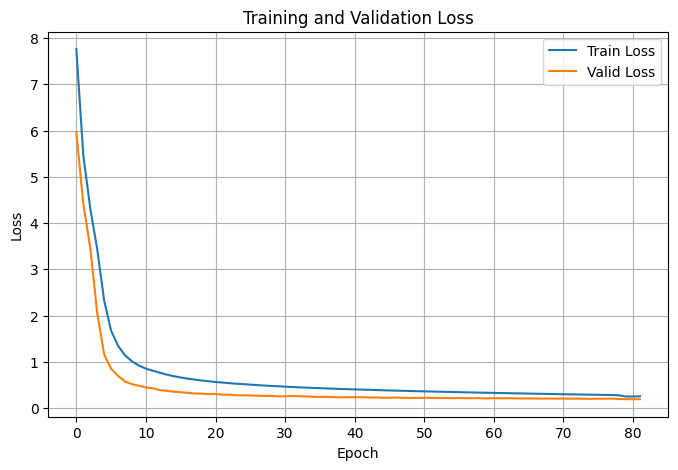

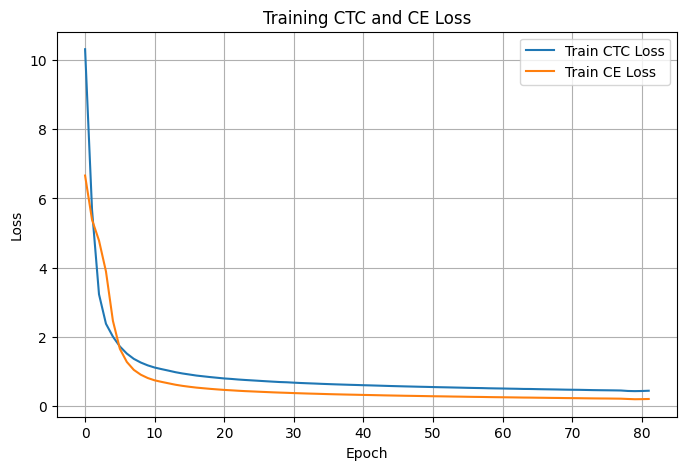

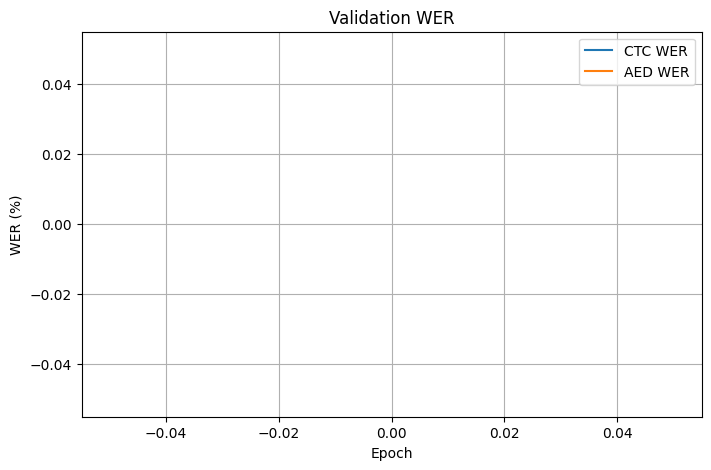

In [ ]:
trainer.plot_loss()
trainer.plot_train_loss()
trainer.plot_wer()

In [ ]:
_, _ = trainer.test(test_clean_loader)
_, _ = trainer.test(test_other_loader)
_, _ = trainer.test(dev_clean_loader)
_, _ = trainer.test(dev_other_loader)
_, _ = trainer.test(ted_dev_loader)
_, _ = trainer.test(ted_test_loader)

Test: 100%|██████████| 164/164 [05:29<00:00,  2.01s/it]


CTC WER: 6.84, AR WER: 5.18
Sample 1:
Label: a ring of amethyst i could not wear here plainer to my sight than that first kiss
CTC: a ring of amethyist i could not wear here plainer to my sight than that first kiss
AR: a ring of amethyst i could not wear here plainer to my sight than that first kiss
Sample 2:
Label: that was the chrism of love which love's own crown with sanctifying sweetness did precede the third upon my lips was folded down in perfect purple state since when indeed i have been proud and said my love my own
CTC: that was the chism of love which love loves own crown with sanctifying sweetness did proceed the third upon my lips was folded down in perfect purple state since when indeed i have been proud and said my love my own
AR: that was the chrism of love which loves own crown with sanctifying sweetness did proceed the third upon my lips was folded down in perfect purple state since when indeed i have been proud and said my love my own
Sample 3:
Label: dearest teach m

Test: 100%|██████████| 184/184 [05:17<00:00,  1.73s/it]


CTC WER: 16.82, AR WER: 13.15
Sample 1:
Label: during all this time isaac of york sat mournfully apart grieving for the loss of his dearly loved daughter rebecca
CTC: during all this timeicaac of york sat mournfully apart grieving for the loss of his dailyly loved daughter rebecca
AR: during all this time missa of york sat mournfully apart grieving for the loss of his daily loved daughter rebecca
Sample 2:
Label: and with this epistle the unhappy old man set out to procure his daughter's liberation
CTC: and with this epistle and happy old man set out to procure his daughter's liberation
AR: and with this epistle and happy old man set out to procure his daughter's liberation
Sample 3:
Label: the templar is fled said de bracy in answer to the prince's eager questions front de boeuf you will never see more and he added in a low and emphatic tone richard is in england i have seen him and spoken with him
CTC: the tem is flat said the braacy in answer of the prince's eager questions from the

Test: 100%|██████████| 169/169 [05:22<00:00,  1.91s/it]


CTC WER: 6.88, AR WER: 5.03
Sample 1:
Label: the second part begins here saying be now the third here then while it was his pleasure
CTC: the second part begins here saying be now the third here then while it was his pleasure
AR: the second part begins here saying be now the third here then while it was his pleasure
Sample 2:
Label: he lives thy loss he dies from every limb mangled by thee lightnings of godhead shine from which thy darkness hath not where to hide
CTC: he lives thy loss he dies from every limb mangled by thee lightnings of godhead shine from which thy darkness hath not where to hide
AR: he lives thy loss he dies from every limb mangled by thee lightnings of godhead shine from which thy darkness hath not where to hide
Sample 3:
Label: quinci impara a stupirti
CTC: quching andparasuii
AR: quixote and parastopyre


Test: 100%|██████████| 179/179 [04:57<00:00,  1.66s/it]


CTC WER: 16.47, AR WER: 12.65
Sample 1:
Label: but the painter then the portrait
CTC: but the pain is in the portrait
AR: but the pain is in the portrait
Sample 2:
Label: why you seem to have only that name in your mouth
CTC: are you see to him only that name in your mouth
AR: will you see to him only that name in your mouth
Sample 3:
Label: i do not suppose it will concern you
CTC: i did not suppose it will concern you
AR: i did not suppose it will concern you


Test: 100%|██████████| 74/74 [02:23<00:00,  1.94s/it]


CTC WER: 29.05, AR WER: 28.13
Sample 1:
Label: the naked geography of hope so what we 're trying to do at the national geographic finally is we believe that politicians will never accomplish anything
CTC: the naked geography of hope so what were trying to do the natural geographic finely is we believe that politicians will never accomplish anything
AR: the naked geography of hope so what were trying to do the national geographic finely is we believe that politicians will never accomplish anything
Sample 2:
Label: we think that polemics we think that polemics
CTC: ah we think the polymx think of pomx
AR: ah we think that polynics we think of polynics
Sample 3:
Label: are not persuasive but we think that storytelling can change the world and so we are probably the best storytelling institution in the world we get thirty five million
CTC: are not persuasive but we think that story telling can change the world and so we are probably the best story telling institution in the world get thirt

Test: 100%|██████████| 184/184 [04:46<00:00,  1.55s/it]


CTC WER: 36.03, AR WER: 34.22
Sample 1:
Label: and what the marshmallow challenge does is it helps them identify the hidden assumptions because frankly
CTC: and what the marmeow challenge do does that helps might identify the hidden assumptions because frankly
AR: and what the marshmallow challenges that helps might identify the hidden assumptions because frankly
Sample 2:
Label: every project has its own marshmallow doesn 't it the challenge provides a shared experience a common language a common stance to build the right prototype and so this is the value of the experience of this so simple exercise and those of you who are interested may want to go to marshmallowchallenge dot com it 's a blog that you can look at how to build the marshmallows there 's step by step instructions on this there are
CTC: every project has its own marsh mellow doesntna that the challenge provides a shared experience a common language a common st to build the right frotety and so this is the value of the e

In [ ]:
def encoder_layer_visualization(output_list, ctc_output_lengths, batch_idx=0, layer_idx=0, d_inner=144):
    """
    將 MambaEncoder 特定層的中間張量進行視覺化。
    此版本直接處理 left-padded 張量，無需轉換。

    參數:
        output_list (dict): 從模型 forward 後得到的字典，包含 'o1', 'o2', 和 'outputs' 張量。
        ctc_output_lengths (torch.Tensor): Encoder 輸出對應的有效長度張量。
        batch_idx (int): 要視覺化的批次項目索引。
        layer_idx (int): 要視覺化的 Encoder 層索引。
    """
    # --- 檢查索引有效性 ---
    num_layers = len(output_list["outputs"])
    if not (0 <= layer_idx < num_layers):
        print(f"錯誤：無效的 layer_idx ({layer_idx})。可用的層數為 0 到 {num_layers - 1}。")
        return

    batch_size = output_list["outputs"][0].shape[0]
    if not (0 <= batch_idx < batch_size):
        print(f"錯誤：無效的 batch_idx ({batch_idx})。此批次大小為 {batch_size}，可用索引為 0 到 {batch_size - 1}。")
        return

    # --- 從批次中提取單一樣本的數據和其有效長度 ---
    valid_length = ctc_output_lengths[batch_idx].item()
    
    # 提取對應的 left-padded 張量 (shape: [L, D])
    layer_before_attn_padded = output_list["o1"][layer_idx][batch_idx]
    layer_after_attn_padded = output_list["o2"][layer_idx][batch_idx]
    layer_after_conv_padded = output_list["o3"][layer_idx][batch_idx]
    layer_output_padded = output_list["outputs"][layer_idx][batch_idx]

    # --- 直接從 left-padded 張量中切片出有效部分 ---
    # 有效數據位於張量的尾部，所以我們取最後 'valid_length' 個時間步
    layer_before_attn = layer_before_attn_padded[-valid_length:, :d_inner].cpu().numpy()
    layer_after_attn = layer_after_attn_padded[-valid_length:, :d_inner].cpu().numpy()
    layer_after_conv = layer_after_conv_padded[-valid_length:, :d_inner].cpu().numpy()
    layer_output = layer_output_padded[-valid_length:, :].cpu().numpy()

    # --- 繪製圖像 ---
    fig, axs = plt.subplots(1, 3, figsize=(20, 6))
    # fig.suptitle(f"Encoder {layer_idx + 1} layer visualization (Batch Item {batch_idx})", fontsize=16)

    # 圖 1: Local Attention 之前
    im1 = axs[0].imshow(layer_before_attn.T, aspect='auto', origin='lower', interpolation='none')
    axs[0].set_title("Input")
    axs[0].set_xlabel("Time Steps")
    axs[0].set_ylabel("Feature Dimension")
    fig.colorbar(im1, ax=axs[0])

    # 圖 2: Local Attention 之後
    im2 = axs[1].imshow(layer_after_attn.T, aspect='auto', origin='lower', interpolation='none')
    axs[1].set_title("After Local Attention")
    axs[1].set_xlabel("Time Steps")
    fig.colorbar(im2, ax=axs[1])

    # 圖 3: 層的輸出
    im3 = axs[2].imshow(layer_after_conv.T, aspect='auto', origin='lower', interpolation='none')
    axs[2].set_title("After Convolution")
    axs[2].set_xlabel("Time Steps")
    fig.colorbar(im3, ax=axs[2])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

Test:   0%|          | 0/164 [00:00<?, ?it/s]

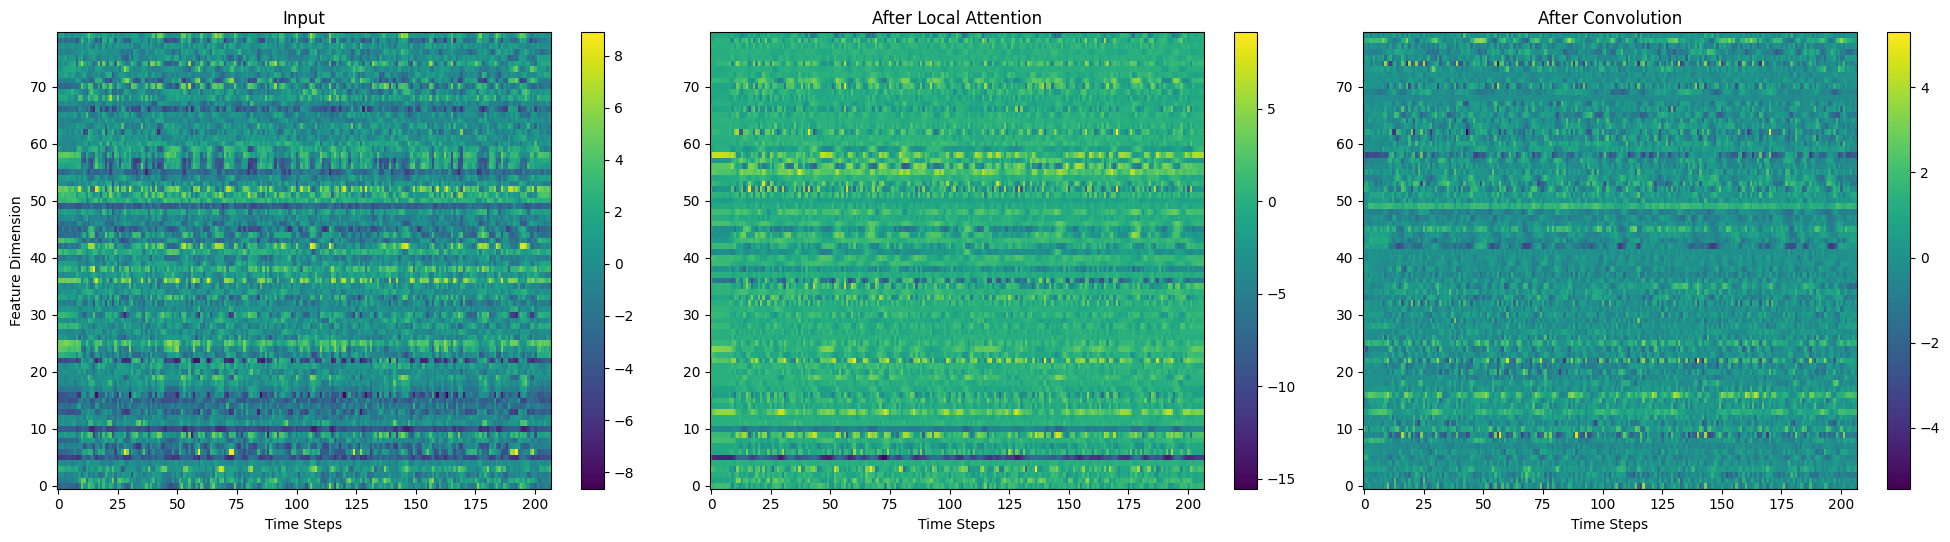

Test:   1%|          | 1/164 [00:03<10:42,  3.94s/it]

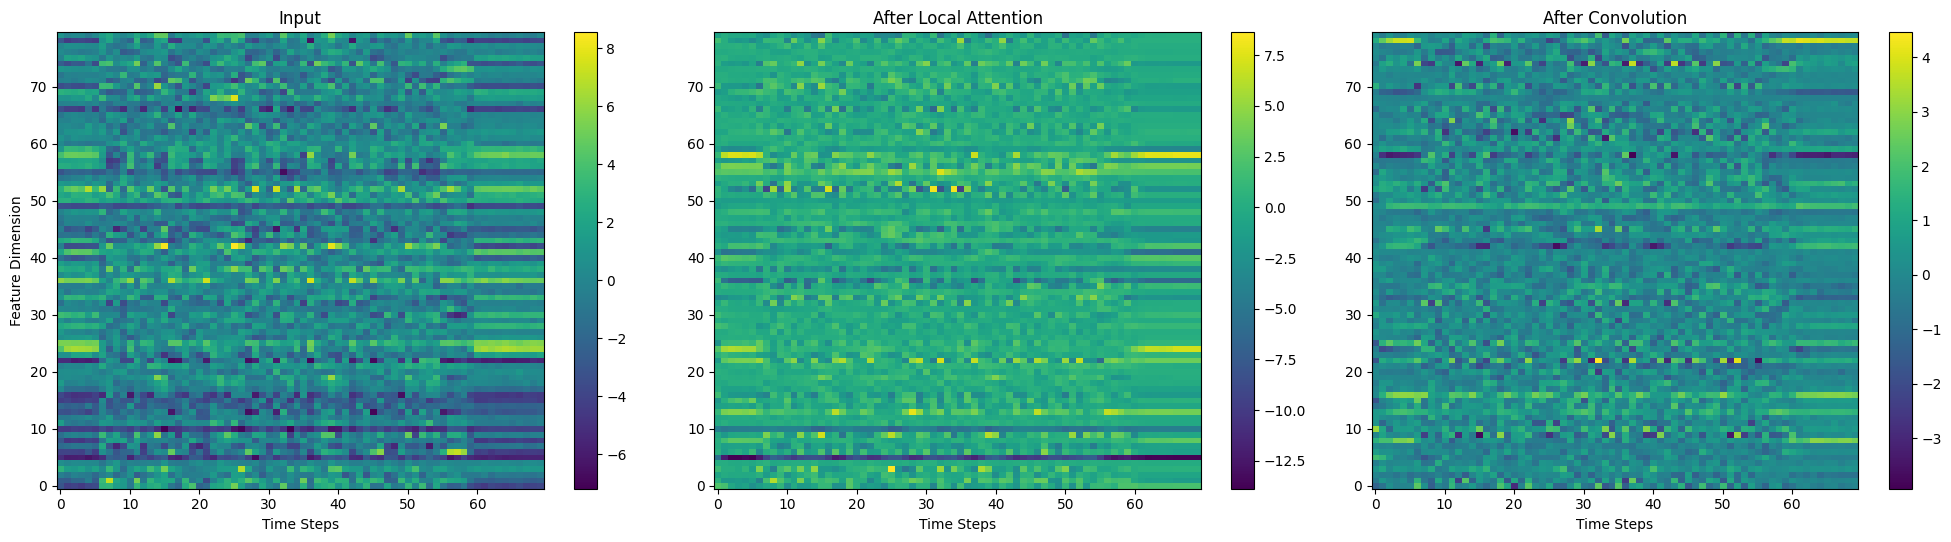

Test:   1%|          | 2/164 [00:04<05:04,  1.88s/it]

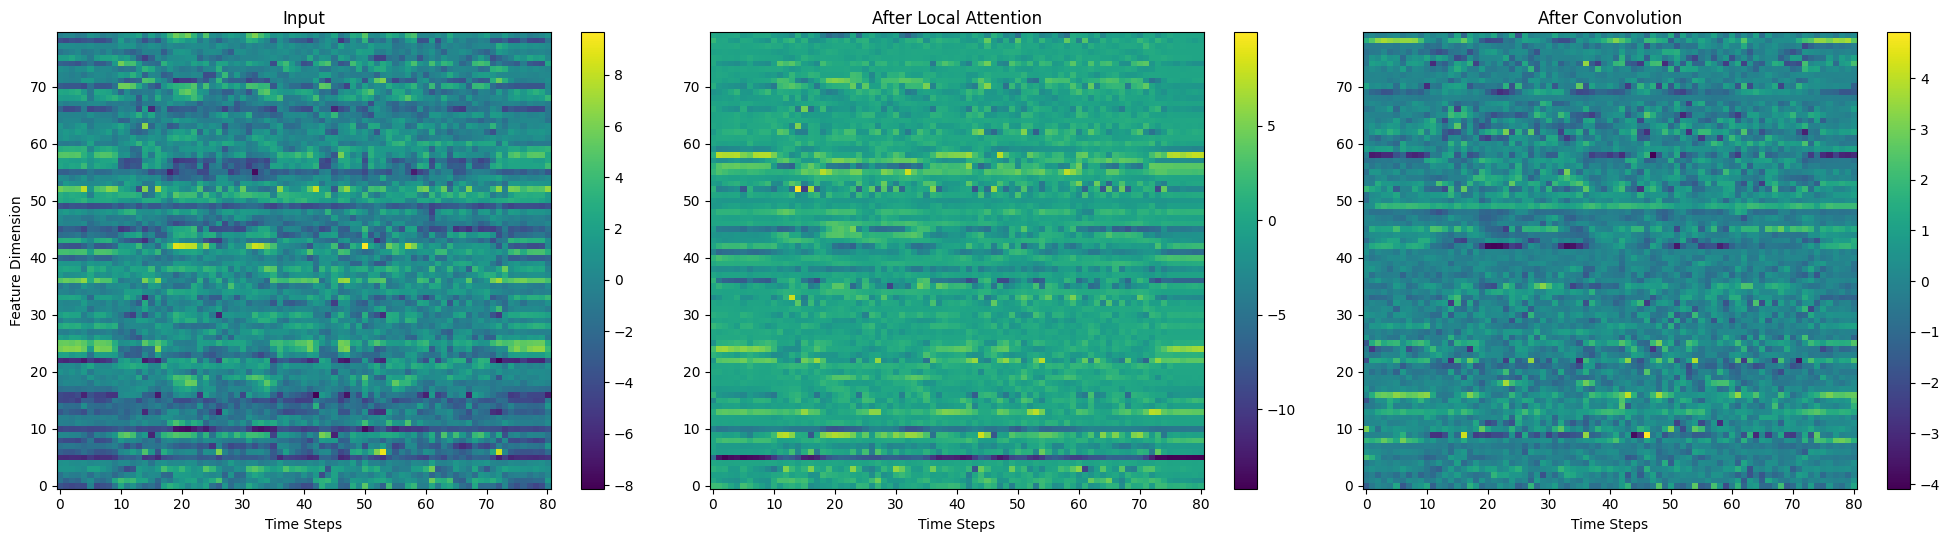

Test:   2%|▏         | 3/164 [00:04<03:15,  1.21s/it]

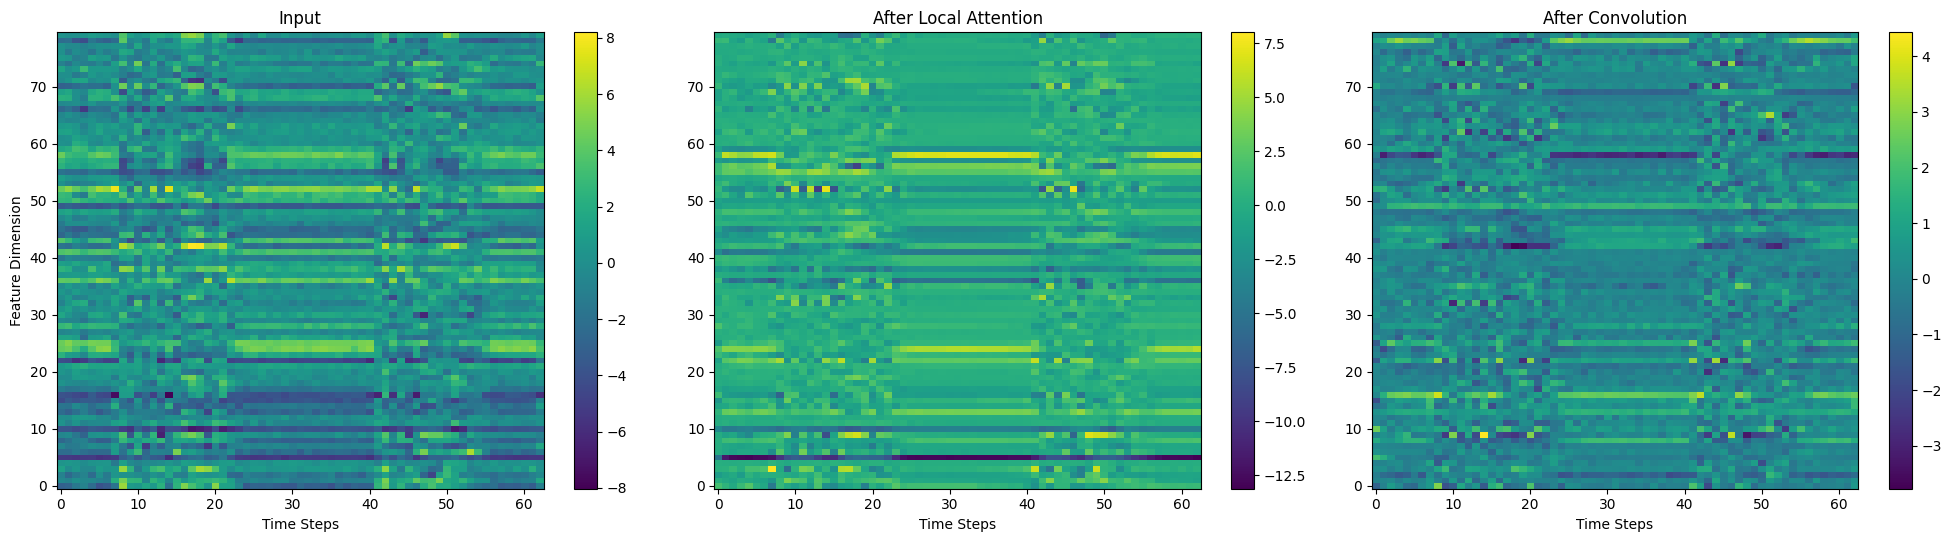

Test:   2%|▏         | 4/164 [00:05<02:24,  1.10it/s]

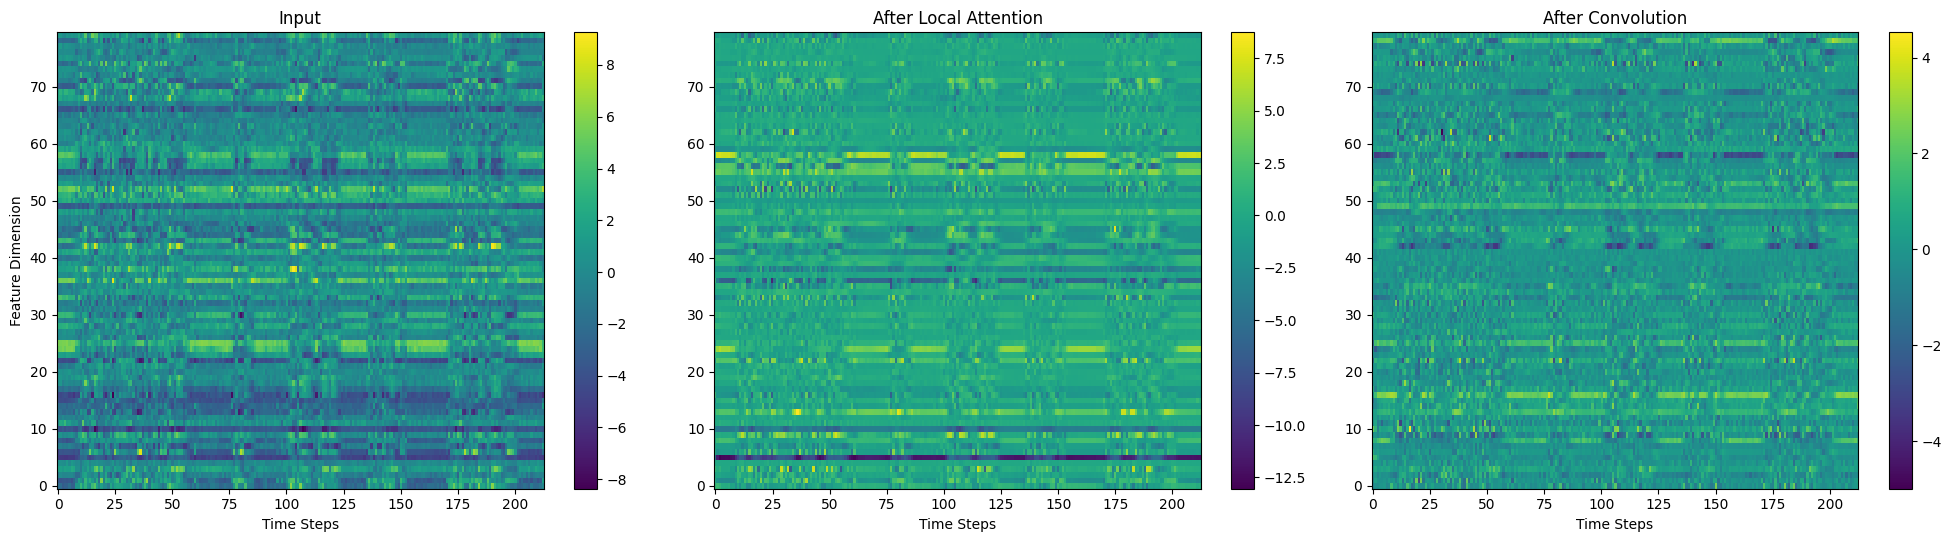

Test:   3%|▎         | 5/164 [00:05<01:56,  1.37it/s]

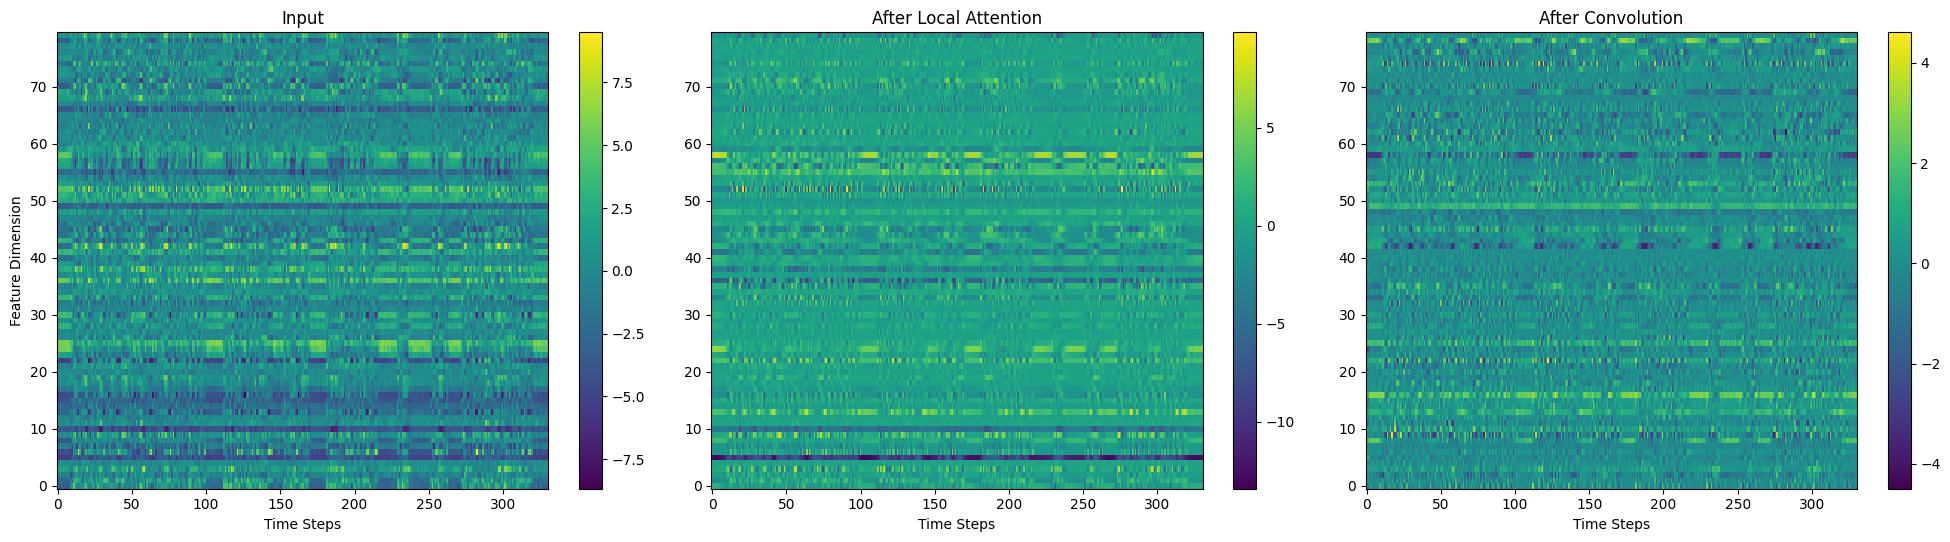

Test:   4%|▎         | 6/164 [00:06<01:39,  1.58it/s]

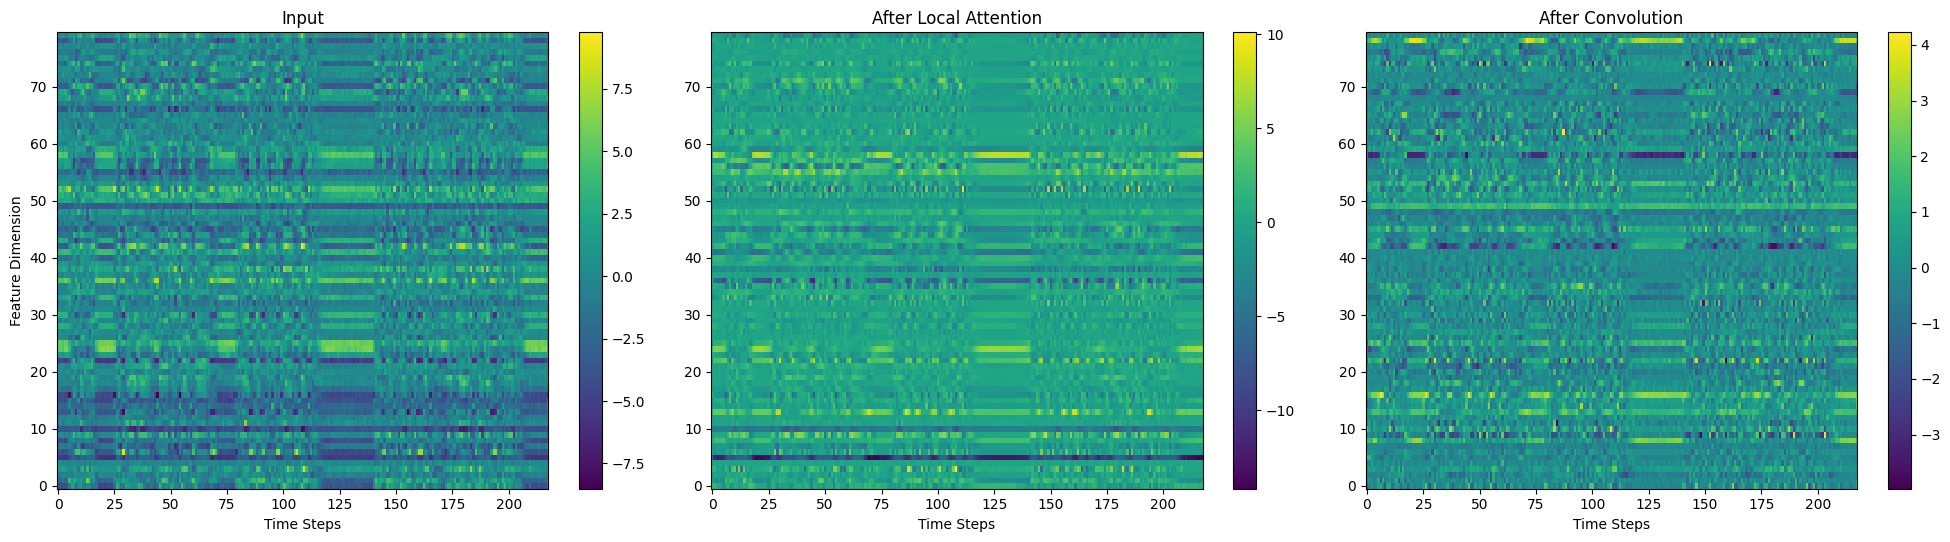

Test:   4%|▍         | 7/164 [00:06<01:29,  1.75it/s]

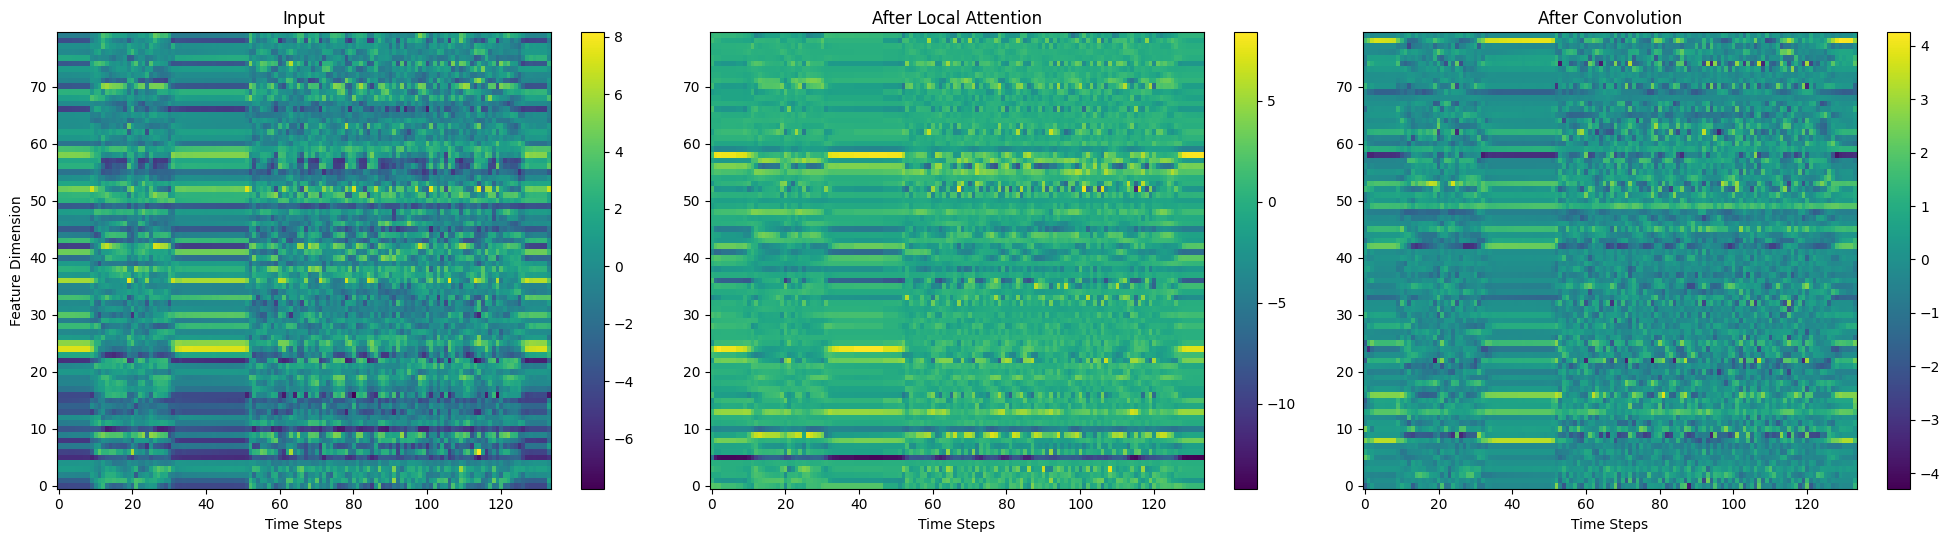

Test:   5%|▍         | 8/164 [00:07<01:33,  1.67it/s]

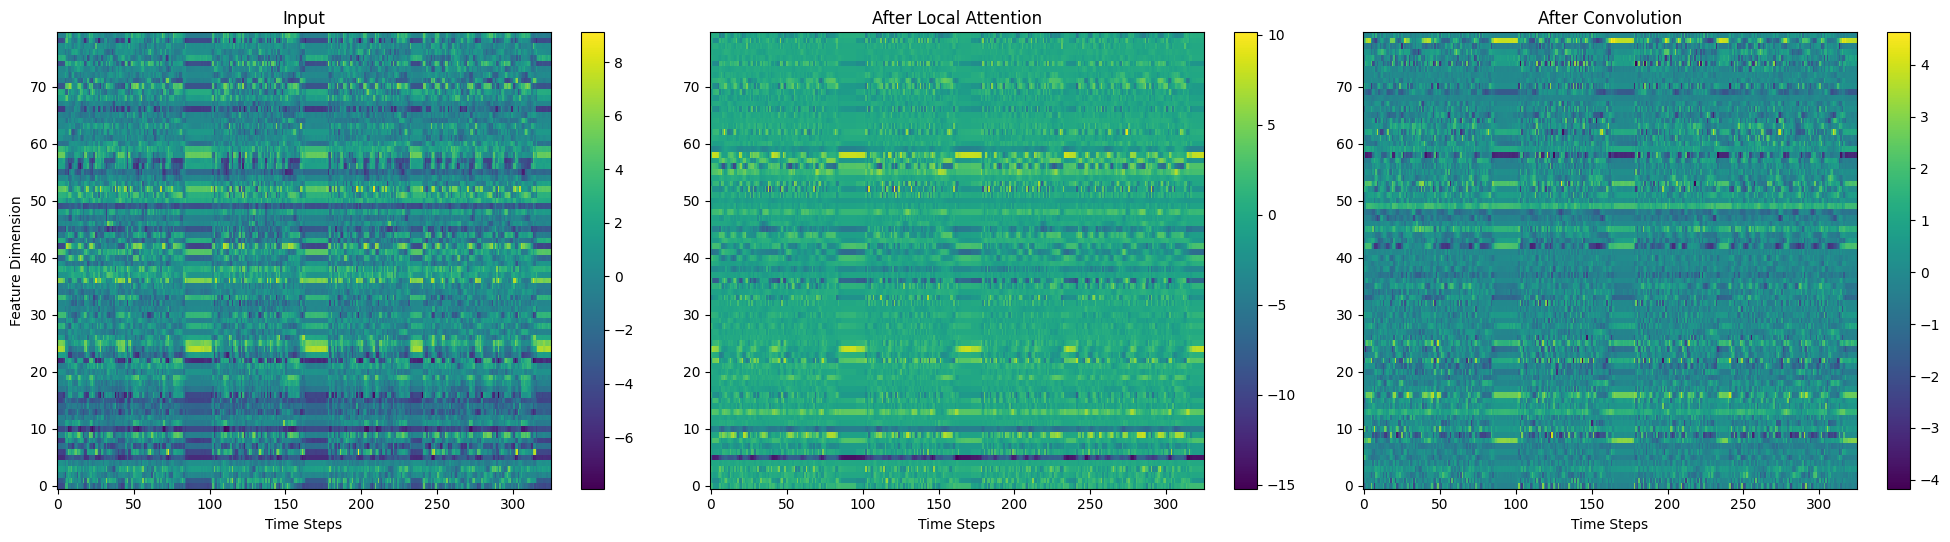

Test:   5%|▌         | 9/164 [00:07<01:25,  1.82it/s]

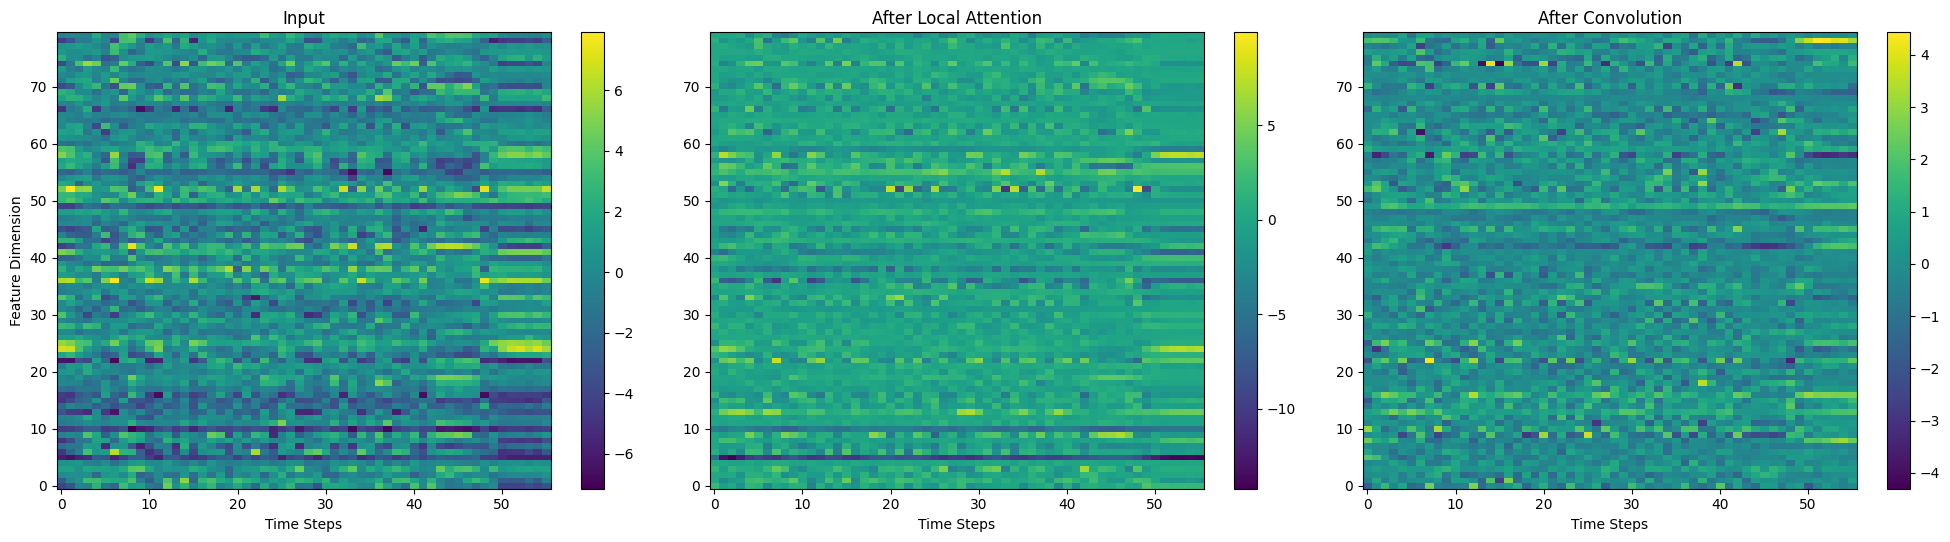

Test:   6%|▌         | 10/164 [00:08<01:17,  1.98it/s]

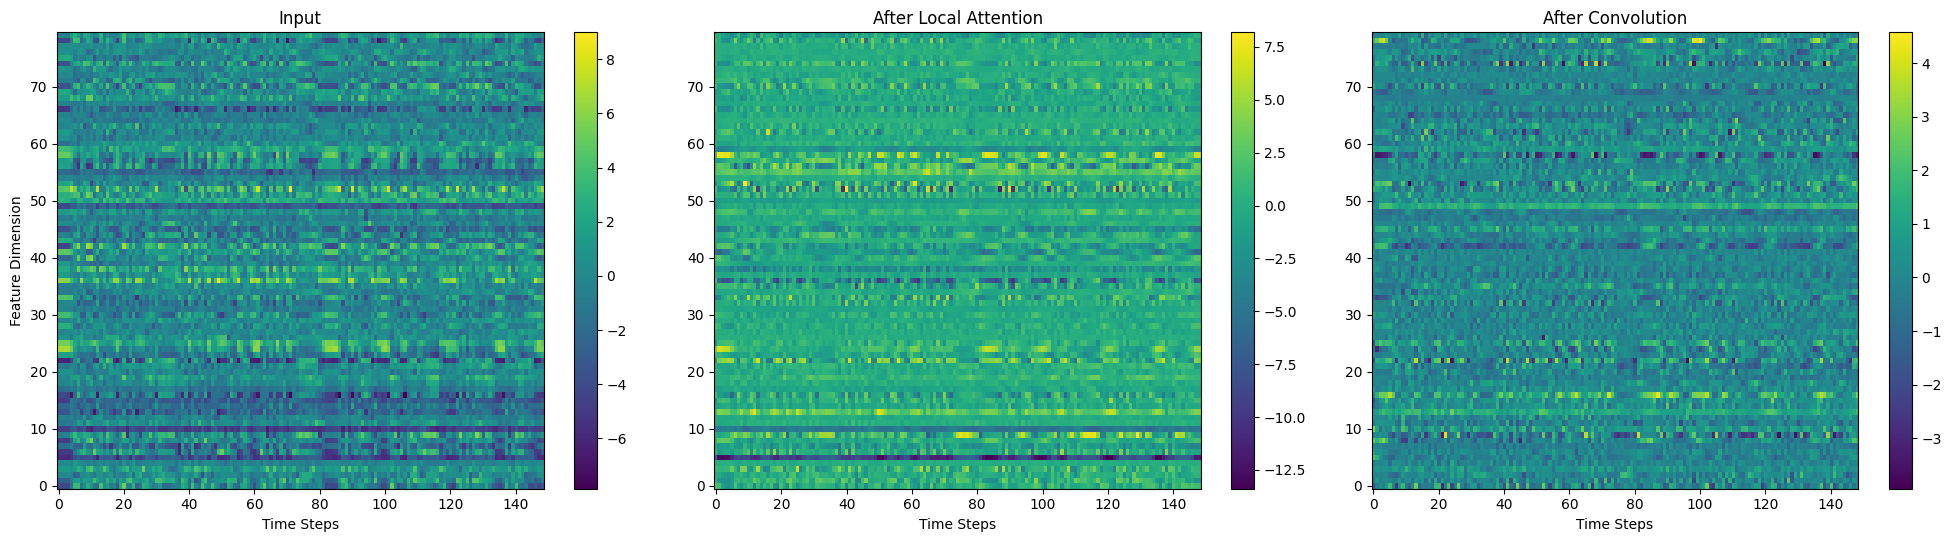

Test:   7%|▋         | 11/164 [00:08<01:14,  2.06it/s]

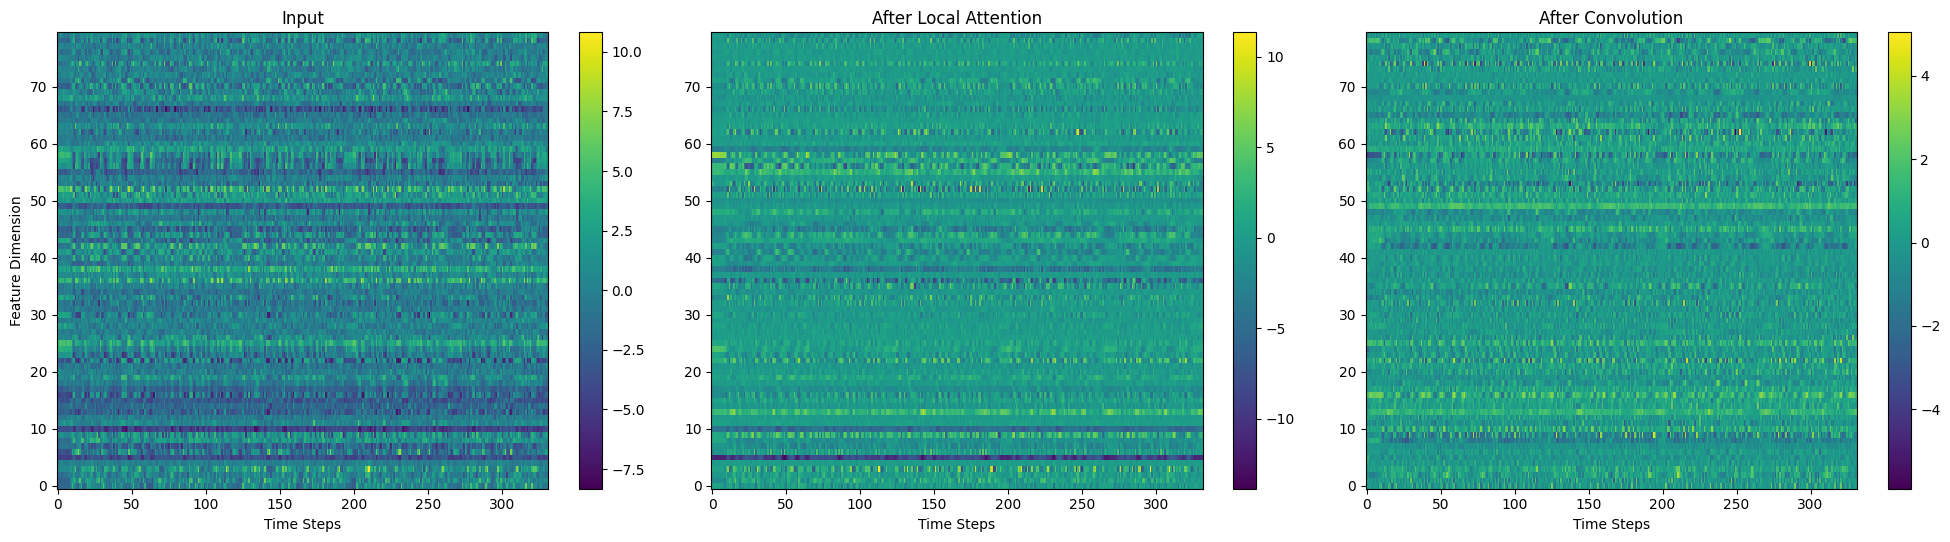

Test:   7%|▋         | 12/164 [00:08<01:11,  2.12it/s]

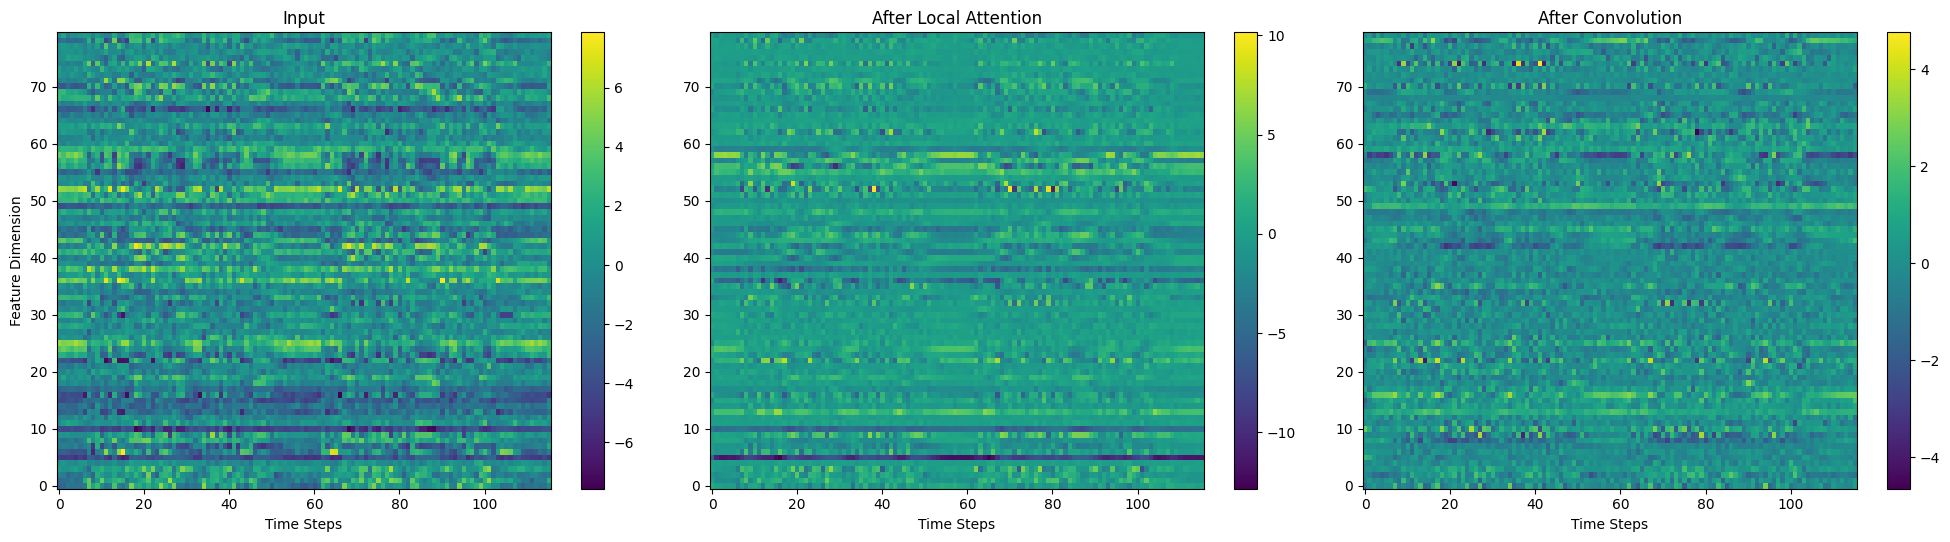

Test:   8%|▊         | 13/164 [00:09<01:08,  2.21it/s]

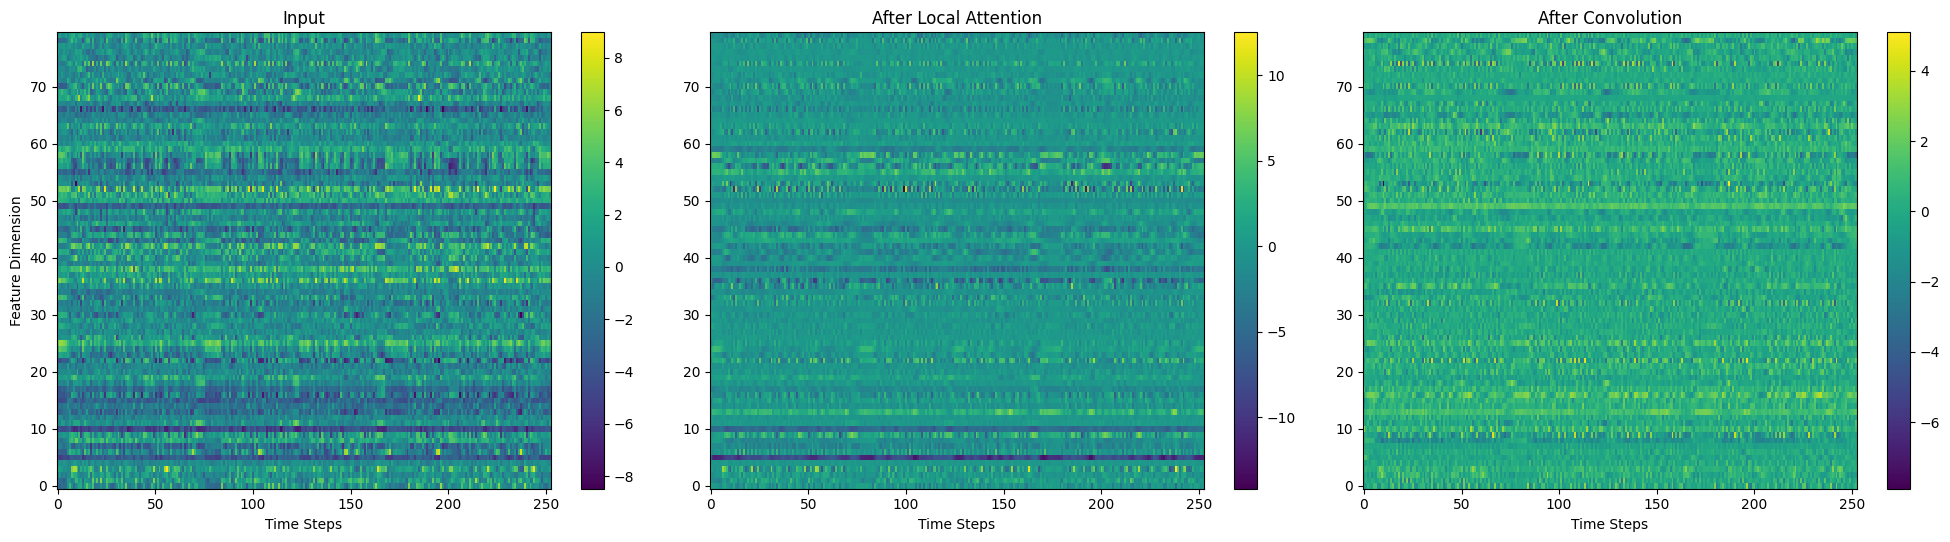

Test:   9%|▊         | 14/164 [00:09<01:06,  2.24it/s]

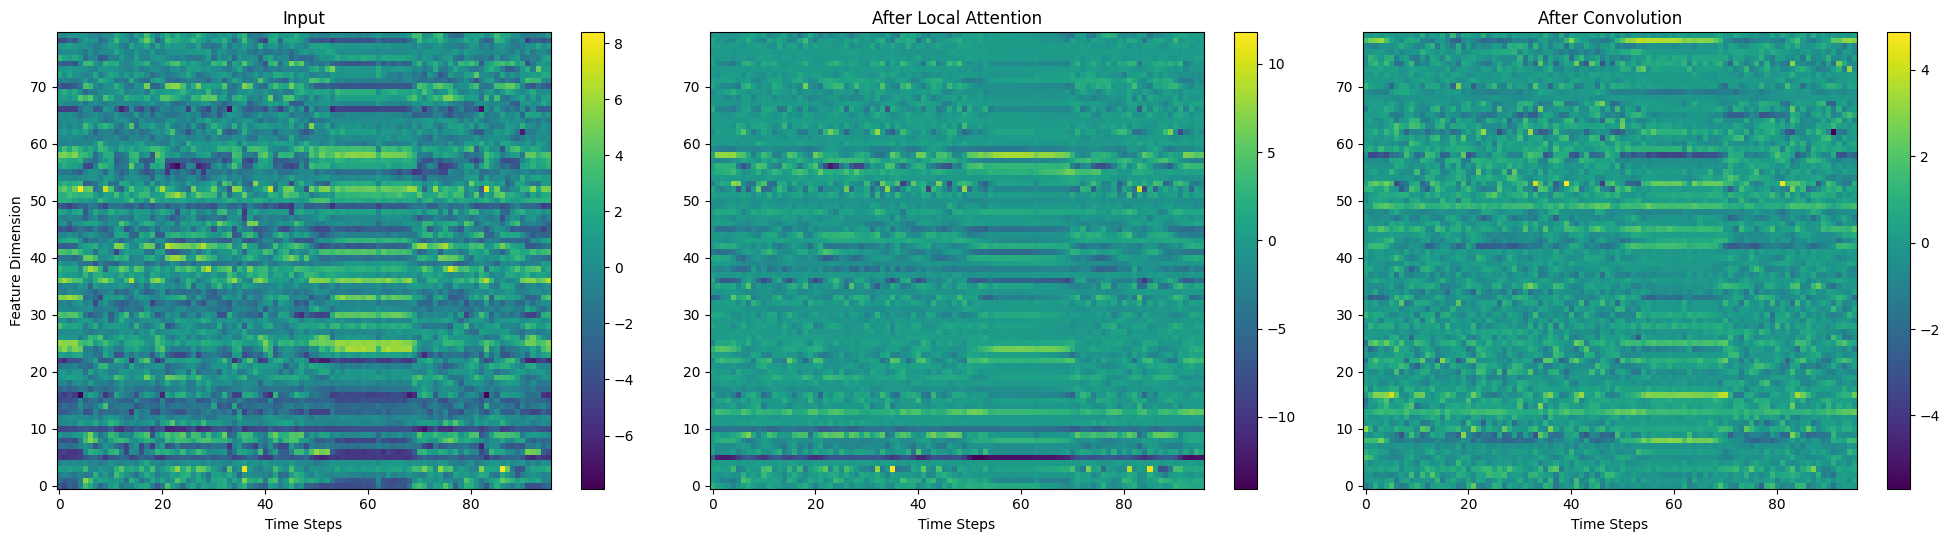

Test:   9%|▉         | 15/164 [00:10<01:05,  2.27it/s]

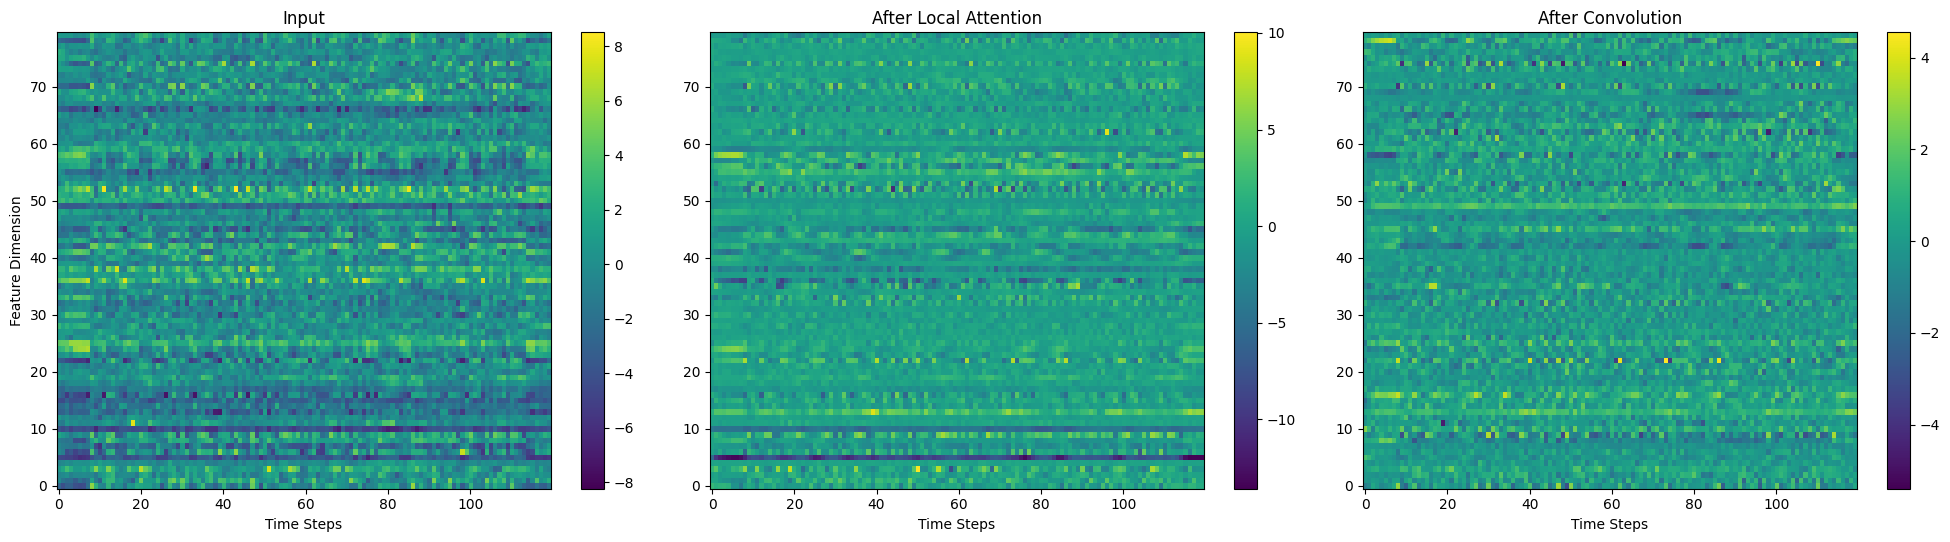

Test:  10%|▉         | 16/164 [00:10<01:10,  2.08it/s]

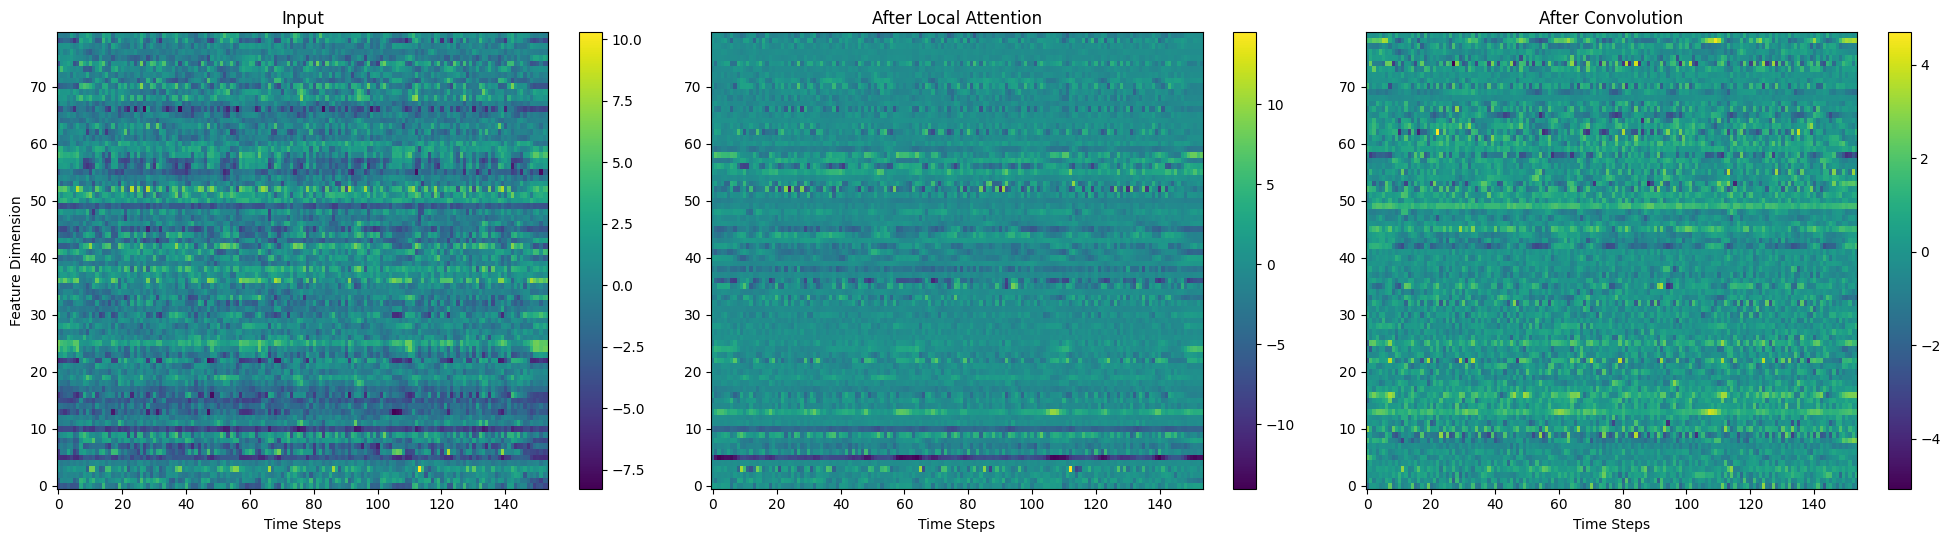

Test:  10%|█         | 17/164 [00:11<01:07,  2.18it/s]

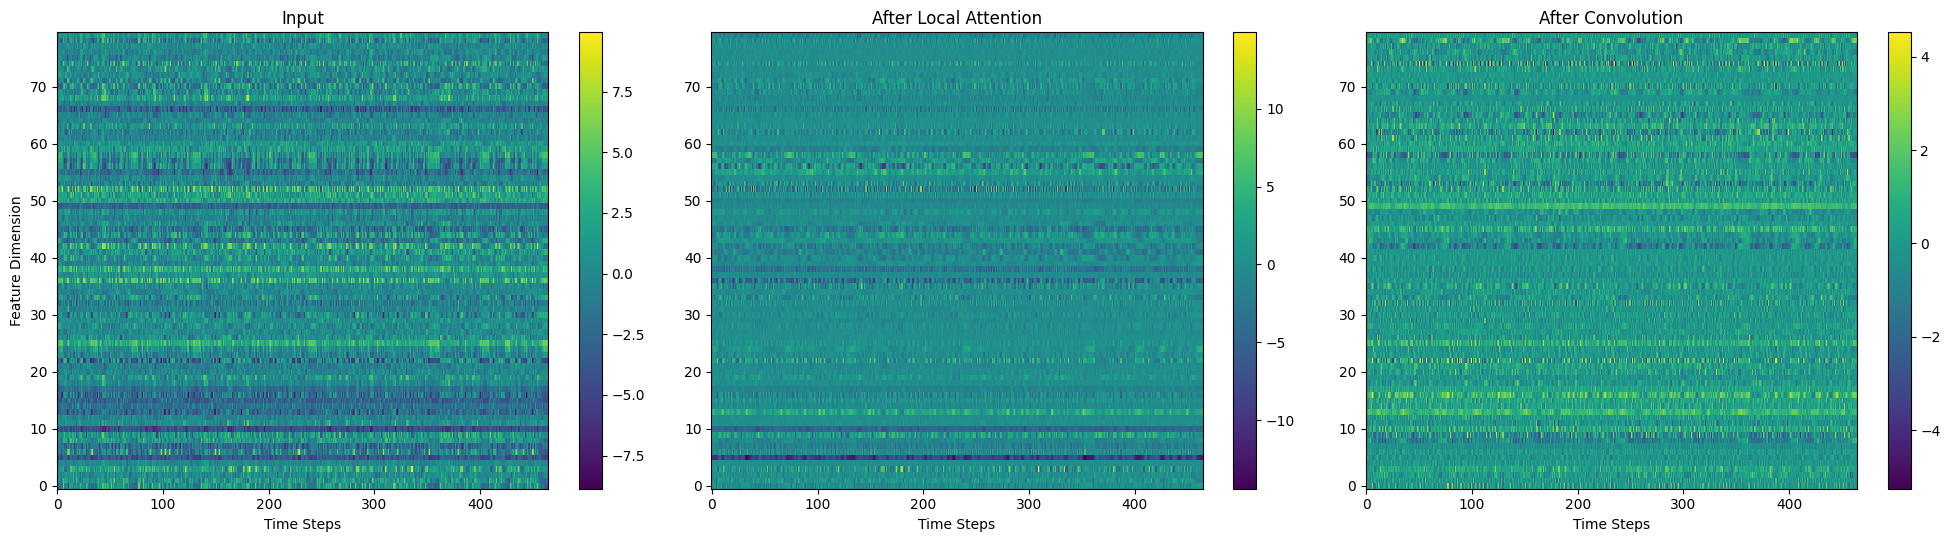

Test:  11%|█         | 18/164 [00:12<01:37,  1.49it/s]


KeyboardInterrupt: 

In [ ]:
model = Attnmamba_Crossattnmamba_Model(input_dim=input_dim,
                                        vocab_size=vocab_size,
                                        duration_size=duration_size,
                                        d_model=d_model,
                                        nhead=4,
                                        num_encoder_layers=12,
                                        num_decoder_layers=4,
                                        dim_feedforward=1024,
                                        dropout=0.1).to("cuda")

model.load_state_dict(torch.load('./weights/med960.pth', weights_only=True))
model.eval()
with torch.no_grad():
    pbar = tqdm(test_clean_loader, desc="Test")
    for batch in pbar:
        spectrograms, labels, ar_tgts, aed_labels, input_lengths, label_lengths = batch
        src = spectrograms.squeeze(1).transpose(1, 2).to(device)
        ar_tgts = ar_tgts.to(device)  # [batch, tgt_seq_len]
        labels = labels.to(device)  # [batch, tgt_seq_len]
        aed_labels = aed_labels.to(device)  # [batch, tgt_seq_len]

        input_lengths_tensor = torch.tensor(input_lengths, dtype=torch.long, device=device)
        label_lengths_tensor = torch.tensor(label_lengths, dtype=torch.long, device=device)

        ctc_logits, ar_logits, ctc_output_lengths, output_list = model(src, ar_tgts, input_lengths_tensor, label_lengths_tensor)

        encoder_layer_visualization(output_list, ctc_output_lengths, batch_idx=0, layer_idx=0, d_inner=80)
